In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import os
import subprocess
import time
import pandas as pd
import pickle
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.metrics import accuracy_score, silhouette_score, adjusted_rand_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
from sklearn.model_selection import KFold, LeaveOneOut, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from sklearn.manifold import TSNE
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import (ModelDesc, EvalEnvironment, Term, EvalFactor, LookupFactor, dmatrices, INTERCEPT)
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
from matplotlib.lines import Line2D
import sys
import re
from concurrent.futures import ProcessPoolExecutor

In [17]:
from nex5file.reader import Reader
from nex5file.filedata import FileData
import nex5file
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import os
import subprocess
import time
import pandas as pd
import pickle
import math
import multiprocessing
from functools import partial
import random

In [42]:
base_dir = "./Data"
nex_dir = "./Nex"

databin = 0.01
BinSize = 0.3
TimeRange_before = 6
TimeRange_after = 6.3
Bins = int((TimeRange_before+TimeRange_after)/BinSize)
Bins_before = int(TimeRange_before/BinSize) 

In [19]:
import re


filenames = os.listdir(nex_dir)

# Regular expression pattern to match number+letter+number before an underscore
pattern = r'\d{1,2}[A-Za-z]\d{1,2}'

# Extract and store animal IDs
animal_ids = [re.search(pattern, filename.split('_')[0]).group() for filename in filenames if re.search(pattern, filename)]

len(animal_ids)

30

In [22]:
# Load the csv file with cross timepoints
interval_data = pd.read_csv(os.path.join(base_dir,"Trial by Trial Cues.csv"), header = 1)
photoid = pd.read_csv(os.path.join(base_dir,"PhotoTags.csv"), index_col =0)

In [26]:
def read_nex_files(nex_dir):
    neuron_data = {}
    nex_files = [file for file in os.listdir(nex_dir) if file.endswith('.nex')]
    reader = Reader()

    for nex_file in nex_files:
        file_path = os.path.join(nex_dir, nex_file)
        
        # Extract animal ID from filename
        pattern = r'\d{1,2}[A-Za-z]\d{1,2}'
        match = re.search(pattern, nex_file.split('_')[0])
        if match:
            animal_id = match.group()

            # Read only headers first to get neuron names
            variabelnames = reader.ReadNexHeadersOnly(file_path)

            # Filter neuron names based on photoid DataFrame
            spk_names = photoid[photoid['Animal_ID'] == animal_id]['Unit_id'].tolist()
            neuron_names = [name for name in variabelnames.NeuronNames() if name in spk_names]

            # Read only the relevant neuron variables
            fileData = reader.ReadNexFileVariables(file_path, neuron_names)

            # Get timestamps for each relevant neuron and store them
            for variable in fileData.variables:
                timestamps = variable.timestamps
                neuron_data[(animal_id, variable.metadata['name'])] = timestamps
        else:
            print(f"Pattern not found in {nex_file}")

    return neuron_data




In [27]:
neuron_data = read_nex_files(nex_dir)
neuron_data

{('1U1',
  'SPK01a'): array([1.57800000e-01, 5.98200000e-01, 6.78200000e-01, ...,
        3.35959312e+03, 3.35962195e+03, 3.35997590e+03]),
 ('1U1',
  'SPK02a'): array([2.98150000e-01, 6.36075000e-01, 7.84200000e-01, ...,
        3.35928670e+03, 3.35937010e+03, 3.35944758e+03]),
 ('1U1',
  'SPK08a'): array([1.30575000e-01, 1.53975000e-01, 5.89225000e-01, ...,
        3.35843408e+03, 3.35878010e+03, 3.35933395e+03]),
 ('1U1',
  'SPK09a'): array([8.37500000e-03, 2.22395000e+00, 2.56545000e+00, ...,
        3.35415430e+03, 3.35720718e+03, 3.35749190e+03]),
 ('1U1',
  'SPK12a'): array([1.24250000e-02, 4.94750000e-02, 1.52250000e-01, ...,
        3.35908957e+03, 3.35960280e+03, 3.35999008e+03]),
 ('1U1',
  'SPK24a'): array([6.70750000e-02, 7.72750000e-02, 1.16200000e-01, ...,
        3.35915767e+03, 3.35938360e+03, 3.35967908e+03]),
 ('1U1',
  'SPK25a'): array([2.59000000e-01, 4.04375000e-01, 5.89825000e-01, ...,
        3.35935842e+03, 3.35946823e+03, 3.35958887e+03]),
 ('1U1',
  'SPK26a')

In [28]:
def calculate_perievent_firing_rates(spike_timestamps, events_timestamps, XMin, XMax, Bin, normalization='Counts/Bin'):
    # Number of bins
    num_bins = int(np.ceil((XMax - XMin) / Bin))
    bin_edges = np.linspace(XMin, XMax, num_bins + 1)
    bin_counts = np.zeros(num_bins)

    # Iterate over each reference event
    for ref in events_timestamps:
        # Calculate distances and filter out-of-range spikes
        distances = spike_timestamps - ref
        distances = distances[(distances >= XMin) & (distances < XMax)]

        # Use numpy histogram to count spikes in bins
        counts, _ = np.histogram(distances, bins=bin_edges)
        bin_counts += counts

    # Normalize if required
    if normalization == 'Spikes/Sec':
        bin_counts = bin_counts / (len(events_timestamps) * Bin)

    return bin_counts

def calculate_neuron_firing_rates(neuron_id, neuron_data, interval_data, XMin, XMax, Bin, cue_range, normalization='Counts/Bin'):
    spike_timestamps = neuron_data[neuron_id]
    animal_id = neuron_id[0]  # Assuming the first element of the tuple is the animal ID
    events_timestamps = interval_data[animal_id][cue_range[0]:cue_range[1]].to_numpy()

    firing_rates = calculate_perievent_firing_rates(spike_timestamps, events_timestamps, XMin, XMax, Bin, normalization)
    return neuron_id, firing_rates

# Function to be executed in parallel
def process_neuron_data(neuron_id, neuron_data, interval_data, XMin, XMax, Bin, cue_range, normalization):
    return calculate_neuron_firing_rates(neuron_id, neuron_data, interval_data, XMin, XMax, Bin, cue_range, normalization)


def parallel_firing_rates_calculation(neuron_data, interval_data, XMin, XMax, Bin, cue_range, normalization='Spikes/Sec'):
    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
    func = partial(process_neuron_data, neuron_data=neuron_data, interval_data=interval_data, XMin=XMin, XMax=XMax, Bin=Bin, cue_range = cue_range, normalization=normalization)
    results = pool.map(func, neuron_data.keys())
    pool.close()
    pool.join()

    # Create a DataFrame from the results
    columns = ['AnimalID', 'NeuronID'] + [f'{i}' for i in range(int(np.ceil((XMax - XMin) / Bin)))]
    data = []
    for (animal_id, neuron_id), firing_rates in results:
        row = [animal_id, neuron_id] + firing_rates.tolist()
        data.append(row)

    df = pd.DataFrame(data, columns=columns)
    return df

# Example usage
XMin = -30  # Define your XMin
XMax = 30   # Define your XMax
Bin = 0.3  # Define your Bin size
reward_cue = (0,12)

# Example call to the parallel processing function
reward_cue_firing_rates_df = parallel_firing_rates_calculation(neuron_data, interval_data, XMin, XMax, Bin, reward_cue)

# Display the DataFrame
print(reward_cue_firing_rates_df.head())



  AnimalID NeuronID         0         1         2         3         4  \
0      1U1   SPK01a  4.166667  3.888889  3.333333  1.666667  3.055556   
1      1U1   SPK02a  5.277778  5.277778  3.055556  4.722222  6.111111   
2      1U1   SPK08a  1.666667  1.111111  1.944444  3.055556  1.388889   
3      1U1   SPK09a  1.388889  0.833333  0.833333  1.111111  0.555556   
4      1U1   SPK12a  8.333333  5.277778  7.500000  6.388889  6.944444   

          5         6         7  ...       190       191       192       193  \
0  3.055556  1.388889  2.777778  ...  3.333333  2.500000  1.944444  2.777778   
1  5.000000  4.166667  5.000000  ...  6.944444  5.555556  3.611111  7.222222   
2  2.500000  2.777778  3.333333  ...  3.055556  4.722222  2.777778  3.055556   
3  2.500000  2.222222  1.944444  ...  1.944444  2.222222  0.555556  1.944444   
4  8.333333  9.722222  5.000000  ...  6.111111  5.000000  6.944444  8.055556   

        194       195       196       197       198       199  
0  1.388889  2.2

In [29]:
reward_cue_firing_rates_df

AnimalID NeuronID         0         1         2         3         4  \
0        1U1   SPK01a  4.166667  3.888889  3.333333  1.666667  3.055556   
1        1U1   SPK02a  5.277778  5.277778  3.055556  4.722222  6.111111   
2        1U1   SPK08a  1.666667  1.111111  1.944444  3.055556  1.388889   
3        1U1   SPK09a  1.388889  0.833333  0.833333  1.111111  0.555556   
4        1U1   SPK12a  8.333333  5.277778  7.500000  6.388889  6.944444   
..       ...      ...       ...       ...       ...       ...       ...   
408      4U5   SPK27a  2.777778  1.388889  3.055556  3.333333  2.777778   
409      4U5   SPK28a  6.666667  5.555556  4.166667  4.166667  5.000000   
410      4U5   SPK29a  8.333333  8.611111  5.000000  6.388889  6.666667   
411      4U5   SPK31a  2.222222  1.944444  2.222222  1.111111  1.666667   
412      4U5   SPK31b  2.500000  5.000000  3.888889  2.777778  3.055556   

            5         6         7  ...       190       191       192  \
0    3.055556  1.388889  2.777778  ...  3.333333  2.500000  1.944444   
1    5.000000  4.166667  5.000000  ...  6.944444  5.555556  3.611111   
2    2.500000  2.777778  3.333333  ...  3.055556  4.722222  2.777778   
3    2.500000  2.222222  1.944444  ...  1.944444  2.222222  0.555556   
4    8.333333  9.722222  5.000000  ...  6.111111  5.000000  6.944444   
..        ...       ...       ...  ...       ...       ...       ...   
408  2.500000  5.833333  5.000000  ...  7.222222  4.722222  5.000000   
409  3.333333  3.611111  4.444444  ...  4.166667  3.611111  4.444444   
410  5.277778  8.055556  6.944444  ...  8.888889  6.666667  5.000000   
411  2.500000  4.166667  2.222222  ...  1.666667  2.222222  2.222222   
412  3.333333  3.333333  5.000000  ...  2.222222  6.111111  4.166667   

          193       194        195        196       197       198        199  
0    2.777778  1.388889   2.222222   1.388889  3.333333  3.333333   3.611111  
1    7.222222  3.611111   5.833333   5.833333  6.111111  4.166667   4.166667  
2    3.055556  3.055556   3.055556   2.500000  3.888889  2.500000   3.333333  
3    1.944444  1.111111   0.833333   0.555556  1.666667  0.277778   0.555556  
4    8.055556  4.166667   5.555556   4.722222  4.444444  4.444444   7.500000  
..        ...       ...        ...        ...       ...       ...        ...  
408  6.388889  4.444444   4.722222   5.833333  4.166667  4.444444   3.888889  
409  3.333333  6.388889   3.888889   5.000000  2.777778  4.444444   3.611111  
410  5.833333  5.000000  13.611111  16.388889  8.888889  4.722222  10.000000  
411  1.666667  1.666667   3.055556   1.388889  1.388889  2.777778   4.722222  
412  2.777778  2.500000   5.277778   5.000000  5.555556  5.833333   8.611111  

[413 rows x 202 columns]

In [30]:
reward_cue_firing_rates_df_6s = reward_cue_firing_rates_df.iloc[:, int((-XMin-TimeRange_before)/BinSize)+2:int((XMax+TimeRange_after)/BinSize)+2]
baseline_mean = reward_cue_firing_rates_df_6s.iloc[:, 0:int(XMax/BinSize)-int((-XMin-TimeRange_before)/BinSize)].mean(axis = 1)
baseline_std = reward_cue_firing_rates_df_6s.iloc[:, 0:int(XMax/BinSize)-int((-XMin-TimeRange_before)/BinSize)].std(axis = 1)

reward_cue_zscore = reward_cue_firing_rates_df_6s.sub(baseline_mean, axis = 0).divide(baseline_std, axis = 0)

In [31]:
excited_reward = reward_cue_zscore[(reward_cue_zscore.iloc[:,int(XMax/BinSize)-int((-XMin-TimeRange_before)/BinSize):int((XMax+0.6)/BinSize)-int((-XMin-TimeRange_before)/BinSize)]>1.96).any(axis =1)]
excited_reward.iloc[:,20:]

100        101        102        103       104       105       106  \
0    4.891927   2.461156  -0.273462  -0.273462 -0.577308 -0.273462  2.157310   
1    3.855073  -0.428341  -1.570585  -0.142780 -1.570585 -0.428341 -1.856146   
3    3.950387   2.956579   1.962771   1.465867  0.968963 -1.515557 -1.515557   
5    2.127820  -1.267637   0.543273  -1.267637  0.090546  0.769637 -1.267637   
25   2.000000   1.000000   0.500000   0.000000  0.500000  2.000000  2.000000   
..        ...        ...        ...        ...       ...       ...       ...   
380  9.552334   0.822252  -1.004975   0.010151 -1.208000 -0.801949  0.416202   
383  2.850816   7.755445   6.529288   3.463895  2.850816  1.011580 -0.214578   
384  3.268714  14.771520  16.496940  14.963233  9.020117  7.678123  5.952702   
395  0.558620   2.322684  -1.205443   1.734662  2.910705  1.734662 -1.793465   
404  2.919549   3.943952  -1.860999   0.529275  1.895146  1.895146  0.529275   

          107       108       109  ...       111       112       113  \
0   -0.577308  0.941924  0.334231  ...  1.853463 -0.273462  3.676542   
1   -1.570585 -2.141707 -2.427268  ... -0.142780 -1.285024 -1.285024   
3    0.472059 -0.521749  0.472059  ... -1.018653 -0.024845  0.968963   
5    1.222364  0.316909  0.769637  ... -0.135818  0.543273 -2.173092   
25   1.000000  1.500000  2.500000  ...  1.000000  0.000000  2.500000   
..        ...       ...       ...  ...       ...       ...       ...   
380 -0.395899 -0.395899  0.619227  ...  1.025277 -0.598924 -0.395899   
383 -1.440735 -0.214578 -0.827656  ... -0.214578 -0.214578  1.011580   
384  8.828403  7.102982  3.077001  ...  5.569275  6.336129  4.035568   
395  2.910705  0.558620  1.146641  ... -1.205443 -0.617422 -0.617422   
404  1.212210  1.895146 -0.836596  ... -1.178064  0.187807 -0.495128   

          114       115       116       117       118       119       120  
0   -0.881155  0.030385  1.853463  0.941924  0.334231  0.334231  1.549617  
1   -1.285024 -0.713902 -0.999463 -1.856146 -1.856146 -0.428341  0.142780  
3   -0.024845  1.465867  1.465867  0.968963 -0.521749 -2.012461  1.465867  
5    0.090546  0.316909  0.090546 -0.814910 -0.362182 -1.494001 -0.362182  
25  -1.000000  0.500000  2.500000  1.000000  0.500000  0.500000  3.000000  
..        ...       ...       ...       ...       ...       ...       ...  
380 -1.208000 -1.817075 -0.395899 -2.020100 -1.817075 -1.614050 -2.629176  
383 -0.827656  0.398501 -0.827656 -1.440735 -1.440735 -0.827656 -1.440735  
384  3.268714  2.693574  3.843854  4.035568  4.227281  3.268714  3.843854  
395  0.558620 -0.617422  1.146641  1.734662  1.146641 -0.617422 -0.617422  
404  2.919549  0.529275  0.529275 -1.178064 -0.153660  0.187807  1.553678  

[68 rows x 21 columns]

In [32]:
inhibited_reward = reward_cue_zscore[(reward_cue_zscore.iloc[:,int(XMax/BinSize)-int((-XMin-TimeRange_before)/BinSize):int((XMax+0.6)/BinSize)-int((-XMin-TimeRange_before)/BinSize)]<-1.65).any(axis =1)]
inhibited_reward.iloc[:,20:]

100       101       102       103       104       105       106  \
8    1.659038 -1.833674 -1.484403 -1.484403 -0.087318 -1.135131 -1.135131   
9   -1.174322 -1.696243  0.913362 -1.174322 -0.652401 -1.174322 -0.130480   
24   0.851992 -1.685857 -0.598207 -1.685857 -1.142032  0.308167 -0.054382   
27  -2.219929 -1.500508 -1.500508  0.349433 -0.061665 -1.706057 -2.631027   
31   0.996067 -2.296717 -1.638160  1.325346  0.172871  0.337510 -0.321046   
..        ...       ...       ...       ...       ...       ...       ...   
375 -1.142032 -2.410957  0.444124 -0.824801  0.761355 -0.507570  0.761355   
399 -0.643783 -1.734941 -0.862015 -0.425552  0.883838 -2.171404 -0.207320   
410 -0.783384 -2.062378 -0.357052  1.881187  1.881187  2.200935  2.627267   
411 -1.766944 -1.120501 -1.766944 -0.258577 -1.551463 -1.120501 -0.474058   
412 -0.180030 -2.100354 -1.380232 -0.900152 -2.100354 -1.860313 -0.420071   

          107       108       109  ...       111       112       113  \
8    1.659038 -1.135131 -0.436589  ...  0.960496 -0.087318 -0.436589   
9   -0.652401 -0.652401 -1.696243  ... -1.174322 -1.174322 -0.652401   
24   0.308167 -0.960757 -1.323307  ...  1.577092  0.670717 -0.779482   
27  -0.986635 -1.192184  0.657757  ... -2.322704 -1.397733  0.452208   
31  -1.144243 -1.967439 -2.625995  ... -0.650325 -1.308882 -1.638160   
..        ...       ...       ...  ...       ...       ...       ...   
375 -0.190339  1.078586  2.347510  ...  2.981973 -2.093725  1.395817   
399  1.320301 -0.643783 -0.643783  ... -2.171404 -2.389636 -1.953173   
410  1.668021  1.668021 -0.037304  ... -0.676801  4.119426  2.307518   
411 -1.120501 -0.905020 -0.905020  ...  0.172385 -1.551463 -1.120501   
412 -0.900152  1.020172  1.740293  ...  2.940495  2.460414  0.780131   

          114       115       116       117       118       119       120  
8   -1.135131  0.261953 -1.135131  0.611225  0.261953 -1.135131 -0.785860  
9   -1.696243 -1.174322 -0.130480 -1.174322 -0.652401 -0.130480 -0.130480  
24  -0.598207 -0.054382 -0.960757 -1.504582 -1.867132 -1.504582 -0.235657  
27  -0.164439 -0.164439  0.554982 -0.678312 -0.883861 -2.219929 -2.117155  
31   0.502150 -0.979603 -0.156407  1.489985  0.831428 -1.308882 -0.650325  
..        ...       ...       ...       ...       ...       ...       ...  
375 -0.190339  0.444124  0.761355  0.444124  1.395817  0.761355  4.250897  
399  0.229143 -0.207320 -1.734941 -1.298478 -1.298478 -0.425552  0.229143  
410  2.414101  0.389027 -0.357052  0.175862  0.495610  1.881187  1.668021  
411 -0.689539 -1.766944 -0.689539 -1.335982 -0.043096  1.680752 -0.043096  
412  1.020172  0.540091 -0.180030  1.020172 -0.420071  0.300051  1.020172  

[66 rows x 21 columns]

In [36]:
excited_reward_indices = excited_reward.index.values
inhibited_reward_indices = inhibited_reward.index.values
excited_reward_mean = excited_reward.mean(axis=0).astype('float')
excited_reward_sem = excited_reward.sem(axis=0).astype('float')
inhibited_reward_mean = inhibited_reward.mean(axis=0).astype('float')
inhibited_reward_sem = inhibited_reward.sem(axis=0).astype('float')

68

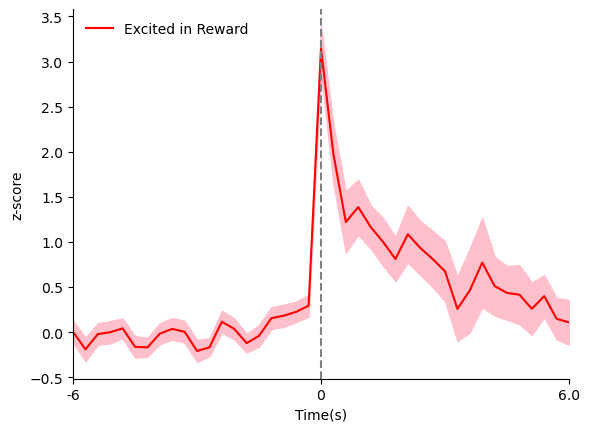

In [50]:
x=np.arange(Bins)
y=excited_reward_mean
err = excited_reward_sem
fig, ax = plt.subplots()
ax.plot(x, y, label = 'Excited in Reward', color = 'red')
ax.fill_between(x, y-err, y+err, color='pink')
ax.set_xlabel('Time(s)')
ax.set_ylabel('z-score')
ax.set_xticks([0,Bins_before,Bins-1])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after-0.3])
ax.set_xlim(0, Bins-1)
ax.axvline(Bins_before, color = 'grey', ls = '--')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc = 2, framealpha = 0)
len(excited_reward)

66

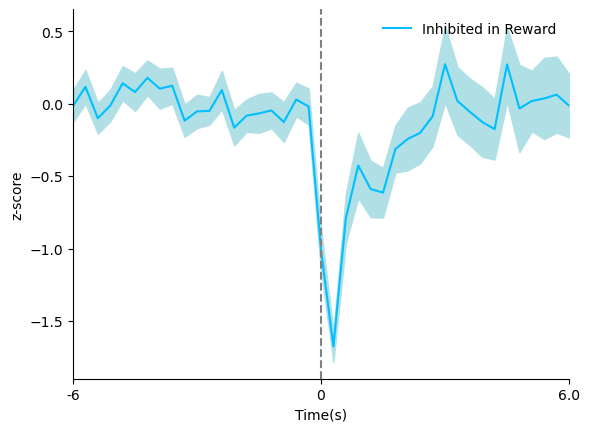

In [52]:
x=np.arange(Bins)
y=inhibited_reward_mean
err = inhibited_reward_sem
fig, ax = plt.subplots()
ax.plot(x, y, label = 'Inhibited in Reward', color = 'deepskyblue', linestyle = '-')
ax.fill_between(x, y-err, y+err, color='powderblue')
ax.set_xlabel('Time(s)')
ax.set_ylabel('z-score')
ax.set_xticks([0,Bins_before,Bins-1])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after-0.3])
ax.set_xlim(0, Bins-1)
# ax.set_ylim(-,1)
ax.axvline(Bins_before, color = 'grey', ls = '--')
ax.legend(loc = 0, framealpha = 0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
len(inhibited_reward)

In [53]:
def calculate_perievent_firing_rates(spike_timestamps, events_timestamps, XMin, XMax, Bin, normalization='Counts/Bin'):
    # Number of bins
    num_bins = int(np.ceil((XMax - XMin) / Bin))
    bin_edges = np.linspace(XMin, XMax, num_bins + 1)
    bin_counts = np.zeros(num_bins)

    # Iterate over each reference event
    for ref in events_timestamps:
        # Calculate distances and filter out-of-range spikes
        distances = spike_timestamps - ref
        distances = distances[(distances >= XMin) & (distances < XMax)]

        # Use numpy histogram to count spikes in bins
        counts, _ = np.histogram(distances, bins=bin_edges)
        bin_counts += counts

    # Normalize if required
    if normalization == 'Spikes/Sec':
        bin_counts = bin_counts / (len(events_timestamps) * Bin)

    return bin_counts

def calculate_neuron_firing_rates_random(neuron_id, neuron_data, interval_data, XMin, XMax, Bin, cue_range, normalization='Counts/Bin', seed = 1989):
    random.seed(seed)
    spike_timestamps = neuron_data[neuron_id]
    animal_id = neuron_id[0]  # Assuming the first element of the tuple is the animal ID
    events_timestamps = interval_data[animal_id][cue_range[0]:cue_range[1]].to_numpy()
    potential_numbers = list(np.arange(events_timestamps[0] - 10, events_timestamps[-1] + 10, 6.3))
    events_timestamps_random = np.array(sorted(random.sample(potential_numbers, len(events_timestamps))))

    firing_rates = calculate_perievent_firing_rates(spike_timestamps, events_timestamps_random, XMin, XMax, Bin, normalization)
    return neuron_id, firing_rates

# Function to be executed in parallel
def process_neuron_data_random(neuron_id, neuron_data, interval_data, XMin, XMax, Bin, cue_range, normalization):
    return calculate_neuron_firing_rates_random(neuron_id, neuron_data, interval_data, XMin, XMax, Bin, cue_range, normalization)


def parallel_firing_rates_calculation_random(neuron_data, interval_data, XMin, XMax, Bin, cue_range, normalization='Spikes/Sec'):
    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
    func = partial(process_neuron_data_random, neuron_data=neuron_data, interval_data=interval_data, XMin=XMin, XMax=XMax, Bin=Bin, cue_range = cue_range, normalization=normalization)
    results = pool.map(func, neuron_data.keys())
    pool.close()
    pool.join()

    # Create a DataFrame from the results
    columns = ['AnimalID', 'NeuronID'] + [f'{i}' for i in range(int(np.ceil((XMax - XMin) / Bin)))]
    data = []
    for (animal_id, neuron_id), firing_rates in results:
        row = [animal_id, neuron_id] + firing_rates.tolist()
        data.append(row)

    df = pd.DataFrame(data, columns=columns)
    return df

# Example usage
XMin = -30  # Define your XMin
XMax = 30   # Define your XMax
Bin = 0.3  # Define your Bin size
reward_cue = (0,12)

# Example call to the parallel processing function
random_firing_rates_df = parallel_firing_rates_calculation_random(neuron_data, interval_data, XMin, XMax, Bin, reward_cue)

# Display the DataFrame
print(random_firing_rates_df.head())



  AnimalID NeuronID         0         1         2         3         4  \
0      1U1   SPK01a  3.888889  3.611111  2.500000  3.888889  3.333333   
1      1U1   SPK02a  3.611111  2.500000  5.277778  5.277778  3.611111   
2      1U1   SPK08a  1.944444  2.777778  4.722222  7.500000  6.111111   
3      1U1   SPK09a  1.388889  0.833333  1.388889  0.555556  0.555556   
4      1U1   SPK12a  3.333333  3.611111  5.833333  6.388889  6.111111   

          5         6         7  ...       190       191       192       193  \
0  3.055556  2.777778  2.222222  ...  1.111111  2.222222  5.277778  3.055556   
1  5.833333  5.000000  1.666667  ...  3.333333  3.055556  3.333333  5.000000   
2  6.944444  2.500000  1.944444  ...  8.055556  2.777778  2.222222  1.944444   
3  1.111111  2.500000  1.388889  ...  1.111111  2.500000  2.500000  1.944444   
4  6.666667  3.611111  6.111111  ...  4.444444  6.111111  4.722222  5.000000   

        194       195       196       197       198       199  
0  3.055556  3.3

In [54]:
random_firing_rates_df_6s = random_firing_rates_df.iloc[:, int((-XMin-TimeRange_before)/BinSize)+2:int((XMax+TimeRange_after)/BinSize)+2]
baseline_mean = random_firing_rates_df_6s.iloc[:, 0:int(XMax/BinSize)-int((-XMin-TimeRange_before)/BinSize)].mean(axis = 1)
baseline_std = random_firing_rates_df_6s.iloc[:, 0:int(XMax/BinSize)-int((-XMin-TimeRange_before)/BinSize)].std(axis = 1)

random_zscore = random_firing_rates_df_6s.sub(baseline_mean, axis = 0).divide(baseline_std, axis = 0)

In [55]:
excited_random = random_zscore[(random_zscore.iloc[:,int(XMax/BinSize)-int((-XMin-TimeRange_before)/BinSize):int((XMax+0.6)/BinSize)-int((-XMin-TimeRange_before)/BinSize)]>1.96).any(axis =1)]
excited_random.iloc[:,20:].dropna()

100       101       102       103       104       105       106  \
33  -0.731010  2.314864 -0.121835  0.182752  2.314864  0.487340  0.182752   
40   2.067580  0.860234  0.256561  1.162070  0.256561  1.162070  1.162070   
65  -0.047616  2.618891  0.523778  2.618891 -0.238081 -0.238081  1.476102   
76   1.361519  2.853595  0.988500 -0.130557  2.480576  0.988500  0.242462   
85   1.984808 -0.445569 -0.445569 -0.445569  0.364557  0.364557  1.984808   
86   2.387467  3.183290  1.326371  1.326371 -0.530548  0.000000  0.795822   
91  -0.441771  2.369497  2.771107 -1.646600 -0.040161 -0.441771 -1.244990   
109  2.258767  0.294622  1.276695 -1.178487 -0.196415 -1.178487 -0.196415   
132  2.470336  0.640457  1.203497  1.907296 -0.204102  0.358938  0.499697   
157  3.899706 -1.115144  0.732432  2.316069  0.468493  2.184099  2.580009   
191  1.404004  2.500881  0.307126  0.745877 -1.667254 -0.789752 -2.325381   
192  3.409183  4.211344  3.409183  4.746118  1.804862 -0.869008 -1.403781   
198 -0.842598  2.748804  0.814972  1.091234 -1.947645  3.577589  1.091234   
202  2.604870  2.019506 -0.321950 -1.785360 -0.321950  0.263414  0.848778   
212 -0.398846  2.174355  2.174355  2.431675  2.174355  0.630434  0.373114   
213 -0.594395  2.179449 -1.386922  4.160767 -0.594395  0.594395  0.594395   
219  2.090454  2.454012  0.818004  2.090454  0.272668  1.181561 -0.818004   
228  2.472543  2.748804 -0.013813  1.367496  1.091234 -0.290075  1.367496   
230  2.725060 -0.255474 -0.042579  0.170316 -0.468370  1.021898  0.596107   
241  0.348991  2.442939 -0.348991 -1.046974  0.348991 -1.046974  3.140921   
243 -0.015690  2.808520 -0.015690  1.239514  0.925713  0.298111  2.494718   
247  1.866559  2.788316  0.483923  1.175241  2.096998  0.253483  1.866559   
250  0.189338  2.556069 -0.757354  2.082723 -1.704046  1.136031  1.136031   
256  2.456684 -0.272965 -0.272965 -1.637789 -0.272965  3.821508  2.456684   
258  9.421901  9.421901 -0.324893  9.421901  6.172970 -0.324893 -0.324893   
259  2.211713  1.588695  1.588695 -1.526394  2.834731  1.277186  1.900204   
280  3.392357  1.966997  2.252069  2.252069  1.966997  0.826709  1.681925   
284  2.079084  1.688646  0.517331  2.079084 -0.068327 -1.825299 -1.825299   
296  2.783477 -1.701747  3.574988  3.311151  1.464294  5.949518  0.672784   
299  2.478188  0.000000  0.000000  0.000000 -1.239094  0.309773 -0.619547   
321  2.619582  0.464230 -0.696345  1.127415 -0.862141 -1.193734 -1.359530   
322  1.971514  3.211460  1.971514 -0.012399  3.707438 -0.260389  1.475536   
354  0.370756  2.348120 -0.617926  0.370756 -0.617926  2.842461 -0.123585   
355  1.447688  2.725060 -1.107056 -1.107056 -1.107056  1.447688 -1.532846   
356 -0.220756  3.703801  0.269813  0.269813  1.250953 -0.220756 -1.692466   
359  3.694382 -0.545073 -1.756345 -1.150709 -1.150709  0.060564 -1.150709   
383  1.423738  1.982067 -0.809577 -1.926234 -1.926234 -0.809577 -0.809577   
385 -0.223607  4.248529 -0.223607 -0.223607 -0.223607 -0.223607 -0.223607   

          107       108       109  ...       111       112       113  \
33   3.228626  0.487340  1.096514  ... -0.121835 -1.644772  0.182752   
40  -0.347112  0.860234 -0.950785  ... -0.950785 -0.045275 -1.554458   
65  -0.619011  0.523778  1.666567  ...  0.523778  1.095173  1.857032   
76  -1.622633 -0.503576 -0.130557  ...  2.107557 -0.503576  1.734538   
85  -0.445569 -0.445569 -0.445569  ... -0.445569 -0.445569 -0.445569   
86  -0.530548  0.000000 -1.326371  ... -0.265274  2.918016  0.000000   
91  -0.843380  1.566278  1.164668  ... -0.441771 -0.843380 -0.040161   
109 -1.178487 -0.196415 -0.687451  ... -0.196415 -1.178487  0.294622   
132 -0.063342 -0.344862 -0.063342  ...  0.499697 -0.626381  0.781217   
157  0.072583  2.711978  0.204553  ...  0.072583 -0.323326 -2.170902   
191 -0.789752  0.087750 -1.228503  ... -0.570376 -1.228503 -1.667254   
192 -0.066847  0.735314  0.467927  ... -0.334234 -0.869008 -0.601621   
198  0.262449 -0.013813 -0.842598  ... -1.395122 -1.671383  1.920019  

In [56]:
inhibited_random = random_zscore[(random_zscore.iloc[:,int(XMax/BinSize)-int((-XMin-TimeRange_before)/BinSize):int((XMax+0.6)/BinSize)-int((-XMin-TimeRange_before)/BinSize)]<-1.65).any(axis =1)]
inhibited_random.iloc[:,20:].dropna()

100       101       102       103       104       105       106  \
57  -1.194977 -1.959762 -1.003781  3.011342  2.820146 -0.047799  2.055361   
66  -2.078024 -0.415605  0.415605  0.623407 -1.454616  0.207802 -1.246814   
73  -1.976932  0.104049  0.624294 -1.196564 -1.196564 -0.156074 -0.676319   
99  -2.811268 -1.072339 -1.072339 -1.072339  1.246232 -0.492696  0.086946   
108 -0.161330 -1.774631 -1.774631 -0.967981  0.376437 -0.699097 -0.161330   
128 -0.833532 -2.262445 -0.357228  1.547989 -0.833532  1.547989 -1.309836   
135  0.059062 -1.909686  1.634061  2.027811 -0.334687 -0.334687  1.240311   
150 -1.677852  0.636427 -1.214996  1.214996  0.057857 -0.520713 -0.404999   
204  0.035205 -2.605178 -1.020948 -2.253127  0.387256  2.147512  0.387256   
210 -2.008087 -1.311641 -0.150897 -1.079492 -0.150897  0.081252 -0.150897   
254 -1.928129 -1.159950 -1.159950 -0.852679 -0.391771  0.530043  0.990951   
257  1.756345 -1.877473  1.150709 -0.666200 -0.060564  4.178891  1.756345   
260 -3.061846 -1.659474  0.210356  2.313914 -0.490830  0.444084  1.145271   
261 -2.538864 -1.658333  1.570280 -0.777802  1.276770 -0.484292 -1.364823   
266 -1.721586  0.593151 -1.721586 -0.564217 -0.853559  0.014467  0.593151   
267 -1.489369 -2.460696 -2.028995  0.237436 -1.489369  0.669137  1.532539   
283 -0.353665 -1.950861 -0.581836 -0.810006  1.243531  1.699873 -1.038177   
296  2.783477 -1.701747  3.574988  3.311151  1.464294  5.949518  0.672784   
325  1.484280 -1.798262 -0.371070 -0.799228  0.057088 -1.512824 -1.084666   
328 -1.851640 -0.982325  0.756304  0.060852  1.973344  3.190384  0.060852   
336 -0.529025 -2.084981 -0.217834 -0.840216 -1.151407  0.404549  1.338122   
342 -2.015864 -0.740001 -0.612414  0.663449 -0.102069 -0.867587  0.153104   
344 -2.265228  0.327962 -0.129659  1.548287 -1.044903 -0.587281  0.785584   
377 -2.025114 -1.332768  0.051926 -0.986594 -1.332768  2.821313  2.821313   
404 -1.789447  0.416720 -0.073539 -1.299187 -1.054058 -1.054058 -0.318669   

          107       108       109  ...       111       112       113  \
57  -0.430192 -0.621388 -1.386173  ... -0.430192  0.143397 -0.430192   
66   0.623407  1.870221  1.039012  ...  1.870221  0.207802 -1.246814   
73   0.364172 -0.676319 -0.416196  ... -2.497178  0.104049 -1.196564   
99  -1.072339 -0.492696 -0.492696  ...  0.086946 -1.072339  0.666589   
108 -0.967981 -0.430214 -0.967981  ... -2.043514  0.107553 -0.967981   
128 -0.833532 -0.357228  2.976901  ... -1.309836 -0.357228  1.547989   
135  0.452812  0.059062  0.452812  ...  0.846562  0.059062  0.452812   
150 -1.099282  0.752140  1.330710  ...  0.289285  1.214996 -0.404999   
204 -1.196974 -0.316846 -0.140820  ... -0.844923 -0.668897  1.619435   
210 -1.543790 -0.615194  0.313401  ... -0.615194  0.777698  1.241996   
254 -0.391771 -2.389036 -0.545407  ... -0.084500 -1.467222 -0.699043   
257  4.784527 -1.271836  0.545073  ... -0.060564  0.545073 -0.060564   
260 -0.958288 -0.958288 -1.192016  ... -1.425745 -0.958288 -0.490830   
261  0.396239  0.102729  2.157300  ...  0.102729 -1.071312 -0.484292   
266  0.303809 -0.274875 -1.432244  ... -0.274875 -0.853559 -1.142901   
267  1.316688  1.316688 -2.136921  ... -1.705219 -0.410116  0.237436   
283 -1.950861 -1.494519 -1.494519  ... -0.581836 -1.266348 -0.125494   
296  0.672784  4.102661  4.102661  ...  4.366498  4.894171  3.047314   
325 -0.656509 -0.228351 -0.228351  ... -0.941947 -1.227385 -1.512824   
328 -0.982325  1.625618  1.104029  ... -1.330051 -0.982325 -0.286874   
336  2.582887  1.026931 -0.840216  ... -1.151407 -0.217834  0.093357   
342 -0.484828 -0.102069  1.301381  ...  1.428967  1.173794 -1.122760   
344 -1.502525 -0.434741  0.022881  ... -1.655065 -1.197444  0.175422   
377 -0.640421 -0.640421 -1.332768  ... -0.640421 -0.294247  1.090446   
404 -0.563798 -0.073539 -0.808928  ... -0.808928  0.906980 -1.299187   

          114       115       116       117       118       119       120  
57  -1.768566  0.716986 -0.812584  0.143397 -2.150959 -1.3

In [57]:
cue_range= reward_cue
random.seed(1989)
events_timestamps = interval_data['1U1'][cue_range[0]:cue_range[1]].to_numpy()
# Calculate range for random number generation
start_range = events_timestamps[0] - 10
end_range = events_timestamps[-1] + 10

potential_numbers = list(np.arange(events_timestamps[0] - 10, events_timestamps[-1] + 10, 6.3))
events_timestamps_random = np.array(sorted(random.sample(potential_numbers, len(events_timestamps))))

events_timestamps_random

array([198.13845, 242.23845, 311.53845, 336.73845, 456.43845, 525.73845,
       550.93845, 563.53845, 676.93845, 689.53845, 771.43845, 784.03845])

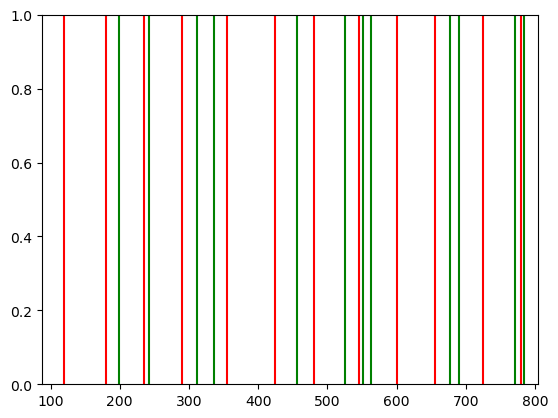

In [58]:
for i in range(len(events_timestamps)):
    plt.axvline(events_timestamps[i], c = 'r')
    plt.axvline(events_timestamps_random[i], c = 'g')

In [59]:
excited_random_indices = excited_random.index.values
inhibited_random_indices = inhibited_random.index.values
excited_random_mean = excited_random.mean(axis=0).astype('float')
excited_random_sem = excited_random.sem(axis=0).astype('float')
inhibited_random_mean = inhibited_random.mean(axis=0).astype('float')
inhibited_random_sem = inhibited_random.sem(axis=0).astype('float')

In [60]:
total_cells = len(reward_cue_zscore)

# Calculate percentages
percent_excited_random = len(excited_random_indices) / total_cells * 100
percent_inhibited_random = len(inhibited_random_indices) / total_cells * 100

# Assuming excited_indices contains the indices for excited cells from the original trace_hungry DataFrame
percent_excited = len(excited_reward_indices) / total_cells * 100
percent_inhibited = len(inhibited_reward_indices) / total_cells * 100

# Find the intersection (cells that are in both excited_indices_30s and excited_indices)
common_excited_indices = set(excited_random_indices).intersection(set(excited_reward_indices))
percent_common_excited = len(common_excited_indices) / total_cells * 100

common_inhibited_indices = set(inhibited_random_indices).intersection(set(inhibited_reward_indices))
percent_common_inhibited = len(common_inhibited_indices) / total_cells * 100

excited_inhibitedrandom_indices = set(excited_reward_indices).intersection(set(inhibited_random_indices))
percent_excited_inhibitedrandom = len(excited_inhibitedrandom_indices) / total_cells * 100

inhibited_excitedrandom_indices = set(inhibited_reward_indices).intersection(set(excited_random_indices))
percent_inhibited_excitedrandom = len(inhibited_excitedrandom_indices) / total_cells * 100

# Printing the results
print(f"Percentage of excited cells (random): {percent_excited_random:.2f}%")
print(f"Percentage of inhibited cells (random): {percent_inhibited_random:.2f}%")
print(f"Percentage of excited cells: {percent_excited:.2f}%")
print(f"Percentage of inhibited cells: {percent_inhibited:.2f}%")
print(f"Percentage of cells excited in both cases: {percent_common_excited:.2f}%")
print(f"Percentage of cells inhibited in both cases: {percent_common_inhibited:.2f}%")
print(f"Percentage of cells excited in hungry cues and inhibited random: {percent_excited_inhibitedrandom:.2f}%")
print(f"Percentage of cells inhibited in hungry cues and excited random: {percent_inhibited_excitedrandom:.2f}%")


Percentage of excited cells (random): 9.20%
Percentage of inhibited cells (random): 6.05%
Percentage of excited cells: 16.46%
Percentage of inhibited cells: 15.98%
Percentage of cells excited in both cases: 1.45%
Percentage of cells inhibited in both cases: 1.21%
Percentage of cells excited in hungry cues and inhibited random: 0.73%
Percentage of cells inhibited in hungry cues and excited random: 1.69%


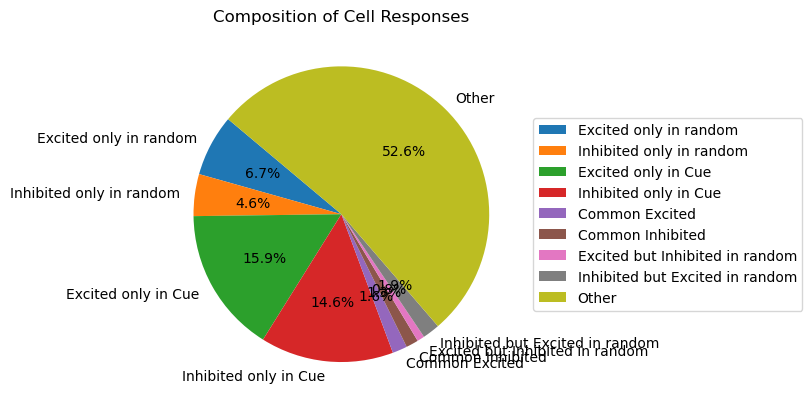

In [63]:


# Calculate the count of cells not in any of the above categories
other_percent = 100 - (percent_excited_random + percent_inhibited_random + percent_excited + percent_inhibited + percent_common_excited + percent_common_inhibited + percent_excited_inhibitedrandom + percent_inhibited_excitedrandom)

# Calculate percentages
percentages = {
    "Excited only in random":  percent_excited_random - percent_common_excited - percent_inhibited_excitedrandom,
    "Inhibited only in random": percent_inhibited_random- percent_common_inhibited - percent_excited_inhibitedrandom,
    "Excited only in Cue": percent_excited - percent_common_excited - percent_excited_inhibitedrandom,
    "Inhibited only in Cue": percent_inhibited -percent_common_inhibited- percent_inhibited_excitedrandom,
    "Common Excited": percent_common_excited,
    "Common Inhibited": percent_common_inhibited,
    "Excited but Inhibited in random": percent_excited_inhibitedrandom,
    "Inhibited but Excited in random": percent_inhibited_excitedrandom,
    "Other": other_percent
}

# Code to create a pie chart
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(percentages.values(), labels=percentages.keys(), autopct='%1.1f%%', startangle=140)

# Draw a legend with some space around each entry
ax.legend(wedges, percentages.keys(), loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.set_title('Composition of Cell Responses')
plt.show()


In [2]:
sns.set_style('ticks')
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.labelspacing'] = 0.2
mpl.rcParams['axes.labelpad'] = 2
mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['ytick.major.pad'] = 1
mpl.rcParams['lines.scale_dashes'] = False
mpl.rcParams['lines.dashed_pattern'] = (2, 1)
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['text.color'] = 'k'

In [3]:
import psutil

total_ram = psutil.virtual_memory().total
print(f"Total RAM available: {total_ram / (1024 * 1024 * 1024)} GB")
import multiprocessing
print("Number of CPU cores:", multiprocessing.cpu_count())


Total RAM available: 251.2343521118164 GB
Number of CPU cores: 128


## General functions

In [4]:
def standardize_plot_graphics(ax):
    [i.set_linewidth(0.5) for i in ax.spines.values()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax

def fit_regression(x, y):
    lm = sm.OLS(y, sm.add_constant(x)).fit()
    x_range = sm.add_constant(np.array([x.min(), x.max()]))
    x_range_pred = lm.predict(x_range)
    return lm.pvalues[1], lm.params[1], x_range[:,1], x_range_pred, lm.rsquared

def CDFplot(x, ax, **kwargs):
    x = np.array(x)
    ix=np.argsort(x)
    ax.plot(x[ix], ECDF(x)(x)[ix], **kwargs)
    return ax

def fit_regression_and_plot(x, y, ax, plot_label='', color='k', linecolor='r', markersize=3,
                            show_pval=True):
    #linetype is a string like 'bo'
    pvalue, slope, temp, temppred, R2 = fit_regression(x, y)   
    if show_pval:
        plot_label = '%s p=%.2e\nr=%.3f'% (plot_label, pvalue, np.sign(slope)*np.sqrt(R2))
    else:
        plot_label = '%s r=%.3f'% (plot_label, np.sign(slope)*np.sqrt(R2))
    ax.scatter(x, y, color=color, label=plot_label, s=markersize)
    ax.plot(temp, temppred, color=linecolor)
    return ax, slope, pvalue, R2

In [4]:
base_dir = "./Data"

databin = 0.01
BinSize = 0.3


In [3]:
# Load the csv files for each animal into a dictionary

files = os.listdir(base_dir)

csv_files = [file for file in files if (file.endswith('.csv')) & (file[0].isdigit())]

animal_ids = []
for csv_file in csv_files:
    if csv_file[:2].isdigit():
        animal_id = csv_file[:4]
    else:
        animal_id = csv_file[:3]
    animal_ids.append(animal_id) 

In [4]:
len(animal_ids)

30

# Data preprocess with Ephys data (only run this first time)

### Load the csv files for each animal into a dictionary
animal_data = {}
for xlsx_file, animal_id in zip(csv_files, animal_ids):
    filename = os.path.join(base_dir, xlsx_file)
    animal_data[animal_id] = pd.read_csv(filename)

with open('animal_data.pkl', 'wb') as f:
    pickle.dump(animal_data, f)

In [5]:
with open('animal_data.pkl', 'rb') as f:
    animal_data = pickle.load(f)

In [10]:
# Load the csv file with cross timepoints
interval_data = pd.read_csv(os.path.join(base_dir,"Trial by Trial Cues.csv"), header = 1)
photoid = pd.read_csv(os.path.join(base_dir,"Phototag ID's.csv"), index_col =0)

In [11]:
total_columns = 0

for key, df in animal_data.items():
    total_columns += df.shape[1]
total_columns-len(animal_data)

413

In [12]:
photo_animals = [ids for ids in photoid.columns if ids[0].isdigit()]

In [13]:
def unmatched_elements(array1, array2):
    set1 = set(array1)
    set2 = set(array2)
    return list(set1.difference(set2)) + list(set2.difference(set1))
unmatched_elements(animal_ids, photo_animals)

[]

In [14]:
photoid.index = ["Unit", "PL GABA", "PL-PVT", "PL-NAc"]

In [15]:
photoid

1U1 Unnamed: 2 Unnamed: 3 Unnamed: 4 Unnamed: 5 Unnamed: 6  \
Unit     SPK01a     SPK02a     SPK08a     SPK09a     SPK12a     SPK24a   
PL GABA       0          0          0          0          0          0   
PL-PVT        0          0          0          0          0          0   
PL-NAc        0          0          0          0          0          0   

        Unnamed: 7 Unnamed: 8     9L1 Unnamed: 10  ... Unnamed: 404     1D6  \
Unit        SPK25a     SPK26a  SPK23a      SPK26a  ...       SPK30a  SPK02a   
PL GABA          0          0       0           0  ...            0       0   
PL-PVT           0          0       0           0  ...            0       0   
PL-NAc           0          0       0           0  ...            1       0   

        Unnamed: 406 Unnamed: 407 Unnamed: 408 Unnamed: 409 Unnamed: 410  \
Unit          SPK03a       SPK06a       SPK13a       SPK14a       SPK16a   
PL GABA            0            0            0            0            0   
PL-PVT             0            0            0            0            0   
PL-NAc             1            0            1            0            1   

        Unnamed: 411 Unnamed: 412 Unnamed: 413  
Unit          SPK21a       SPK29a       SPK30a  
PL GABA            0            0            0  
PL-PVT             0            0            0  
PL-NAc             0            1            1  

[4 rows x 413 columns]

In [16]:
PhotoTag = pd.DataFrame(columns=['Animal_ID', 'Unit_id', 'Unit_Type'])

photoid = photoid.reset_index()
# Iterate over the columns in the input DataFrame
current_animal_id = None
for col in photoid.columns[1:]:
    if 'Unnamed' not in col:
        current_animal_id = col
    for row_idx in range(1, photoid.shape[0]):
        unit_id = photoid.loc[0, col]
        unit_type = photoid.loc[row_idx, 'index']
        value = photoid.loc[row_idx, col]

        if value == "1":
            new_row = pd.DataFrame({'Animal_ID': [current_animal_id], 'Unit_id': [unit_id], 'Unit_Type': [unit_type]})
            PhotoTag = pd.concat([PhotoTag, new_row], ignore_index=True)

    # Check if the current column has all 0s
    if pd.to_numeric(photoid.loc[1:, col], errors='coerce').sum() == 0:
        new_row = pd.DataFrame({'Animal_ID': [current_animal_id], 'Unit_id': [unit_id], 'Unit_Type': ['Unidentified']})
        PhotoTag = pd.concat([PhotoTag, new_row], ignore_index=True)


In [17]:
PhotoTag

Animal_ID Unit_id     Unit_Type
0         1U1  SPK01a  Unidentified
1         1U1  SPK02a  Unidentified
2         1U1  SPK08a  Unidentified
3         1U1  SPK09a  Unidentified
4         1U1  SPK12a  Unidentified
..        ...     ...           ...
408       1D6  SPK14a  Unidentified
409       1D6  SPK16a        PL-NAc
410       1D6  SPK21a  Unidentified
411       1D6  SPK29a        PL-NAc
412       1D6  SPK30a        PL-NAc

[413 rows x 3 columns]

In [18]:
PhotoTag.to_csv('PhotoTags.csv')

In [17]:
# Initialize an empty DataFrame to store the results
constructed_all_cells = pd.DataFrame(columns=['Animal_ID', 'Unit_id'])

# Loop through the animal_data_dict dictionary
for animal_id, animal_df in animal_data.items():
    
    # Get the Unit_ids from the column names (2nd to last)
    unit_ids = animal_df.columns[1:]
    
    # Create a new DataFrame with the Animal_ID and Unit_id information
    new_rows = pd.DataFrame({'Animal_ID': [animal_id] * len(unit_ids), 'Unit_id': unit_ids})
    
    # Append the new_rows to the constructed_all_cells DataFrame
    constructed_all_cells = pd.concat([constructed_all_cells, new_rows], ignore_index=True)

# Display the constructed_all_cells DataFrame
print(constructed_all_cells)


    Animal_ID Unit_id
0         3P4  SPK04a
1         3P4  SPK07a
2         3P4  SPK07b
3         3P4  SPK08a
4         3P4  SPK09a
..        ...     ...
408       5A4  SPK28a
409       5A4  SPK30a
410       5U5  SPK20a
411       5U5  SPK28a
412       5U5  SPK28b

[413 rows x 2 columns]


In [18]:
constructed_all_cells

Animal_ID Unit_id
0         3P4  SPK04a
1         3P4  SPK07a
2         3P4  SPK07b
3         3P4  SPK08a
4         3P4  SPK09a
..        ...     ...
408       5A4  SPK28a
409       5A4  SPK30a
410       5U5  SPK20a
411       5U5  SPK28a
412       5U5  SPK28b

[413 rows x 2 columns]

In [19]:
PhotoTag

Animal_ID Unit_id     Unit_Type
0         1U1  SPK01a  Unidentified
1         1U1  SPK02a  Unidentified
2         1U1  SPK08a  Unidentified
3         1U1  SPK09a  Unidentified
4         1U1  SPK12a  Unidentified
..        ...     ...           ...
408       1D6  SPK14a  Unidentified
409       1D6  SPK16a        PL-NAc
410       1D6  SPK21a  Unidentified
411       1D6  SPK29a        PL-NAc
412       1D6  SPK30a        PL-NAc

[413 rows x 3 columns]

In [20]:

merged_df = PhotoTag.merge(constructed_all_cells, on=['Animal_ID', 'Unit_id'], how='outer', indicator=True)
non_matching_rows = merged_df[merged_df['_merge'] != 'both']
non_matching_rows

Empty DataFrame
Columns: [Animal_ID, Unit_id, Unit_Type, _merge]
Index: []

In [21]:
# Merge the DataFrames on 'Animal_ID' and 'Unit_id'
merged_df = PhotoTag.merge(constructed_all_cells, on=['Animal_ID', 'Unit_id'], how='outer', indicator=True)

# Find the duplicate matches
duplicate_matches = merged_df[merged_df.duplicated(['Animal_ID', 'Unit_id'], keep=False)]

# Find the missing matches
missing_matches_left = merged_df[merged_df['_merge'] == 'left_only']
missing_matches_right = merged_df[merged_df['_merge'] == 'right_only']

# Display the results
print("Duplicate matches:")
print(duplicate_matches)

print("\nMissing matches in PhotoTag:")
print(missing_matches_left)

print("\nMissing matches in all_cells:")
print(missing_matches_right)



Duplicate matches:
Empty DataFrame
Columns: [Animal_ID, Unit_id, Unit_Type, _merge]
Index: []

Missing matches in PhotoTag:
Empty DataFrame
Columns: [Animal_ID, Unit_id, Unit_Type, _merge]
Index: []

Missing matches in all_cells:
Empty DataFrame
Columns: [Animal_ID, Unit_id, Unit_Type, _merge]
Index: []


In [22]:
animal_data

{'3P4':         Bin Left  SPK04a  SPK07a  SPK07b  SPK08a  SPK09a  SPK10a  SPK10b  \
 0           0.00       0       0       0       0       0       0       0   
 1           0.01       0       0       0       0       0       0       0   
 2           0.02       0       0       0       0       0       0       0   
 3           0.03       0       0       0       0       0       0       0   
 4           0.04       0       0       0       0       0       0       0   
 ...          ...     ...     ...     ...     ...     ...     ...     ...   
 335995   3359.95       0       0       0       0       0       0       0   
 335996   3359.96       0       0       0       0       0       0       0   
 335997   3359.97       0       0     100       0       0       0       0   
 335998   3359.98       0       0     200       0       0       0       0   
 335999   3359.99       0       0       0       0       0       0       0   
 
         SPK11a  SPK11b  ...  SPK17a  SPK22a  SPK24a  SPK24b  SPK27

## FR from -30s to 30s

In [39]:
databin = 0.01
BinSize = 0.3
TimeRange_before = 30
TimeRange_after = 30
TimeRange = TimeRange_before+ TimeRange_after
CompareRange_base = 6
CompareRange_after = 6.3

FrameRange_before = int(TimeRange_before/databin)
FrameRange_after = int(TimeRange_after/databin)
TotalFrame = int(FrameRange_before+FrameRange_after)
Bins = int(TotalFrame/int(BinSize/databin))
Bins_before = int(FrameRange_before/int(BinSize/databin))
# Bins_cueend = Bins_before+int(FR*Cueduration/BinSize)
TotalBins = int(TimeRange/BinSize)

In [40]:
# animal_id, animal_data, interval_data, TimeRange, databin, TotalBins = args

animal_dt = animal_data['1U1']

# Extract unit IDs from the first row
unit_ids = animal_dt.iloc[0].index[1:].tolist()
animalids = np.repeat(animal_id, len(unit_ids))

# Interval for each session of the current animal
re_interval = interval_data[animal_id][0:12]
cn_interval = interval_data[animal_id][12:36]


# Extract and normalize the trace 
trace = animal_dt.iloc[:,1:].T
#trace = trace.sub(trace.mean(axis=1), axis =0).divide(trace.std(axis=1),axis=0)

# re = process_intervals(re_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)
# cn = process_intervals(cn_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)

start = re_interval - TimeRange_before
startidx = np.searchsorted(animal_dt["Bin Left"], start, side='left')
endidx = startidx + round(TimeRange / databin)

n_bins = int(TimeRange / databin)
tracenew = pd.DataFrame(0, index=trace.index, columns=np.arange(n_bins))


for i in range(int(TimeRange/databin)):
    tracenew.iloc[:,i] = trace.iloc[:,startidx+i].mean(axis=1)

tracebin = tracenew.groupby(pd.cut(tracenew.columns, TotalBins), axis=1).mean()
tracebin.columns = np.arange(0, TotalBins)

# #epsilon = 1e-10  # Add this small constant to the denominator to avoid division by zero

# trace_mean = tracebin.iloc[:, 0:int((TotalBins / 2))].mean(axis=1).replace(np.nan, 0)
# trace_std = tracebin.iloc[:, 0:int((TotalBins / 2))].std(axis=1).replace(np.nan, 0) #+ epsilon

# tracezscore = tracebin.sub(trace_mean, axis=0).divide(trace_std, axis=0)
# tracezscore.insert(0, "Animal_ID", animalids)
# tracezscore = tracezscore.reset_index().rename(columns={'index': 'Unit_id'})



In [41]:
tracebin

0         1         2         3         4         5         6    \
SPK01a  4.444444  3.333333  3.611111  1.944444  3.055556  2.500000  1.666667   
SPK02a  5.277778  5.555556  2.222222  5.000000  6.388889  5.000000  4.444444   
SPK08a  1.666667  1.111111  1.666667  3.055556  1.666667  2.500000  2.777778   
SPK09a  1.388889  0.555556  1.111111  1.111111  0.555556  2.500000  2.222222   
SPK12a  8.888889  5.000000  7.500000  6.666667  6.388889  8.333333  9.722222   
SPK24a  4.722222  5.555556  7.222222  6.666667  7.500000  9.722222  6.388889   
SPK25a  2.777778  1.944444  2.222222  1.944444  3.055556  2.500000  2.500000   
SPK26a  3.333333  4.722222  1.388889  3.333333  2.500000  2.222222  2.500000   

              7         8          9    ...       190       191       192  \
SPK01a   3.055556  3.333333   2.222222  ...  2.777778  2.500000  2.222222   
SPK02a   5.277778  5.277778   4.166667  ...  6.388889  5.000000  4.166667   
SPK08a   2.222222  3.055556   3.333333  ...  3.055556  4.722222  2.777778   
SPK09a   1.944444  1.944444   0.833333  ...  1.944444  2.500000  0.555556   
SPK12a   5.277778  5.277778   5.833333  ...  6.388889  4.444444  7.222222   
SPK24a  10.000000  8.611111  10.000000  ...  6.666667  9.166667  8.611111   
SPK25a   3.333333  2.222222   1.388889  ...  2.222222  2.500000  1.666667   
SPK26a   3.611111  2.500000   4.166667  ...  2.222222  3.611111  3.888889   

             193       194       195       196       197       198       199  
SPK01a  3.055556  1.388889  2.222222  1.111111  3.611111  3.333333  3.611111  
SPK02a  7.500000  3.611111  5.833333  5.000000  6.388889  5.000000  4.166667  
SPK08a  3.055556  3.055556  2.222222  3.333333  3.333333  3.055556  3.055556  
SPK09a  1.944444  1.111111  0.833333  0.555556  1.666667  0.277778  0.555556  
SPK12a  7.500000  4.722222  5.555556  4.444444  4.444444  5.000000  7.500000  
SPK24a  8.333333  8.888889  9.444444  8.055556  7.500000  8.888889  5.555556  
SPK25a  1.666667  2.222222  1.388889  0.833333  2.222222  3.333333  2.222222  
SPK26a  1.944444  3.055556  3.611111  3.333333  3.888889  4.166667  4.444444  

[8 rows x 200 columns]

In [36]:
endidx

array([14989, 20989, 26494, 31994, 38494, 45491, 50994, 57494, 62994,
       68493, 75494, 80992])

In [29]:
animal_dt["Bin Left"][startidx[0]]

89.89

In [27]:
re_interval

0     119.888325
1     179.888375
2     234.938725
3     289.939250
4     354.938100
5     424.905300
6     479.939125
7     544.939225
8     599.938750
9     654.925925
10    724.939575
11    779.916225
Name: 5U5, dtype: float64

In [37]:
%%time
def process_intervals(interval_data, TimeRange, trace, animal_dt, animalids, databin, TotalBins):
    start = interval_data - 0.5 * TimeRange
    startidx = np.searchsorted(animal_dt["Bin Left"], start, side='left')
    endidx = startidx + int(TimeRange / databin)
    
    n_bins = int(TimeRange / databin)
    tracenew = pd.DataFrame(0, index=trace.index, columns=np.arange(n_bins))

        
    for i in range(int(TimeRange/databin)):
        tracenew.iloc[:,i] = trace.iloc[:,startidx+i].mean(axis=1)

    tracebin = tracenew.groupby(pd.cut(tracenew.columns, TotalBins), axis=1).mean()
    tracebin.columns = np.arange(0, TotalBins)
    
    #epsilon = 1e-10  # Add this small constant to the denominator to avoid division by zero
    
    trace_mean = tracebin.iloc[:, 0:int((TotalBins / 2))].mean(axis=1).replace(np.nan, 0)
    trace_std = tracebin.iloc[:, 0:int((TotalBins / 2))].std(axis=1).replace(np.nan, 0) #+ epsilon
    
    tracezscore = tracebin.sub(trace_mean, axis=0).divide(trace_std, axis=0)
    tracezscore.insert(0, "Animal_ID", animalids)
    tracezscore = tracezscore.reset_index().rename(columns={'index': 'Unit_id'})

    return tracezscore

def process_animal(args):
    animal_id, animal_data, interval_data, TimeRange, databin, TotalBins = args

    animal_dt = animal_data[animal_id]

    # Extract unit IDs from the first row
    unit_ids = animal_dt.iloc[0].index[1:].tolist()
    animalids = np.repeat(animal_id, len(unit_ids))

    # Interval for each session of the current animal
    re_interval = interval_data[animal_id][0:12]
    cn_interval = interval_data[animal_id][12:36]
    

    # Extract and normalize the trace 
    trace = animal_dt.iloc[:,1:].T
    #trace = trace.sub(trace.mean(axis=1), axis =0).divide(trace.std(axis=1),axis=0)
    
    re = process_intervals(re_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)
    cn = process_intervals(cn_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)

    return re, cn

def main():

    # Prepare the arguments for each animal
    args_list = [(animal_id, animal_data, interval_data, TimeRange, databin, TotalBins) for animal_id in animal_ids]

    # Create a ProcessPoolExecutor to execute the function in parallel
    with ProcessPoolExecutor(max_workers=32) as executor:
        results = list(executor.map(process_animal, args_list))

    # Initialize dataframes for final results
    Reward = pd.DataFrame()
    Conflict = pd.DataFrame()

    # Combine the results
    for res in results:
        re, cn = res
        Reward = pd.concat([Reward, re], axis=0, ignore_index = True)
        Conflict = pd.concat([Conflict, cn], ignore_index = True)

#     # Save the final results to .csv files
#     Reward.to_csv('Reward_6s_z_6s.csv', index=False)
#     Conflict.to_csv('Conflict_6s_z_6s.csv', index=False)
   
    return Reward, Reward

if __name__ == "__main__":
    Reward_6s_z_6s, Conflict_6s_z_6s = main()


100

### 6s before and after normalized to 6s before

In [317]:
TimeRange = 12.3
TotalBins = int(TimeRange/BinSize)

In [318]:
TimeRange/databin

1230.0

In [319]:
%%time
def process_intervals(interval_data, TimeRange, trace, animal_dt, animalids, databin, TotalBins):
    start = interval_data - 0.5 * TimeRange
    startidx = np.searchsorted(animal_dt["Bin Left"], start, side='right')
    endidx = startidx + int(TimeRange / databin)
    
    n_bins = int(TimeRange / databin)
    tracenew = pd.DataFrame(0, index=trace.index, columns=np.arange(n_bins))

        
    for i in range(int(TimeRange/databin)):
        tracenew.iloc[:,i] = trace.iloc[:,startidx+i].mean(axis=1)

    tracebin = tracenew.groupby(pd.cut(tracenew.columns, TotalBins), axis=1).mean()
    tracebin.columns = np.arange(0, TotalBins)
    
    #epsilon = 1e-10  # Add this small constant to the denominator to avoid division by zero
    
    trace_mean = tracebin.iloc[:, 0:int((TotalBins / 2))].mean(axis=1).replace(np.nan, 0)
    trace_std = tracebin.iloc[:, 0:int((TotalBins / 2))].std(axis=1).replace(np.nan, 0) #+ epsilon
    
    tracezscore = tracebin.sub(trace_mean, axis=0).divide(trace_std, axis=0)
    tracezscore.insert(0, "Animal_ID", animalids)
    tracezscore = tracezscore.reset_index().rename(columns={'index': 'Unit_id'})

    return tracezscore

def process_animal(args):
    animal_id, animal_data, interval_data, TimeRange, databin, TotalBins = args

    animal_dt = animal_data[animal_id]

    # Extract unit IDs from the first row
    unit_ids = animal_dt.iloc[0].index[1:].tolist()
    animalids = np.repeat(animal_id, len(unit_ids))

    # Interval for each session of the current animal
    re_interval = interval_data[animal_id][0:12]
    cn_interval = interval_data[animal_id][12:36]
    

    # Extract and normalize the trace 
    trace = animal_dt.iloc[:,1:].T
    #trace = trace.sub(trace.mean(axis=1), axis =0).divide(trace.std(axis=1),axis=0)
    
    re = process_intervals(re_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)
    cn = process_intervals(cn_interval, TimeRange, trace, animal_dt, animalids, databin, TotalBins)

    return re, cn

def main():

    # Prepare the arguments for each animal
    args_list = [(animal_id, animal_data, interval_data, TimeRange, databin, TotalBins) for animal_id in animal_ids]

    # Create a ProcessPoolExecutor to execute the function in parallel
    with ProcessPoolExecutor(max_workers=32) as executor:
        results = list(executor.map(process_animal, args_list))

    # Initialize dataframes for final results
    Reward = pd.DataFrame()
    Conflict = pd.DataFrame()

    # Combine the results
    for res in results:
        re, cn = res
        Reward = pd.concat([Reward, re], axis=0, ignore_index = True)
        Conflict = pd.concat([Conflict, cn], ignore_index = True)

    # Save the final results to .csv files
    Reward.to_csv('Reward_6s_z_6s.csv', index=False)
    Conflict.to_csv('Conflict_6s_z_6s.csv', index=False)
   
    return Reward, Reward

if __name__ == "__main__":
    Reward_6s_z_6s, Conflict_6s_z_6s = main()


CPU times: user 4.8 s, sys: 19.3 s, total: 24.1 s
Wall time: 37.5 s


In [320]:
Reward_6s_z_6s

Unit_id Animal_ID         0         1         2         3         4  \
0    SPK04a       3P4 -1.697246  0.469451  1.733358 -0.072223 -0.252781   
1    SPK07a       3P4 -1.529870  0.509957  0.801361 -0.364255  0.509957   
2    SPK07b       3P4 -1.449424 -1.003447 -1.003447  0.780459  0.185824   
3    SPK08a       3P4  2.190092  0.461072 -0.115268 -0.691608 -0.115268   
4    SPK09a       3P4  1.441396 -0.797666 -1.077549 -1.357431  0.601748   
..      ...       ...       ...       ...       ...       ...       ...   
408  SPK28a       5A4 -0.524421 -1.223650 -1.456726  0.640960  0.174807   
409  SPK30a       5A4  2.092338 -1.046169 -0.627702  1.464637  1.464637   
410  SPK20a       5U5  0.512371  1.942244  0.988996  0.035747  0.988996   
411  SPK28a       5U5 -0.036735  0.146938  2.351015  0.881631  1.065304   
412  SPK28b       5U5 -1.190975  1.902466  1.593122 -0.262942  0.974434   

            5         6         7  ...        31        32        33  \
0   -0.613898  0.108335 -1.516688  ...  1.733358  0.108335  1.733358   
1    1.092764 -0.072851 -0.364255  ...  0.218553 -0.364255 -0.655659   
2    1.226435  0.483141  0.334482  ... -0.111494 -1.003447 -0.854788   
3    1.037412  1.037412 -0.115268  ... -0.115268  1.613752 -0.115268   
4   -0.237900 -0.797666  1.161513  ... -0.797666 -1.917197 -1.637314   
..        ...       ...       ...  ...       ...       ...       ...   
408 -2.389031 -0.291345  0.174807  ... -1.223650 -0.291345 -0.291345   
409 -1.046169 -0.418468  0.627702  ... -0.209234  0.209234 -0.836935   
410  0.512371  0.750683 -0.917502  ... -0.679190 -0.679190  2.180557   
411  0.146938  0.514285  0.881631  ... -1.689792 -1.138773 -0.955100   
412 -0.262942 -0.881631 -0.262942  ... -1.190975  0.974434 -1.809663   

           34        35        36        37        38        39        40  
0    1.372242  0.469451  2.094474  0.288893  0.108335  0.650009  1.011125  
1    1.675572  1.384168  0.509957  0.218553  0.218553 -0.947062 -0.947062  
2   -0.260153 -0.408812 -0.111494 -0.408812  1.672412 -0.260153 -0.557471  
3   -0.115268  2.190092  1.037412  1.613752  1.037412 -0.691608  2.190092  
4   -0.797666  0.601748 -1.077549  0.041982  1.721279 -0.237900 -1.077549  
..        ...       ...       ...       ...       ...       ...       ...  
408  0.874036  1.806341 -0.058269  0.174807  0.407883  0.874036  0.640960  
409  2.092338  0.836935 -0.209234  1.464637  2.092338  1.255403 -1.464637  
410  2.657181  1.942244  0.988996  2.895493  1.227308  0.988996 -0.202565  
411 -0.036735 -0.587754 -1.322446 -1.322446 -1.138773 -0.955100 -1.506119  
412  0.046402  0.665090  0.974434  0.355746  1.593122 -0.572287 -1.500319  

[413 rows x 43 columns]

## Clustering set up

Some work is required before applying the following code to set up the data for clustering. In general, all Scikitlearn packages take data in a 2D array with samples going along the row axis and features going along the column axis. In my case, this part of the code is written to automatically loop through all the folders of data across all animals and the days of interest to pool data from all neurons recorded under a given condition. I am not including this code here since it is quite specific to my data organization. This data is assumed below to be contained in the `populationdata` variable.

I do all of the clustering on the fluorescence itself, instead of deconvolved fluorescence. This is because we found that there is significant bias in deconvolution, at least in detecting inhibition of fluorescence. For each neuron, I transformed its fluorescence into a normalized fluorescence based on the following equation

$$NF(t)=\frac{F(t)-F_{median}(t)}{F_{max}(t)-F_{min}(t)}$$

This makes the median fluorescence value be zero. For a real neuron with large calcium events, the median fluorescence will be close to baseline. Hence, baseline will be close to zero and all large calcium events will be positive numbers less than 1. The reason for such scaling is to ensure that the fluorescence across all neurons is directly comparable and plottable in a single scale. This is used purely for visualization and not for any analysis.

In my case, I define the "response features" of a neuron as the peristimulus time histogram of its normalized fluorescence (defined above) between -3 s before cues to +17 s after cue (reward is delivered 3 s after CS+). While this is a long time period, I found that there are a few neurons that show clear sustained activity difference much after the reward, into the intertrial interval. I effectively sample my fluorescence imaging at 5 Hz. So in effect, there are 20 s * 5 Hz = 100 features for each cue type. Since CS+ and CS- responses are both "response features", for any given neuron, I concatenate these 100 features side by side to obtain 200 features in total. I recorded 4813 neurons in total. So the data array is 4813 x 200 in size.

Since 200 dimensions in the feature space is actually quite large, I first reduce the dimensionality of this space by doing PCA along this axis. I then retain only the first few PCs that correspond to the dimensions explaining the most variability. I just use a simple scree plot approach for this. There are fancier ways to do this, but I found that those ways generally produced less reproducible results across animals. So I favored retaining the minimal number of relevant PCs.

**Below, the variable `populationdata` corresponds to the 4813 x 200 array, which pools all normalized PSTH fluorescence data across all neurons. We will first load this variable from the corresponding numpy file**

## 3s before and after

In [56]:
basedir = './' # folder containing code and data
Reward = pd.read_csv(os.path.join(basedir, 'Reward_3s_z_wholetrace.csv'), index_col = 0)
Conflict = pd.read_csv(os.path.join(basedir, 'Conflict_3s_z_wholetrace.csv'), index_col = 0)
reward = Reward.iloc[:,1:].to_numpy()
conflict = Conflict.iloc[:,1:].to_numpy()

TimeRange = 6
TotalBins = int(TimeRange/BinSize)

populationdata = np.concatenate([reward,conflict],axis =1)

In [57]:
populationdata.flatten().max()

1.2284232266576922

(array([9.5000e+01, 4.3790e+03, 1.0655e+04, 1.1770e+03, 1.6500e+02,
        2.8000e+01, 1.2000e+01, 4.0000e+00, 2.0000e+00, 3.0000e+00]),
 array([-0.36688373, -0.20735303, -0.04782234,  0.11170836,  0.27123905,
         0.43076975,  0.59030044,  0.74983114,  0.90936184,  1.06889253,
         1.22842323]),
 <BarContainer object of 10 artists>)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


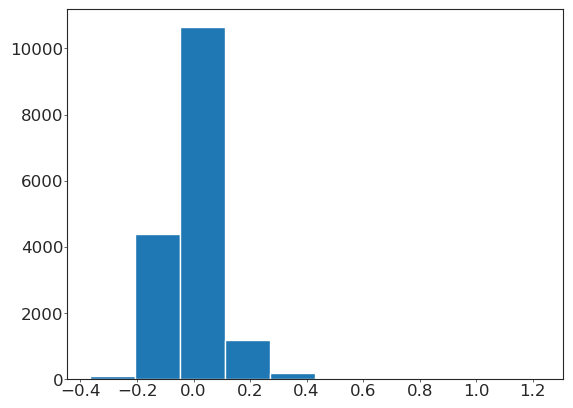

In [58]:
plt.hist(populationdata.flatten())

Now, we will visualize the full dataset to get a sense of what they look like. As mentioned previously, the first 100 features correspond to CS+ responses and the last 100 features correspond to CS- responses. So I will plot both trial types separately.

In [70]:
framerate = 1/BinSize
pre_window_size = int(0.5*TimeRange*framerate) # 3 seconds multipled by 5 frames. Corresponds to baseline prior to cues.
window_size = TotalBins # Total number of frames plotted around a cue
frames_to_reward = int(0.5*TimeRange*framerate) # 3 seconds until reward after CS+

sortwindow = [pre_window_size, pre_window_size + frames_to_reward] # Sort responses between CS+ onset and reward.
sortresponse = np.argsort(np.mean(populationdata[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
# sortresponse corresponds to an ordering of the neurons based on their average response in the sortwindow

cmax = 0.25 # Maximum colormap value. 
cmin = -0.25

trial_types = ['Reward', 'Conflict']

/tmp/ipykernel_2508084/896160079.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


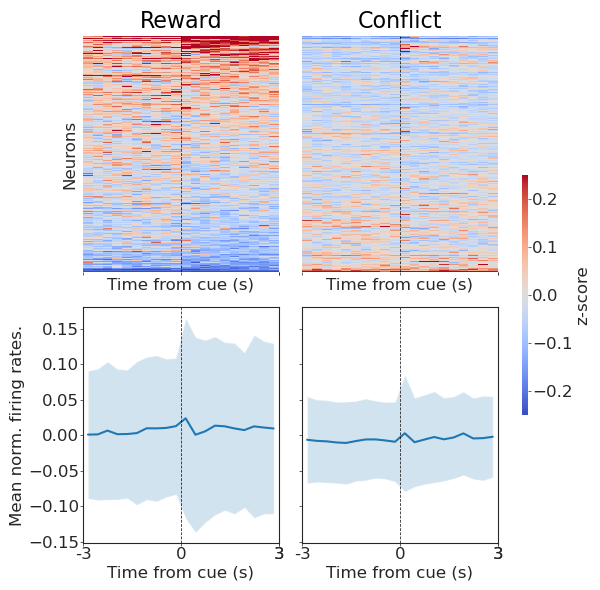

In [71]:
fig, axs = plt.subplots(2,2,figsize=(3*2,3*2), sharex='all', sharey='row')
cbar_ax = fig.add_axes([0.86, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

def tsplot(ax, data,**kw):
    x = np.arange(window_size)
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    ax.fill_between(x+0.5,cis[0],cis[1], alpha=0.2, **kw)
    ax.plot(x+0.5,est,**kw)
    ax.margins(x=0)


for t in range(len(trial_types)):
    axs[0,t].set_title(trial_types[t])
    ax = axs[0,t]
    sns.heatmap(populationdata[sortresponse, t*window_size: (t+1)*window_size],
                ax=ax,
                cmap=plt.get_cmap('coolwarm'),
                vmin=cmin,
                vmax=cmax,
                cbar=(t==0),
                cbar_ax=cbar_ax if (t==0) else None,
                cbar_kws={'label': 'z-score'})
    ax.grid(False)
    ax.tick_params(width=0.5)   
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])
    ax.set_yticks([])
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    
        
    ax = axs[1,t]
    tsplot(ax, populationdata[sortresponse, t*window_size:(t+1)*window_size])
    ax.set_xticks(np.arange(0, window_size + 1, frames_to_reward))
    ax.set_xticklabels([str(int((a - pre_window_size) / framerate)) for a in np.arange(0, window_size + 1, frames_to_reward)])

    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])

axs[0,0].set_ylabel('Neurons')
axs[1,0].set_ylabel('Mean norm. firing rates.')

fig.tight_layout()
fig.subplots_adjust(right=0.82)

Including all 200 response features per neuron makes the feature space quite large. So, let us first reduce the dimensionality of this space using Principal Component Analysis

Number of PCs = 40
Number of PCs to keep = 3


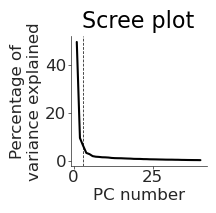

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


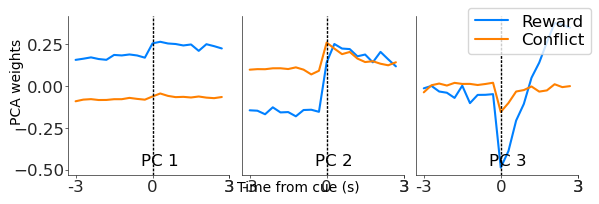

In [72]:
load_savedpca_or_dopca = 'dopca'
# Select 'dopca' for doing PCA on the data. Select 'savedpca' for loading my previous results

if load_savedpca_or_dopca == 'dopca':
    pca = PCA(n_components=populationdata.shape[1], whiten=True)
    pca.fit(populationdata) 
    with open(os.path.join(basedir, 'pcaresults.pickle'), 'wb') as f:
        pickle.dump(pca, f)
elif load_savedpca_or_dopca == 'savedpca':
    with open(os.path.join(basedir, 'OFCCaMKII_pcaresults.pickle'), 'rb') as f:
        pca = pickle.load(f)
    
transformed_data = pca.transform(populationdata)

pca_vectors = pca.components_
print ('Number of PCs = %d'%(pca_vectors.shape[0]))

x = 100*pca.explained_variance_ratio_
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
#xprime = (x - np.mean(x))/(np.max(x)-np.min(x))
num_retained_pcs = np.argmin(xprime)
# Number of PCs to be kept is defined as the number at which the 
# scree plot bends. This is done by simply bending the scree plot
# around the line joining (1, variance explained by first PC) and
# (num of PCs, variance explained by the last PC) and finding the 
# number of components just below the minimum of this rotated plot
print ('Number of PCs to keep = %d'%(num_retained_pcs))

fig, ax = plt.subplots(figsize=(2,2))
ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
ax.set_ylabel('Percentage of\nvariance explained')
ax.set_xlabel('PC number')
ax.axvline(num_retained_pcs, linestyle='--', color='k', linewidth=0.5)
ax.set_title('Scree plot')
#ax.set_xlim([0,5])
[i.set_linewidth(0.5) for i in ax.spines.values()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(top=0.9)

colors_for_key = {}
colors_for_key[trial_types[0]] = (0,0.5,1)
colors_for_key[trial_types[1]] = (1,0.5,0)

numcols = 3.0
fig, axs = plt.subplots(int(np.ceil(num_retained_pcs/numcols)), int(numcols), sharey='all',
                        figsize=(2*numcols, 2*int(np.ceil(num_retained_pcs/numcols))))
for pc in range(num_retained_pcs):
    ax = axs.flat[pc]
    for k, tempkey in enumerate(trial_types):
        ax.plot(pca_vectors[pc, k*window_size:(k+1)*window_size], color=colors_for_key[tempkey],
                label='PC %d: %s'%(pc+1, tempkey))
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=1)
    ax.annotate(text='PC %d'%(pc+1), xy=(0.45, 0.06), xytext=(0.45, 0.06), xycoords='axes fraction',
            textcoords='axes fraction', multialignment='center', size='large')
    if pc >= num_retained_pcs-numcols:
        ax.set_xticks([0, pre_window_size,
                       pre_window_size + frames_to_reward, window_size])
        ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                             for a in [0, pre_window_size,
                                       pre_window_size + frames_to_reward, window_size]])
    else:
        ax.set_xticks([])
        ax.xaxis.set_ticks_position('none')
    if pc%numcols:
        ax.yaxis.set_ticks_position('none')
    [i.set_linewidth(0.5) for i in ax.spines.values()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


fig.text(0.5, 0.05, 'Time from cue (s)', horizontalalignment='center', rotation='horizontal')
fig.text(0.02, 0.6, 'PCA weights', verticalalignment='center', rotation='vertical')
fig.tight_layout()
fig.legend(trial_types,)
for ax in axs.flat[num_retained_pcs:]:
    ax.set_visible(False)

fig.subplots_adjust(wspace=0.08, hspace=0.08)
fig.subplots_adjust(bottom=0.13)

In [73]:
transformed_data.shape

(413, 40)

## Perform clustering

Now, we have reduced the full dataset into a reduced dimensionality corresponding to the PCA subspace. 

Next, we will start the clustering. The approach we will use is Spectral Clustering. This is a pretty good method for dealing with high dimensional data. Note that even after PCA dimensionality reduction, there are 8 dimensions in this dataset. The choice of the method can affect the exact clustering results and there really is no "the best" algorithm. Thus, clustering is almost always the beginning of an investigation, rather than the end. In other words, the point of this clustering approach is not to say "There are 9 subpopulations of neurons in OFC for sure", but rather to test if these identified clusters can be mapped onto interesting features either in terms of their responses or in terms of their biological features (genes, anatomy etc).

The one issue with Spectral Clustering is that you have to pre-specify the number of clusters. However, there are ways to optimize this number by using metrics of "clusteredness". I use a common method: <a href="https://en.wikipedia.org/wiki/Silhouette_(clustering)">silhouette score</a>. The one caveat of this method you need to specify a minimum of two clusters. In my experience, when the data truly do not contain any clusters, the minimum of two clusters identified will be quite obviously similar to each other. When data visualization clearly shows that the identified "clusters" are similar in terms of responses, one should conclude that there are no clusters.

This is the fundamental issue with approaches such as clustering. In the end, there are strong subjective elements to it. However, when there truly are clusters in the data, it can be a powerful approach to uncovering such structure. In my case, I validated these identified clusters using two major approaches:

1. I found that the responses of neurons that were clustered on one day are stable on another day when the behavior is stable. Thus, the difference between clusters remains even on a cross-validation day.

2. Subpopulations of the output population studied here (e.g. OFC neurons projecting to VTA or NAc) comprise of only select clusters. This shows that specific types of responses are absent in specific downstream projections. Such a clear mapping of identified clusters to biology is a good indication that the clustering results are real.

In [75]:
max_n_clusters = 8 # Maximum number of clusters expected. I already ran this with up to 20 clusters and know
# that the optimal number is 9. So, I am leaving this at 11. In your data, might be worth increasing this, but
# it will take more time to run.

possible_n_clusters = np.arange(2, max_n_clusters+1) #This requires a minimum of 2 clusters.
# When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, 
# as the responses of the clusters will be quite similar. This will also be visible when plotting the data in
# the reduced dimensionality PC space (done below).


possible_n_nearest_neighbors = np.array([5, 50, 100, 200, 300]) #np.array([100, 500, 1000, 2000, 4000]) # This should be selected for each dataset
# appropriately. When 4813 neurons are present, the above number of nearest neighbors provides a good sweep of the
# parameter space. But it will need to be changed for other data.
    
silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    possible_n_nearest_neighbors.size))

for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
    for nnidx, nn in enumerate(possible_n_nearest_neighbors):
        model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=nn)
        model.fit(transformed_data[:,:num_retained_pcs])
        silhouette_scores[n_clustersidx, nnidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                                   model.labels_,
                                                                   metric='cosine')
        print ('Done with numclusters = %d, num nearest neighbors = %d: score = %.3f'%(n_clusters,
                                                                                      nn,
                                                                                      silhouette_scores[n_clustersidx,                                                                           
                                                                                                        nnidx]))

print ('Done with model fitting')

temp = {}
temp['possible_n_clusters'] = possible_n_clusters
temp['possible_n_nearest_neighbors'] = possible_n_nearest_neighbors
temp['silhouette_scores'] = silhouette_scores
temp['shape'] = 'cluster_nn'
with open(os.path.join(basedir, 'silhouette_scores.pickle'), 'wb') as f:
    pickle.dump(temp, f)

Done with numclusters = 2, num nearest neighbors = 5: score = 0.396
Done with numclusters = 2, num nearest neighbors = 50: score = 0.430
Done with numclusters = 2, num nearest neighbors = 100: score = 0.427
Done with numclusters = 2, num nearest neighbors = 200: score = 0.400
Done with numclusters = 2, num nearest neighbors = 300: score = 0.252
Done with numclusters = 3, num nearest neighbors = 5: score = 0.323
Done with numclusters = 3, num nearest neighbors = 50: score = 0.440
Done with numclusters = 3, num nearest neighbors = 100: score = 0.450
Done with numclusters = 3, num nearest neighbors = 200: score = 0.426
Done with numclusters = 3, num nearest neighbors = 300: score = 0.181
Done with numclusters = 4, num nearest neighbors = 5: score = 0.401
Done with numclusters = 4, num nearest neighbors = 50: score = 0.423
Done with numclusters = 4, num nearest neighbors = 100: score = 0.461
Done with numclusters = 4, num nearest neighbors = 200: score = 0.428
Done with numclusters = 4, nu

Next, we will reorder the cluster labels such that there is a fixed order for naming the clusters. This is important because if you run the previous code multiple times, it will return different orders for the cluster labels.

In [76]:
with open(os.path.join(basedir, 'silhouette_scores.pickle'), 'rb') as f:
    silhouette_scores = pickle.load(f)
    
transformed_data = transformed_data #np.load(os.path.join(basedir, 'OFCCaMKII_transformed_data.npy'))

# Identify optimal parameters from the above parameter space
temp = np.where(silhouette_scores['silhouette_scores']==np.nanmax(silhouette_scores['silhouette_scores']))
n_clusters = silhouette_scores['possible_n_clusters'][temp[0][0]]
n_nearest_neighbors = silhouette_scores['possible_n_nearest_neighbors'][temp[1][0]]

print (n_clusters, n_nearest_neighbors)

# Redo clustering with these optimal parameters
model = SpectralClustering(n_clusters=n_clusters,
                           affinity='nearest_neighbors',
                           n_neighbors=n_nearest_neighbors)

# model = KMeans(n_clusters=n_clusters)

# model = AgglomerativeClustering(n_clusters=9,
#                                 affinity='l1',
#                                 linkage='average')

model.fit(transformed_data[:,:num_retained_pcs])

temp = silhouette_score(transformed_data[:,:num_retained_pcs], model.labels_, metric='cosine')

print ('Number of clusters = %d, average silhouette = %.3f'%(len(set(model.labels_)), temp))

# Save this optimal clustering model.
# with open(os.path.join(basedir, 'clusteringmodel.pickle'), 'wb') as f:
#     pickle.dump(model, f)

          
# Since the clustering labels are arbitrary, I rename the clusters so that the first cluster will have the most
# positive response and the last cluster will have the most negative response.
def reorder_clusters(rawlabels):
    uniquelabels = list(set(rawlabels))
    responses = np.nan*np.ones((len(uniquelabels),))
    for l, label in enumerate(uniquelabels):
        responses[l] = np.mean(populationdata[rawlabels==label, pre_window_size:2*pre_window_size])
    temp = np.argsort(responses).astype(int)[::-1]
    temp = np.array([np.where(temp==a)[0][0] for a in uniquelabels])
    outputlabels = np.array([temp[a] for a in list(np.digitize(rawlabels, uniquelabels)-1)])
    return outputlabels
newlabels = reorder_clusters(model.labels_)

# Create a new variable containing all unique cluster labels
uniquelabels = list(set(newlabels))

# np.save(os.path.join(basedir, 'OFCCaMKII_clusterlabels.npy'), newlabels)

colors_for_cluster = [[0.933, 0.250, 0.211],
                      [0.941, 0.352, 0.156],
                      [0.964, 0.572, 0.117],
                      [0.980, 0.686, 0.250],
                      [0.545, 0.772, 0.247],
                      [0.215, 0.701, 0.290],
                      [0, 0.576, 0.270],
                      [0, 0.650, 0.611],
                      [0.145, 0.662, 0.878]]

4 100
Number of clusters = 4, average silhouette = 0.463


Make a silhouette plot to visualize clustering quality. The average silhouette score above is the mean of all sample silhouettes. There are two other clustering methods commented out above (KMeans and agglomerative). One can see that if you apply those methods, the average silhouette score is lower, demonstrating that those methods are worse for these data. This also then shows that the high dimensional geometry for these data is unlikely to be a simple Gaussian structure, as these other methods are specialized for picking up Gaussian clusters. Spectral clustering is effective as it can uncover peculiarly shaped clusters

In [77]:
def make_silhouette_plot(X, cluster_labels):
    
    n_clusters = len(set(cluster_labels))
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels, metric='cosine')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric='cosine')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors_for_cluster[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.9)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

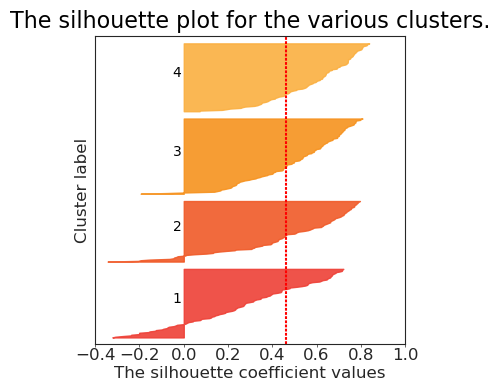

In [78]:
make_silhouette_plot(transformed_data[:,:num_retained_pcs], model.labels_)

The average silhouette coefficient is about 0.2. As a general rule, this is a fairly low clustering quality index. However, if the range of spread of the data in the high dimensional space is fixed, silhouette score will necessarily be lower when there are many clusters in the data. Thus, this silhouette cannot by itself be used to argue against clustering in these data. This is why the clustering quality in this case needs to be verified through other means, such as projection specificity or response stability for clusters.

The neurons with negative silhouette scores are assigned to the wrong cluster. So one possible approach could be to run clustering multiple times (it's stochastic) and only select neurons that are reliably assigned to their corresponding cluster. This will improve cluster-wise inference for other analyses. However, I wanted to keep the analysis simpler and hence, decided not to do such filtering.

Plot the identified clusters. This plot is a good comparison to the original plot of the data, which did not cluster the data

/tmp/ipykernel_2508084/1852315476.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


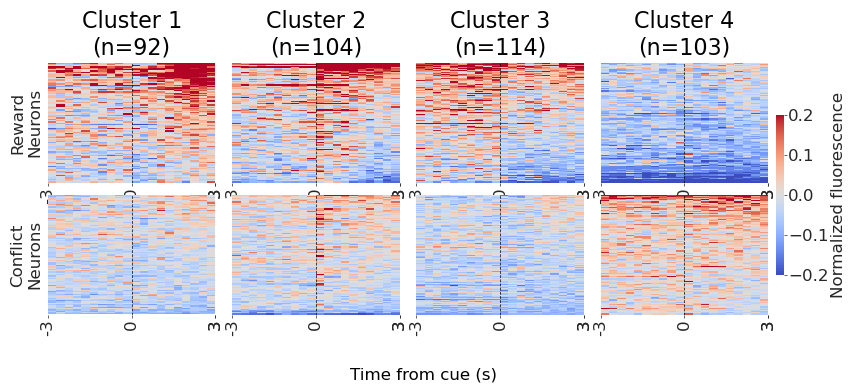

In [79]:
cmax = 0.2
sortwindow = [15, 100]

fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(trial_types)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numroisincluster = np.nan*np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels==cluster)[0], k*window_size:(k+1)*window_size]
        numroisincluster[c] = temp.shape[0]
        sortresponse = np.argsort(np.mean(temp[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
        sns.heatmap(temp[sortresponse],
                    ax=axs[k, cluster],
                    cmap=plt.get_cmap('coolwarm'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence'})
        axs[k, cluster].grid(False)
        if k==len(trial_types)-1:
            axs[k, cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[k, cluster].set_xticks([])
        axs[k, cluster].tick_params(width=0.5)
        axs[k, cluster].set_xticks([0, pre_window_size,
                            pre_window_size + frames_to_reward, window_size])

        axs[k, cluster].set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                         for a in [0, pre_window_size,
                                                   pre_window_size + frames_to_reward, window_size]])
        axs[k, cluster].set_yticks([])
        axs[k, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[k, cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster==0:
            axs[k, 0].set_ylabel('%s\nNeurons'%(tempkey))
    axs[0, cluster].set_title('Cluster %d\n(n=%d)'%(cluster+1, numroisincluster[c]))
    
fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

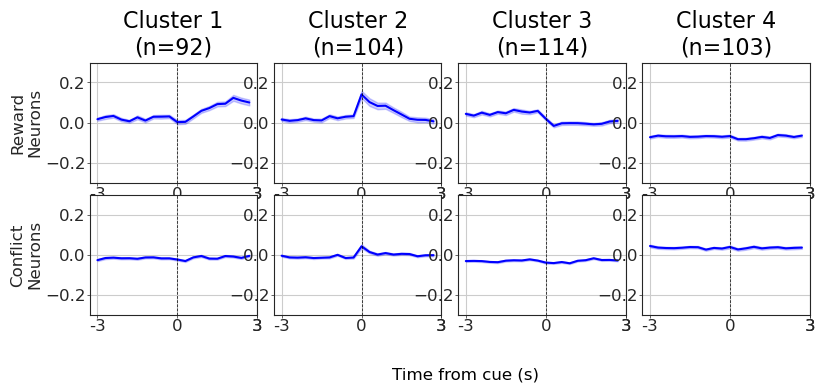

In [80]:
cmax = 0.2
sortwindow = [15, 100]

#fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
#                        figsize=(2*len(uniquelabels),2*len(trial_types)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 


fig, axs = plt.subplots(len(trial_types), len(uniquelabels),
                        figsize=(2 * len(uniquelabels), 2 * len(trial_types)))

numroisincluster = np.nan * np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels == cluster)[0], k * window_size:(k + 1) * window_size]
        numroisincluster[c] = temp.shape[0]

        # Calculate mean and standard deviation
        mean_temp = np.mean(temp, axis=0)
        std_temp = np.std(temp, axis=0)/np.sqrt(len(temp))

        # Plot the mean line
        axs[k, cluster].plot(mean_temp, label='Mean', color='blue')
        # Fill the area between mean ± std with a transparent color
        axs[k, cluster].fill_between(range(len(mean_temp)), mean_temp - std_temp, mean_temp + std_temp,
                                     color='blue', alpha=0.2, label='Std')

        axs[k, cluster].grid(True)
        if k == len(trial_types) - 1:
            axs[k, cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[k, cluster].set_xticks([])

        axs[k, cluster].tick_params(width=0.5)
        axs[k, cluster].set_xticks([0, pre_window_size,
                                     pre_window_size + frames_to_reward, window_size])

        axs[k, cluster].set_xticklabels([str(int((a - pre_window_size + 0.0) / framerate))
                                          for a in [0, pre_window_size,
                                                    pre_window_size + frames_to_reward, window_size]])
        #axs[k, cluster].set_yticks()
        axs[k, cluster].set_ylim(-0.3,0.3)
        axs[k, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[k, cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster == 0:
            axs[k, 0].set_ylabel('%s\nNeurons' % (tempkey))
    axs[0, cluster].set_title('Cluster %d\n(n=%d)' % (cluster + 1, numroisincluster[c]))

fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
#fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

plt.show()


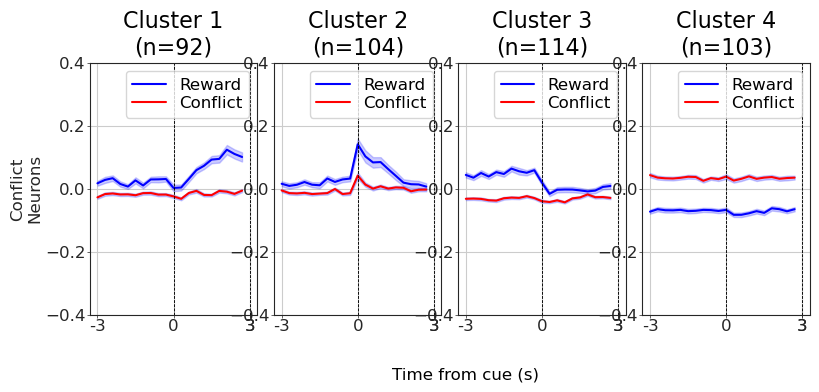

In [81]:
cmax = 0.2
sortwindow = [15, 100]

#fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
#                        figsize=(2*len(uniquelabels),2*len(trial_types)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 


fig, axs = plt.subplots(1, len(uniquelabels),
                        figsize=(2 * len(uniquelabels), 2 * len(trial_types)))

numroisincluster = np.nan * np.ones((len(uniquelabels),))

colors = ['blue', 'red']
trials = trial_types

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels == cluster)[0], k * window_size:(k + 1) * window_size]
        numroisincluster[c] = temp.shape[0]

        # Calculate mean and standard deviation
        mean_temp = np.mean(temp, axis=0)
        std_temp = np.std(temp, axis=0)/np.sqrt(len(temp))

        # Plot the mean line
        axs[cluster].plot(mean_temp, label= trials[k], color= colors[k])
        # Fill the area between mean ± std with a transparent color
        axs[cluster].fill_between(range(len(mean_temp)), mean_temp - std_temp, mean_temp + std_temp,
                                     color='blue', alpha=0.2)

        axs[cluster].grid(True)
        if k == len(trial_types) - 1:
            axs[cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[cluster].set_xticks([])

        axs[cluster].tick_params(width=0.5)
        axs[cluster].set_xticks([0, pre_window_size,
                                     pre_window_size + frames_to_reward, window_size])

        axs[cluster].set_xticklabels([str(int((a - pre_window_size + 0.0) / framerate))
                                          for a in [0, pre_window_size,
                                                    pre_window_size + frames_to_reward, window_size]])
        #axs[k, cluster].set_yticks()
        axs[cluster].set_ylim(-0.4,0.4)
        axs[cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster == 0:
            axs[0].set_ylabel('%s\nNeurons' % (tempkey))
    axs[cluster].set_title('Cluster %d\n(n=%d)' % (cluster + 1, numroisincluster[c]))
    axs[cluster].legend()

fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
#fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

plt.show()


Based on the responses of these identified clusters, the data do indeed look consistent with clustering. This is because the activity of neurons within a cluster look quite similar while activity across clusters looks quite different. As a further validation of the clustering, I will plot each neuron separated by clusters in the PCA space within which clustering was done.

Since there are 8 dimensions in the PCA space, I will use tSNE to reduce the dimensionality of this space to a 2D space. I will plot the tSNE transformation of the PCA scores of each pair of cluster against each other. If there are actually no real clusters, this plot will make it super clear. In this case, the default identified number of clusters will be two and in this plot, the two clusters will look like they belong to the same blob with an arbitrary line separating them. Instead, if there are real clusters, you will see different clusters forming different blobs when plotted against each other. 

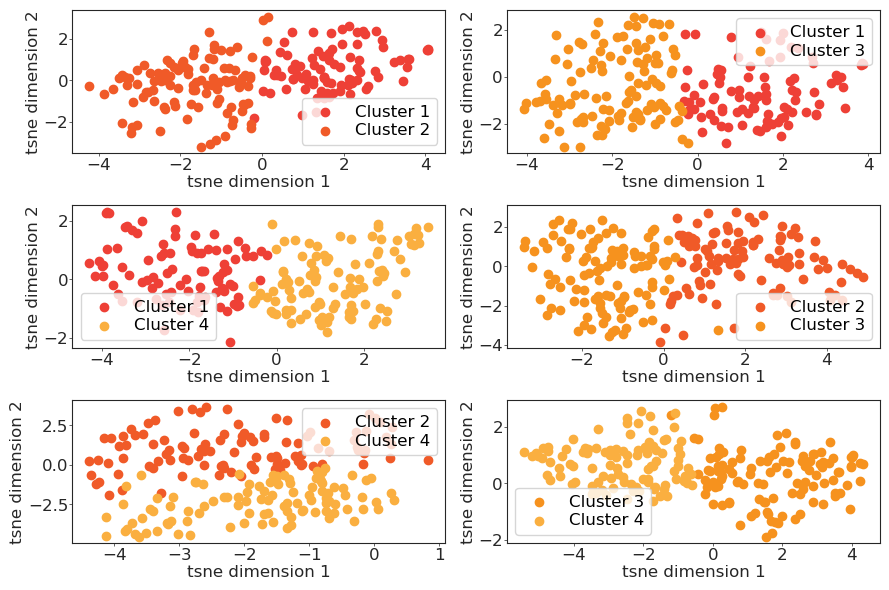

In [82]:
num_clusterpairs = len(uniquelabels)*(len(uniquelabels)-1)/2

numrows = int(np.ceil(num_clusterpairs**0.5))
numcols = int(np.ceil(num_clusterpairs/np.ceil(num_clusterpairs**0.5)))
fig, axs = plt.subplots(numrows, numcols, figsize=(3*numrows, 3*numcols))

tempsum = 0
for c1, cluster1 in enumerate(uniquelabels):
    for c2, cluster2 in enumerate(uniquelabels):
        if cluster1>=cluster2:
            continue
        temp1 = transformed_data[np.where(newlabels==cluster1)[0], :num_retained_pcs]
        temp2 = transformed_data[np.where(newlabels==cluster2)[0], :num_retained_pcs]
        X = np.concatenate((temp1, temp2), axis=0)
        tsne = TSNE(n_components=2, init='random',
                    random_state=0, perplexity=100)
        Y = tsne.fit_transform(X)
        if numrows * numcols == 1:
            ax = axs
        else:
            ax = axs[tempsum // numcols, tempsum - (tempsum // numcols) * numcols]


        ax.scatter(Y[:np.sum(newlabels==cluster1),0],
                   Y[:np.sum(newlabels==cluster1),1],
                   color=colors_for_cluster[cluster1], label='Cluster %d'%(cluster1+1), alpha=1)
        ax.scatter(Y[np.sum(newlabels==cluster1):,0],
                   Y[np.sum(newlabels==cluster1):,1],
                   color=colors_for_cluster[cluster2], label='Cluster %d'%(cluster2+1), alpha=1)

        ax.set_xlabel('tsne dimension 1')
        ax.set_ylabel('tsne dimension 2')
        ax.legend()
        tempsum += 1
fig.tight_layout()

In [83]:
all_cells = Reward.reset_index().iloc[:,:2]

# Perform a left join on 'Animal_ID' and 'Unit_ID' columns
merged = all_cells.merge(PhotoTag, on=['Animal_ID', 'Unit_id'], how='left')

# Fill missing values in the 'Unit_Type' column with 'unidentified'
merged['Unit_Type'] = merged['Unit_Type'].fillna('unidentified')
merged['Cluster'] = newlabels+1

# Check the resulting DataFrame
print(merged)


    Unit_id Animal_ID     Unit_Type  Cluster
0    SPK04a       3P4        PL-NAc        1
1    SPK07a       3P4  Unidentified        2
2    SPK07b       3P4  Unidentified        2
3    SPK08a       3P4  Unidentified        2
4    SPK09a       3P4  Unidentified        2
..      ...       ...           ...      ...
408  SPK28a       5A4  Unidentified        1
409  SPK30a       5A4  Unidentified        4
410  SPK20a       5U5  Unidentified        2
411  SPK28a       5U5  Unidentified        3
412  SPK28b       5U5  Unidentified        3

[413 rows x 4 columns]


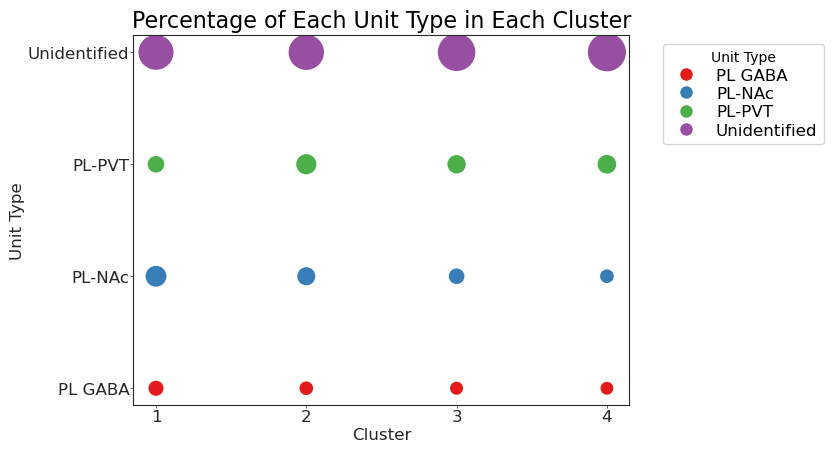

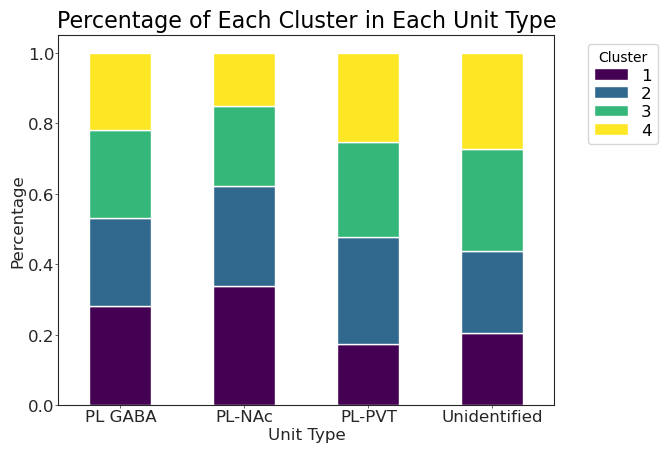

In [84]:

# Calculate the percentage of each unit type in each cluster
cluster_unit_type_counts = merged.groupby(['Cluster', 'Unit_Type']).size().unstack(fill_value=0)
cluster_unit_type_perc = cluster_unit_type_counts.div(cluster_unit_type_counts.sum(axis=1), axis=0)

# Calculate the percentage of each cluster in each unit type
unit_type_cluster_counts = merged.groupby(['Unit_Type', 'Cluster']).size().unstack(fill_value=0)
unit_type_cluster_perc = unit_type_cluster_counts.div(unit_type_cluster_counts.sum(axis=1), axis=0)

# Get the Pastel2 colormap
cmap = cm.get_cmap('Set1')

# Plot the percentage of each unit type in each cluster using a scatter plot
fig, ax = plt.subplots()
for i, unit_type in enumerate(cluster_unit_type_perc.columns):
    ax.scatter(cluster_unit_type_perc.index, [unit_type] * len(cluster_unit_type_perc), s=cluster_unit_type_perc[unit_type] * 1000, c =[cmap(i)])

ax.set_xticks(cluster_unit_type_perc.index)
ax.set_yticks(range(0, len(cluster_unit_type_perc.columns)))
ax.set_yticklabels(cluster_unit_type_perc.columns)

ax.set_xlabel('Cluster')
ax.set_ylabel('Unit Type')
ax.set_title('Percentage of Each Unit Type in Each Cluster')

# Create a proxy artist for the legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=unit_type, markerfacecolor=cmap(i), markersize=10) for i, unit_type in enumerate(cluster_unit_type_perc.columns)]
ax.legend(handles=legend_elements, title="Unit Type", bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot the percentage of each cluster in each unit type using a stacked histogram
fig, ax = plt.subplots()
unit_type_cluster_perc.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')

ax.set_xticklabels(unit_type_cluster_perc.index, rotation=0)
ax.set_xlabel('Unit Type')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Each Cluster in Each Unit Type')
ax.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

## 6s before and after normalized to 6s before

In [85]:
basedir = './' # folder containing code and data
Reward = pd.read_csv(os.path.join(basedir, 'Reward_6s_z_wholetrace.csv'), index_col = 0)
Conflict = pd.read_csv(os.path.join(basedir, 'Conflict_6s_z_wholetrace.csv'), index_col = 0)
reward = Reward.iloc[:,1:].to_numpy()
conflict = Conflict.iloc[:,1:].to_numpy()

TimeRange = 12
TotalBins = int(TimeRange/BinSize)

populationdata = np.concatenate([reward,conflict],axis =1)

In [86]:
populationdata.flatten().max()

1.2646212733689268

(array([6.0000e+01, 5.1720e+03, 2.4371e+04, 2.9990e+03, 3.3700e+02,
        5.4000e+01, 3.3000e+01, 8.0000e+00, 1.0000e+00, 5.0000e+00]),
 array([-0.40385307, -0.23700564, -0.0701582 ,  0.09668923,  0.26353667,
         0.4303841 ,  0.59723154,  0.76407897,  0.9309264 ,  1.09777384,
         1.26462127]),
 <BarContainer object of 10 artists>)

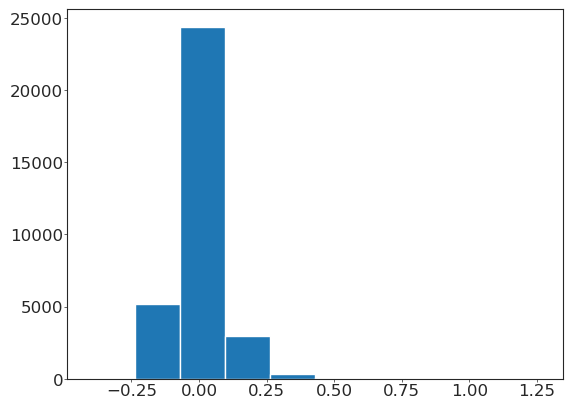

In [87]:
plt.hist(populationdata.flatten())

Now, we will visualize the full dataset to get a sense of what they look like. As mentioned previously, the first 100 features correspond to CS+ responses and the last 100 features correspond to CS- responses. So I will plot both trial types separately.

In [88]:
framerate = 1/BinSize
pre_window_size = int(0.5*TimeRange*framerate) # 3 seconds multipled by 5 frames. Corresponds to baseline prior to cues.
window_size = TotalBins # Total number of frames plotted around a cue
frames_to_reward = int(0.5*TimeRange*framerate) # 3 seconds until reward after CS+

sortwindow = [pre_window_size, pre_window_size + frames_to_reward] # Sort responses between CS+ onset and reward.
sortresponse = np.argsort(np.mean(populationdata[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
# sortresponse corresponds to an ordering of the neurons based on their average response in the sortwindow

cmax = 0.25 # Maximum colormap value. 
cmin = -0.25

trial_types = ['Reward', 'Conflict']

/tmp/ipykernel_2508084/896160079.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


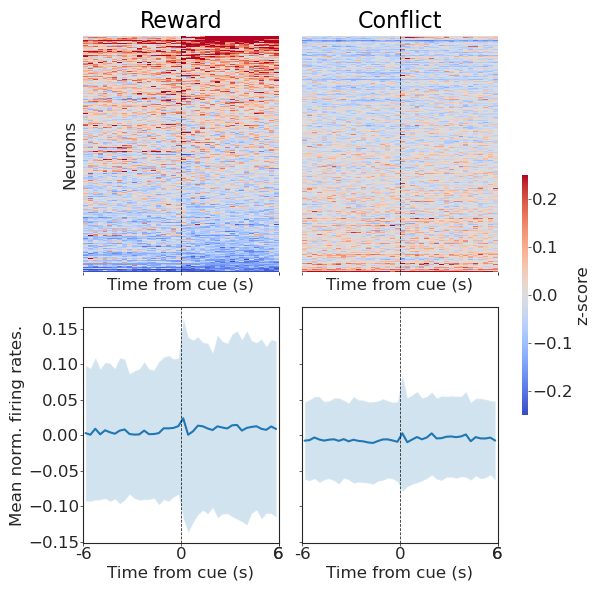

In [89]:
fig, axs = plt.subplots(2,2,figsize=(3*2,3*2), sharex='all', sharey='row')
cbar_ax = fig.add_axes([0.86, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

def tsplot(ax, data,**kw):
    x = np.arange(window_size)
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    ax.fill_between(x+0.5,cis[0],cis[1], alpha=0.2, **kw)
    ax.plot(x+0.5,est,**kw)
    ax.margins(x=0)


for t in range(len(trial_types)):
    axs[0,t].set_title(trial_types[t])
    ax = axs[0,t]
    sns.heatmap(populationdata[sortresponse, t*window_size: (t+1)*window_size],
                ax=ax,
                cmap=plt.get_cmap('coolwarm'),
                vmin=cmin,
                vmax=cmax,
                cbar=(t==0),
                cbar_ax=cbar_ax if (t==0) else None,
                cbar_kws={'label': 'z-score'})
    ax.grid(False)
    ax.tick_params(width=0.5)   
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])
    ax.set_yticks([])
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    
        
    ax = axs[1,t]
    tsplot(ax, populationdata[sortresponse, t*window_size:(t+1)*window_size])
    ax.set_xticks(np.arange(0, window_size + 1, frames_to_reward))
    ax.set_xticklabels([str(int((a - pre_window_size) / framerate)) for a in np.arange(0, window_size + 1, frames_to_reward)])

    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])

axs[0,0].set_ylabel('Neurons')
axs[1,0].set_ylabel('Mean norm. firing rates.')

fig.tight_layout()
fig.subplots_adjust(right=0.82)

Including all 200 response features per neuron makes the feature space quite large. So, let us first reduce the dimensionality of this space using Principal Component Analysis

Number of PCs = 80
Number of PCs to keep = 3


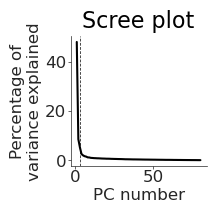

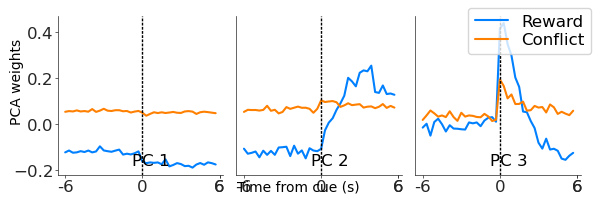

In [90]:
load_savedpca_or_dopca = 'dopca'
# Select 'dopca' for doing PCA on the data. Select 'savedpca' for loading my previous results

if load_savedpca_or_dopca == 'dopca':
    pca = PCA(n_components=populationdata.shape[1], whiten=True)
    pca.fit(populationdata) 
    with open(os.path.join(basedir, 'pcaresults.pickle'), 'wb') as f:
        pickle.dump(pca, f)
elif load_savedpca_or_dopca == 'savedpca':
    with open(os.path.join(basedir, 'OFCCaMKII_pcaresults.pickle'), 'rb') as f:
        pca = pickle.load(f)
    
transformed_data = pca.transform(populationdata)

pca_vectors = pca.components_
print ('Number of PCs = %d'%(pca_vectors.shape[0]))

x = 100*pca.explained_variance_ratio_
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
#xprime = (x - np.mean(x))/(np.max(x)-np.min(x))
num_retained_pcs = np.argmin(xprime)
# Number of PCs to be kept is defined as the number at which the 
# scree plot bends. This is done by simply bending the scree plot
# around the line joining (1, variance explained by first PC) and
# (num of PCs, variance explained by the last PC) and finding the 
# number of components just below the minimum of this rotated plot
print ('Number of PCs to keep = %d'%(num_retained_pcs))

fig, ax = plt.subplots(figsize=(2,2))
ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
ax.set_ylabel('Percentage of\nvariance explained')
ax.set_xlabel('PC number')
ax.axvline(num_retained_pcs, linestyle='--', color='k', linewidth=0.5)
ax.set_title('Scree plot')
#ax.set_xlim([0,5])
[i.set_linewidth(0.5) for i in ax.spines.values()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(top=0.9)

colors_for_key = {}
colors_for_key[trial_types[0]] = (0,0.5,1)
colors_for_key[trial_types[1]] = (1,0.5,0)

numcols = 3.0
fig, axs = plt.subplots(int(np.ceil(num_retained_pcs/numcols)), int(numcols), sharey='all',
                        figsize=(2*numcols, 2*int(np.ceil(num_retained_pcs/numcols))))
for pc in range(num_retained_pcs):
    ax = axs.flat[pc]
    for k, tempkey in enumerate(trial_types):
        ax.plot(pca_vectors[pc, k*window_size:(k+1)*window_size], color=colors_for_key[tempkey],
                label='PC %d: %s'%(pc+1, tempkey))
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=1)
    ax.annotate(text='PC %d'%(pc+1), xy=(0.45, 0.06), xytext=(0.45, 0.06), xycoords='axes fraction',
            textcoords='axes fraction', multialignment='center', size='large')
    if pc >= num_retained_pcs-numcols:
        ax.set_xticks([0, pre_window_size,
                       pre_window_size + frames_to_reward, window_size])
        ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                             for a in [0, pre_window_size,
                                       pre_window_size + frames_to_reward, window_size]])
    else:
        ax.set_xticks([])
        ax.xaxis.set_ticks_position('none')
    if pc%numcols:
        ax.yaxis.set_ticks_position('none')
    [i.set_linewidth(0.5) for i in ax.spines.values()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


fig.text(0.5, 0.05, 'Time from cue (s)', horizontalalignment='center', rotation='horizontal')
fig.text(0.02, 0.6, 'PCA weights', verticalalignment='center', rotation='vertical')
fig.tight_layout()
fig.legend(trial_types,)
for ax in axs.flat[num_retained_pcs:]:
    ax.set_visible(False)

fig.subplots_adjust(wspace=0.08, hspace=0.08)
fig.subplots_adjust(bottom=0.13)

## Perform clustering

Now, we have reduced the full dataset into a reduced dimensionality corresponding to the PCA subspace. 

Next, we will start the clustering. The approach we will use is Spectral Clustering. This is a pretty good method for dealing with high dimensional data. Note that even after PCA dimensionality reduction, there are 8 dimensions in this dataset. The choice of the method can affect the exact clustering results and there really is no "the best" algorithm. Thus, clustering is almost always the beginning of an investigation, rather than the end. In other words, the point of this clustering approach is not to say "There are 9 subpopulations of neurons in OFC for sure", but rather to test if these identified clusters can be mapped onto interesting features either in terms of their responses or in terms of their biological features (genes, anatomy etc).

The one issue with Spectral Clustering is that you have to pre-specify the number of clusters. However, there are ways to optimize this number by using metrics of "clusteredness". I use a common method: <a href="https://en.wikipedia.org/wiki/Silhouette_(clustering)">silhouette score</a>. The one caveat of this method you need to specify a minimum of two clusters. In my experience, when the data truly do not contain any clusters, the minimum of two clusters identified will be quite obviously similar to each other. When data visualization clearly shows that the identified "clusters" are similar in terms of responses, one should conclude that there are no clusters.

This is the fundamental issue with approaches such as clustering. In the end, there are strong subjective elements to it. However, when there truly are clusters in the data, it can be a powerful approach to uncovering such structure. In my case, I validated these identified clusters using two major approaches:

1. I found that the responses of neurons that were clustered on one day are stable on another day when the behavior is stable. Thus, the difference between clusters remains even on a cross-validation day.

2. Subpopulations of the output population studied here (e.g. OFC neurons projecting to VTA or NAc) comprise of only select clusters. This shows that specific types of responses are absent in specific downstream projections. Such a clear mapping of identified clusters to biology is a good indication that the clustering results are real.

In [91]:
max_n_clusters = 8 # Maximum number of clusters expected. I already ran this with up to 20 clusters and know
# that the optimal number is 9. So, I am leaving this at 11. In your data, might be worth increasing this, but
# it will take more time to run.

possible_n_clusters = np.arange(2, max_n_clusters+1) #This requires a minimum of 2 clusters.
# When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, 
# as the responses of the clusters will be quite similar. This will also be visible when plotting the data in
# the reduced dimensionality PC space (done below).


possible_n_nearest_neighbors = np.array([5, 50, 100, 200, 300]) #np.array([100, 500, 1000, 2000, 4000]) # This should be selected for each dataset
# appropriately. When 4813 neurons are present, the above number of nearest neighbors provides a good sweep of the
# parameter space. But it will need to be changed for other data.
    
silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    possible_n_nearest_neighbors.size))

for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
    for nnidx, nn in enumerate(possible_n_nearest_neighbors):
        model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=nn)
        model.fit(transformed_data[:,:num_retained_pcs])
        silhouette_scores[n_clustersidx, nnidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                                   model.labels_,
                                                                   metric='cosine')
        print ('Done with numclusters = %d, num nearest neighbors = %d: score = %.3f'%(n_clusters,
                                                                                      nn,
                                                                                      silhouette_scores[n_clustersidx,                                                                           
                                                                                                        nnidx]))

print ('Done with model fitting')

temp = {}
temp['possible_n_clusters'] = possible_n_clusters
temp['possible_n_nearest_neighbors'] = possible_n_nearest_neighbors
temp['silhouette_scores'] = silhouette_scores
temp['shape'] = 'cluster_nn'
with open(os.path.join(basedir, 'silhouette_scores.pickle'), 'wb') as f:
    pickle.dump(temp, f)

Done with numclusters = 2, num nearest neighbors = 5: score = 0.338
Done with numclusters = 2, num nearest neighbors = 50: score = 0.402
Done with numclusters = 2, num nearest neighbors = 100: score = 0.429
Done with numclusters = 2, num nearest neighbors = 200: score = 0.420
Done with numclusters = 2, num nearest neighbors = 300: score = 0.248
Done with numclusters = 3, num nearest neighbors = 5: score = 0.208
Done with numclusters = 3, num nearest neighbors = 50: score = 0.440
Done with numclusters = 3, num nearest neighbors = 100: score = 0.435
Done with numclusters = 3, num nearest neighbors = 200: score = 0.373
Done with numclusters = 3, num nearest neighbors = 300: score = 0.199
Done with numclusters = 4, num nearest neighbors = 5: score = 0.311
Done with numclusters = 4, num nearest neighbors = 50: score = 0.461
Done with numclusters = 4, num nearest neighbors = 100: score = 0.475
Done with numclusters = 4, num nearest neighbors = 200: score = 0.374
Done with numclusters = 4, nu

Next, we will reorder the cluster labels such that there is a fixed order for naming the clusters. This is important because if you run the previous code multiple times, it will return different orders for the cluster labels.

In [92]:
with open(os.path.join(basedir, 'silhouette_scores.pickle'), 'rb') as f:
    silhouette_scores = pickle.load(f)
    
transformed_data = transformed_data #np.load(os.path.join(basedir, 'OFCCaMKII_transformed_data.npy'))

# Identify optimal parameters from the above parameter space
temp = np.where(silhouette_scores['silhouette_scores']==np.nanmax(silhouette_scores['silhouette_scores']))
n_clusters = silhouette_scores['possible_n_clusters'][temp[0][0]]
n_nearest_neighbors = silhouette_scores['possible_n_nearest_neighbors'][temp[1][0]]

print (n_clusters, n_nearest_neighbors)

# Redo clustering with these optimal parameters
model = SpectralClustering(n_clusters=n_clusters,
                           affinity='nearest_neighbors',
                           n_neighbors=n_nearest_neighbors)

# model = KMeans(n_clusters=n_clusters)

# model = AgglomerativeClustering(n_clusters=9,
#                                 affinity='l1',
#                                 linkage='average')

model.fit(transformed_data[:,:num_retained_pcs])

temp = silhouette_score(transformed_data[:,:num_retained_pcs], model.labels_, metric='cosine')

print ('Number of clusters = %d, average silhouette = %.3f'%(len(set(model.labels_)), temp))

# Save this optimal clustering model.
# with open(os.path.join(basedir, 'clusteringmodel.pickle'), 'wb') as f:
#     pickle.dump(model, f)

          
# Since the clustering labels are arbitrary, I rename the clusters so that the first cluster will have the most
# positive response and the last cluster will have the most negative response.
def reorder_clusters(rawlabels):
    uniquelabels = list(set(rawlabels))
    responses = np.nan*np.ones((len(uniquelabels),))
    for l, label in enumerate(uniquelabels):
        responses[l] = np.mean(populationdata[rawlabels==label, pre_window_size:2*pre_window_size])
    temp = np.argsort(responses).astype(int)[::-1]
    temp = np.array([np.where(temp==a)[0][0] for a in uniquelabels])
    outputlabels = np.array([temp[a] for a in list(np.digitize(rawlabels, uniquelabels)-1)])
    return outputlabels
newlabels = reorder_clusters(model.labels_)

# Create a new variable containing all unique cluster labels
uniquelabels = list(set(newlabels))

# np.save(os.path.join(basedir, 'OFCCaMKII_clusterlabels.npy'), newlabels)

colors_for_cluster = [[0.933, 0.250, 0.211],
                      [0.941, 0.352, 0.156],
                      [0.964, 0.572, 0.117],
                      [0.980, 0.686, 0.250],
                      [0.545, 0.772, 0.247],
                      [0.215, 0.701, 0.290],
                      [0, 0.576, 0.270],
                      [0, 0.650, 0.611],
                      [0.145, 0.662, 0.878]]

4 100
Number of clusters = 4, average silhouette = 0.475


Make a silhouette plot to visualize clustering quality. The average silhouette score above is the mean of all sample silhouettes. There are two other clustering methods commented out above (KMeans and agglomerative). One can see that if you apply those methods, the average silhouette score is lower, demonstrating that those methods are worse for these data. This also then shows that the high dimensional geometry for these data is unlikely to be a simple Gaussian structure, as these other methods are specialized for picking up Gaussian clusters. Spectral clustering is effective as it can uncover peculiarly shaped clusters

In [93]:
def make_silhouette_plot(X, cluster_labels):
    
    n_clusters = len(set(cluster_labels))
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels, metric='cosine')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric='cosine')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors_for_cluster[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.9)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

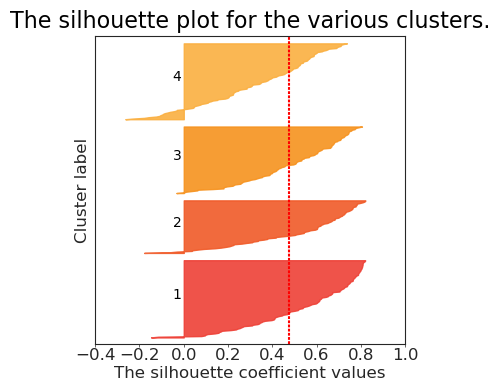

In [94]:
make_silhouette_plot(transformed_data[:,:num_retained_pcs], model.labels_)

The average silhouette coefficient is about 0.2. As a general rule, this is a fairly low clustering quality index. However, if the range of spread of the data in the high dimensional space is fixed, silhouette score will necessarily be lower when there are many clusters in the data. Thus, this silhouette cannot by itself be used to argue against clustering in these data. This is why the clustering quality in this case needs to be verified through other means, such as projection specificity or response stability for clusters.

The neurons with negative silhouette scores are assigned to the wrong cluster. So one possible approach could be to run clustering multiple times (it's stochastic) and only select neurons that are reliably assigned to their corresponding cluster. This will improve cluster-wise inference for other analyses. However, I wanted to keep the analysis simpler and hence, decided not to do such filtering.

Plot the identified clusters. This plot is a good comparison to the original plot of the data, which did not cluster the data

/tmp/ipykernel_2508084/1852315476.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


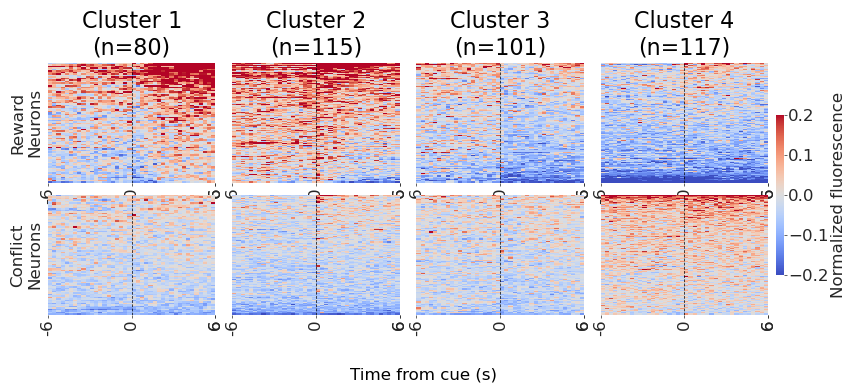

In [95]:
cmax = 0.2
sortwindow = [15, 100]

fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(trial_types)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numroisincluster = np.nan*np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels==cluster)[0], k*window_size:(k+1)*window_size]
        numroisincluster[c] = temp.shape[0]
        sortresponse = np.argsort(np.mean(temp[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
        sns.heatmap(temp[sortresponse],
                    ax=axs[k, cluster],
                    cmap=plt.get_cmap('coolwarm'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence'})
        axs[k, cluster].grid(False)
        if k==len(trial_types)-1:
            axs[k, cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[k, cluster].set_xticks([])
        axs[k, cluster].tick_params(width=0.5)
        axs[k, cluster].set_xticks([0, pre_window_size,
                            pre_window_size + frames_to_reward, window_size])

        axs[k, cluster].set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                         for a in [0, pre_window_size,
                                                   pre_window_size + frames_to_reward, window_size]])
        axs[k, cluster].set_yticks([])
        axs[k, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[k, cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster==0:
            axs[k, 0].set_ylabel('%s\nNeurons'%(tempkey))
    axs[0, cluster].set_title('Cluster %d\n(n=%d)'%(cluster+1, numroisincluster[c]))
    
fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

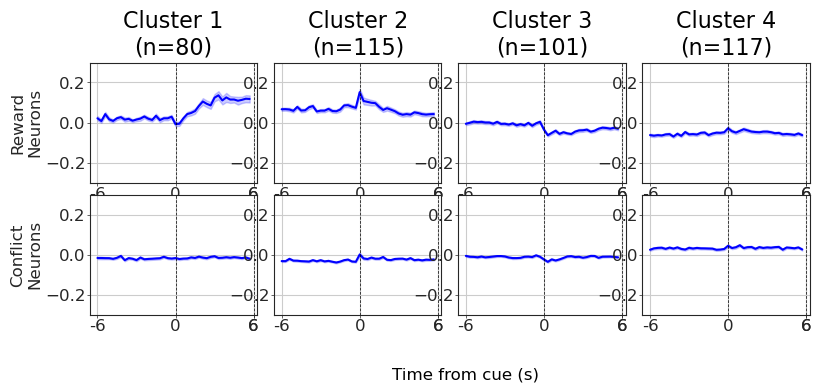

In [96]:
cmax = 0.2
sortwindow = [15, 100]

#fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
#                        figsize=(2*len(uniquelabels),2*len(trial_types)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 


fig, axs = plt.subplots(len(trial_types), len(uniquelabels),
                        figsize=(2 * len(uniquelabels), 2 * len(trial_types)))

numroisincluster = np.nan * np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels == cluster)[0], k * window_size:(k + 1) * window_size]
        numroisincluster[c] = temp.shape[0]

        # Calculate mean and standard deviation
        mean_temp = np.mean(temp, axis=0)
        std_temp = np.std(temp, axis=0)/np.sqrt(len(temp))

        # Plot the mean line
        axs[k, cluster].plot(mean_temp, label='Mean', color='blue')
        # Fill the area between mean ± std with a transparent color
        axs[k, cluster].fill_between(range(len(mean_temp)), mean_temp - std_temp, mean_temp + std_temp,
                                     color='blue', alpha=0.2, label='Std')

        axs[k, cluster].grid(True)
        if k == len(trial_types) - 1:
            axs[k, cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[k, cluster].set_xticks([])

        axs[k, cluster].tick_params(width=0.5)
        axs[k, cluster].set_xticks([0, pre_window_size,
                                     pre_window_size + frames_to_reward, window_size])

        axs[k, cluster].set_xticklabels([str(int((a - pre_window_size + 0.0) / framerate))
                                          for a in [0, pre_window_size,
                                                    pre_window_size + frames_to_reward, window_size]])
        #axs[k, cluster].set_yticks()
        axs[k, cluster].set_ylim(-0.3,0.3)
        axs[k, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[k, cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster == 0:
            axs[k, 0].set_ylabel('%s\nNeurons' % (tempkey))
    axs[0, cluster].set_title('Cluster %d\n(n=%d)' % (cluster + 1, numroisincluster[c]))

fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
#fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

plt.show()


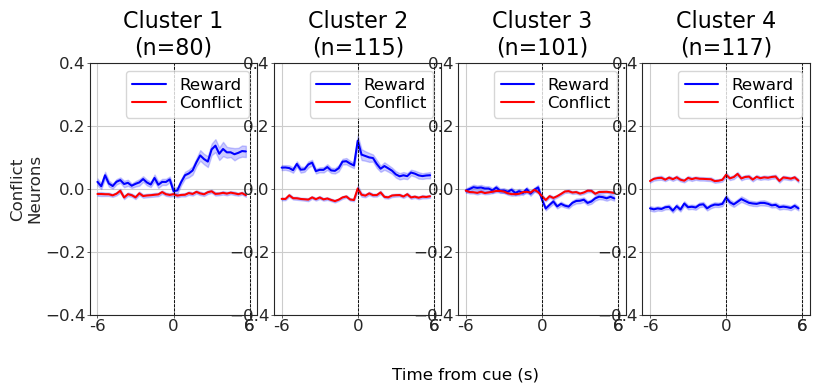

In [97]:
cmax = 0.2
sortwindow = [15, 100]

#fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
#                        figsize=(2*len(uniquelabels),2*len(trial_types)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 


fig, axs = plt.subplots(1, len(uniquelabels),
                        figsize=(2 * len(uniquelabels), 2 * len(trial_types)))

numroisincluster = np.nan * np.ones((len(uniquelabels),))

colors = ['blue', 'red']
trials = trial_types

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels == cluster)[0], k * window_size:(k + 1) * window_size]
        numroisincluster[c] = temp.shape[0]

        # Calculate mean and standard deviation
        mean_temp = np.mean(temp, axis=0)
        std_temp = np.std(temp, axis=0)/np.sqrt(len(temp))

        # Plot the mean line
        axs[cluster].plot(mean_temp, label= trials[k], color= colors[k])
        # Fill the area between mean ± std with a transparent color
        axs[cluster].fill_between(range(len(mean_temp)), mean_temp - std_temp, mean_temp + std_temp,
                                     color='blue', alpha=0.2)

        axs[cluster].grid(True)
        if k == len(trial_types) - 1:
            axs[cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[cluster].set_xticks([])

        axs[cluster].tick_params(width=0.5)
        axs[cluster].set_xticks([0, pre_window_size,
                                     pre_window_size + frames_to_reward, window_size])

        axs[cluster].set_xticklabels([str(int((a - pre_window_size + 0.0) / framerate))
                                          for a in [0, pre_window_size,
                                                    pre_window_size + frames_to_reward, window_size]])
        #axs[k, cluster].set_yticks()
        axs[cluster].set_ylim(-0.4,0.4)
        axs[cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster == 0:
            axs[0].set_ylabel('%s\nNeurons' % (tempkey))
    axs[cluster].set_title('Cluster %d\n(n=%d)' % (cluster + 1, numroisincluster[c]))
    axs[cluster].legend()

fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
#fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

plt.show()


Based on the responses of these identified clusters, the data do indeed look consistent with clustering. This is because the activity of neurons within a cluster look quite similar while activity across clusters looks quite different. As a further validation of the clustering, I will plot each neuron separated by clusters in the PCA space within which clustering was done.

Since there are 8 dimensions in the PCA space, I will use tSNE to reduce the dimensionality of this space to a 2D space. I will plot the tSNE transformation of the PCA scores of each pair of cluster against each other. If there are actually no real clusters, this plot will make it super clear. In this case, the default identified number of clusters will be two and in this plot, the two clusters will look like they belong to the same blob with an arbitrary line separating them. Instead, if there are real clusters, you will see different clusters forming different blobs when plotted against each other. 

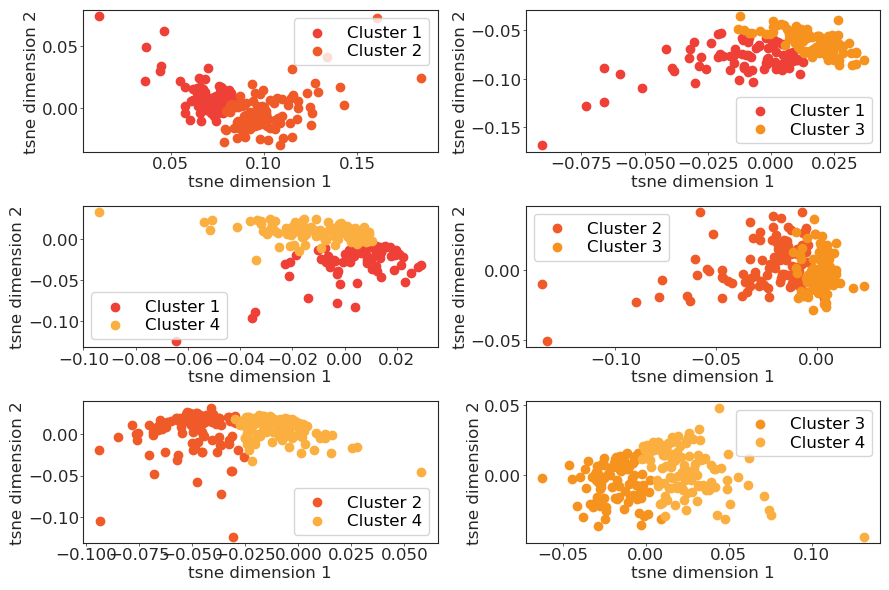

In [98]:
num_clusterpairs = len(uniquelabels)*(len(uniquelabels)-1)/2

numrows = int(np.ceil(num_clusterpairs**0.5))
numcols = int(np.ceil(num_clusterpairs/np.ceil(num_clusterpairs**0.5)))
fig, axs = plt.subplots(numrows, numcols, figsize=(3*numrows, 3*numcols))

tempsum = 0
for c1, cluster1 in enumerate(uniquelabels):
    for c2, cluster2 in enumerate(uniquelabels):
        if cluster1>=cluster2:
            continue
        temp1 = transformed_data[np.where(newlabels==cluster1)[0], :num_retained_pcs]
        temp2 = transformed_data[np.where(newlabels==cluster2)[0], :num_retained_pcs]
        X = np.concatenate((temp1, temp2), axis=0)
        tsne = TSNE(n_components=2, init='random',
                    random_state=0, perplexity=X.shape[0]-1)
        Y = tsne.fit_transform(X)
        if numrows * numcols == 1:
            ax = axs
        else:
            ax = axs[tempsum // numcols, tempsum - (tempsum // numcols) * numcols]


        ax.scatter(Y[:np.sum(newlabels==cluster1),0],
                   Y[:np.sum(newlabels==cluster1),1],
                   color=colors_for_cluster[cluster1], label='Cluster %d'%(cluster1+1), alpha=1)
        ax.scatter(Y[np.sum(newlabels==cluster1):,0],
                   Y[np.sum(newlabels==cluster1):,1],
                   color=colors_for_cluster[cluster2], label='Cluster %d'%(cluster2+1), alpha=1)

        ax.set_xlabel('tsne dimension 1')
        ax.set_ylabel('tsne dimension 2')
        ax.legend()
        tempsum += 1
fig.tight_layout()

In [99]:
all_cells = Reward.reset_index().iloc[:,:2]

# Perform a left join on 'Animal_ID' and 'Unit_ID' columns
merged = all_cells.merge(PhotoTag, on=['Animal_ID', 'Unit_id'], how='left')

# Fill missing values in the 'Unit_Type' column with 'unidentified'
merged['Unit_Type'] = merged['Unit_Type'].fillna('unidentified')
merged['Cluster'] = newlabels+1

# Check the resulting DataFrame
print(merged)


    Unit_id Animal_ID     Unit_Type  Cluster
0    SPK04a       3P4        PL-NAc        1
1    SPK07a       3P4  Unidentified        2
2    SPK07b       3P4  Unidentified        3
3    SPK08a       3P4  Unidentified        1
4    SPK09a       3P4  Unidentified        2
..      ...       ...           ...      ...
408  SPK28a       5A4  Unidentified        1
409  SPK30a       5A4  Unidentified        4
410  SPK20a       5U5  Unidentified        2
411  SPK28a       5U5  Unidentified        2
412  SPK28b       5U5  Unidentified        2

[413 rows x 4 columns]


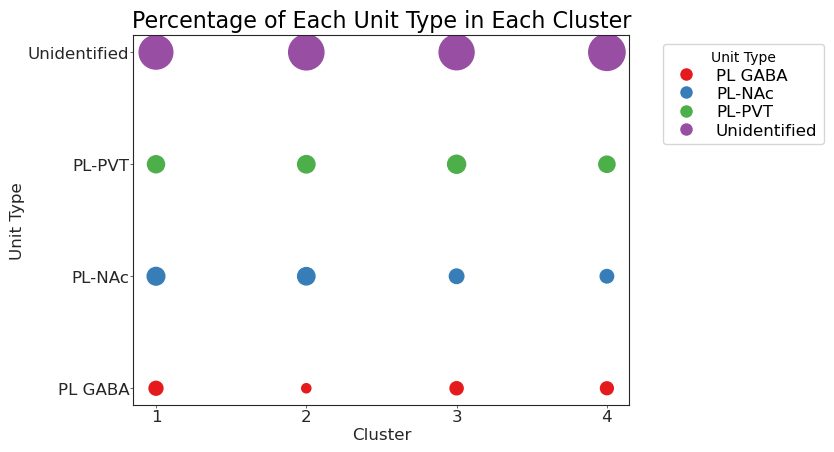

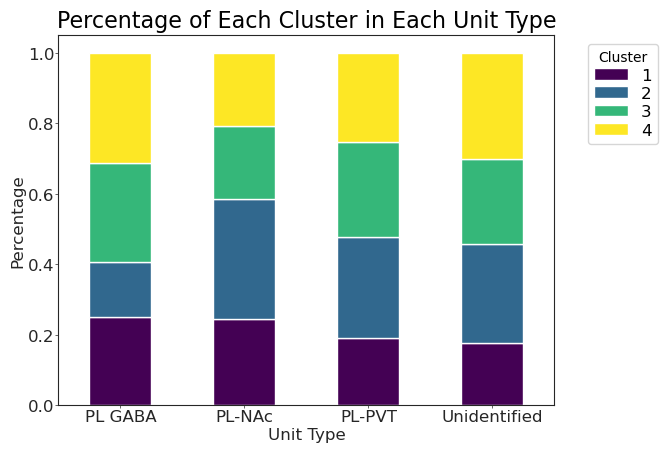

In [100]:

# Calculate the percentage of each unit type in each cluster
cluster_unit_type_counts = merged.groupby(['Cluster', 'Unit_Type']).size().unstack(fill_value=0)
cluster_unit_type_perc = cluster_unit_type_counts.div(cluster_unit_type_counts.sum(axis=1), axis=0)

# Calculate the percentage of each cluster in each unit type
unit_type_cluster_counts = merged.groupby(['Unit_Type', 'Cluster']).size().unstack(fill_value=0)
unit_type_cluster_perc = unit_type_cluster_counts.div(unit_type_cluster_counts.sum(axis=1), axis=0)

# Get the Pastel2 colormap
cmap = cm.get_cmap('Set1')

# Plot the percentage of each unit type in each cluster using a scatter plot
fig, ax = plt.subplots()
for i, unit_type in enumerate(cluster_unit_type_perc.columns):
    ax.scatter(cluster_unit_type_perc.index, [unit_type] * len(cluster_unit_type_perc), s=cluster_unit_type_perc[unit_type] * 1000, c =[cmap(i)])

ax.set_xticks(cluster_unit_type_perc.index)
ax.set_yticks(range(0, len(cluster_unit_type_perc.columns)))
ax.set_yticklabels(cluster_unit_type_perc.columns)

ax.set_xlabel('Cluster')
ax.set_ylabel('Unit Type')
ax.set_title('Percentage of Each Unit Type in Each Cluster')

# Create a proxy artist for the legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=unit_type, markerfacecolor=cmap(i), markersize=10) for i, unit_type in enumerate(cluster_unit_type_perc.columns)]
ax.legend(handles=legend_elements, title="Unit Type", bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot the percentage of each cluster in each unit type using a stacked histogram
fig, ax = plt.subplots()
unit_type_cluster_perc.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')

ax.set_xticklabels(unit_type_cluster_perc.index, rotation=0)
ax.set_xlabel('Unit Type')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Each Cluster in Each Unit Type')
ax.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

## 3s before and after and normalized to 3s before

In [108]:
basedir = './' # folder containing code and data
Reward = pd.read_csv(os.path.join(basedir, 'Reward_3s_z_3s.csv'), index_col = 0)
Conflict = pd.read_csv(os.path.join(basedir, 'Conflict_3s_z_3s.csv'), index_col = 0)
reward = Reward.iloc[:,1:].to_numpy()
conflict = Conflict.iloc[:,1:].to_numpy()

TimeRange = 6
TotalBins = int(TimeRange/BinSize)

populationdata = np.concatenate([reward,conflict],axis =1)

In [109]:
Reward = Reward[~np.any(np.isnan(populationdata), axis=1)]
PhotoTag = PhotoTag[~np.any(np.isnan(populationdata), axis=1)]
populationdata = populationdata[~np.any(np.isnan(populationdata), axis=1)]

In [110]:
populationdata.flatten().max()

27.94025326193933

(array([2.5500e+02, 1.2911e+04, 3.0470e+03, 1.3300e+02, 3.3000e+01,
        1.1000e+01, 6.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([-5.7279455 , -2.36112562,  1.00569426,  4.37251413,  7.73933401,
        11.10615388, 14.47297376, 17.83979363, 21.20661351, 24.57343339,
        27.94025326]),
 <BarContainer object of 10 artists>)

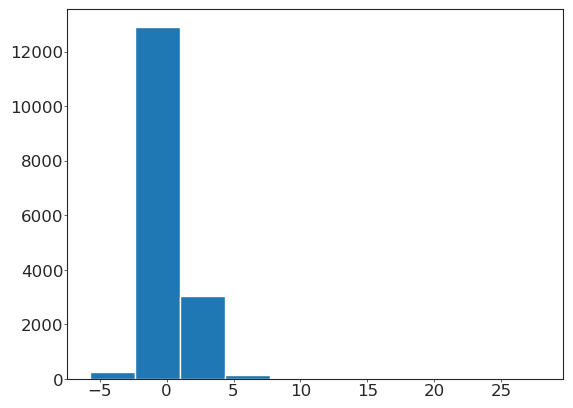

In [111]:
plt.hist(populationdata.flatten())

Now, we will visualize the full dataset to get a sense of what they look like. As mentioned previously, the first 100 features correspond to CS+ responses and the last 100 features correspond to CS- responses. So I will plot both trial types separately.

In [112]:
framerate = 1/BinSize
pre_window_size = int(0.5*TimeRange*framerate) # 3 seconds multipled by 5 frames. Corresponds to baseline prior to cues.
window_size = TotalBins # Total number of frames plotted around a cue
frames_to_reward = int(0.5*TimeRange*framerate) # 3 seconds until reward after CS+

sortwindow = [pre_window_size, pre_window_size + frames_to_reward] # Sort responses between CS+ onset and reward.
sortresponse = np.argsort(np.mean(populationdata[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
# sortresponse corresponds to an ordering of the neurons based on their average response in the sortwindow

cmax = 4 # Maximum colormap value. 
cmin = -4

trial_types = ['Reward', 'Conflict']

/tmp/ipykernel_3564623/896160079.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


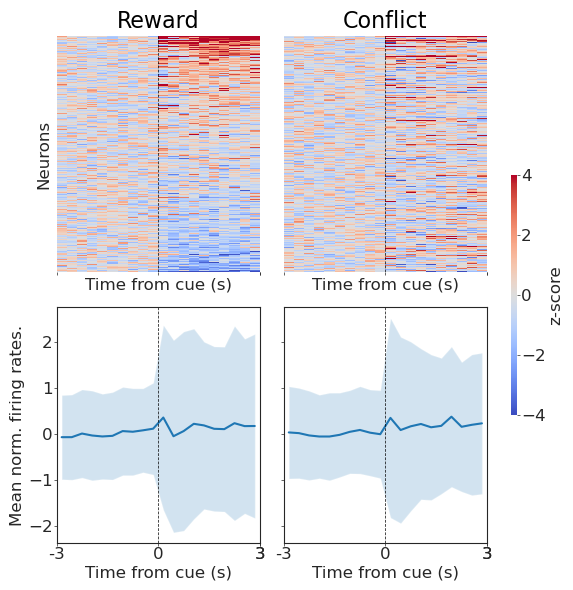

In [113]:
fig, axs = plt.subplots(2,2,figsize=(3*2,3*2), sharex='all', sharey='row')
cbar_ax = fig.add_axes([0.86, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

def tsplot(ax, data,**kw):
    x = np.arange(window_size)
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    ax.fill_between(x+0.5,cis[0],cis[1], alpha=0.2, **kw)
    ax.plot(x+0.5,est,**kw)
    ax.margins(x=0)


for t in range(len(trial_types)):
    axs[0,t].set_title(trial_types[t])
    ax = axs[0,t]
    sns.heatmap(populationdata[sortresponse, t*window_size: (t+1)*window_size],
                ax=ax,
                cmap=plt.get_cmap('coolwarm'),
                vmin=cmin,
                vmax=cmax,
                cbar=(t==0),
                cbar_ax=cbar_ax if (t==0) else None,
                cbar_kws={'label': 'z-score'})
    ax.grid(False)
    ax.tick_params(width=0.5)   
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])
    ax.set_yticks([])
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    
        
    ax = axs[1,t]
    tsplot(ax, populationdata[sortresponse, t*window_size:(t+1)*window_size])
    ax.set_xticks(np.arange(0, window_size + 1, frames_to_reward))
    ax.set_xticklabels([str(int((a - pre_window_size) / framerate)) for a in np.arange(0, window_size + 1, frames_to_reward)])

    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])

axs[0,0].set_ylabel('Neurons')
axs[1,0].set_ylabel('Mean norm. firing rates.')

fig.tight_layout()
fig.subplots_adjust(right=0.82)

Including all 200 response features per neuron makes the feature space quite large. So, let us first reduce the dimensionality of this space using Principal Component Analysis

Number of PCs = 40
Number of PCs to keep = 4


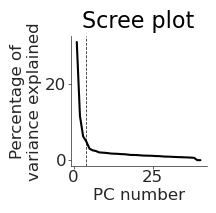

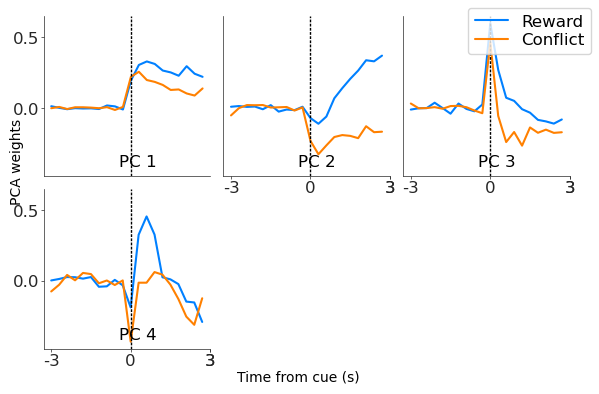

In [287]:
load_savedpca_or_dopca = 'dopca'
# Select 'dopca' for doing PCA on the data. Select 'savedpca' for loading my previous results

if load_savedpca_or_dopca == 'dopca':
    pca = PCA(n_components=populationdata.shape[1], whiten=True)
    pca.fit(populationdata) 
    with open(os.path.join(basedir, 'pcaresults.pickle'), 'wb') as f:
        pickle.dump(pca, f)
elif load_savedpca_or_dopca == 'savedpca':
    with open(os.path.join(basedir, 'OFCCaMKII_pcaresults.pickle'), 'rb') as f:
        pca = pickle.load(f)
    
transformed_data = pca.transform(populationdata)

pca_vectors = pca.components_
print ('Number of PCs = %d'%(pca_vectors.shape[0]))

x = 100*pca.explained_variance_ratio_
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
#xprime = (x - np.mean(x))/(np.max(x)-np.min(x))
num_retained_pcs =  np.argmin(xprime)#np.min(np.where(np.cumsum(x)>65))#np.argmin(xprime)
# Number of PCs to be kept is defined as the number at which the 
# scree plot bends. This is done by simply bending the scree plot
# around the line joining (1, variance explained by first PC) and
# (num of PCs, variance explained by the last PC) and finding the 
# number of components just below the minimum of this rotated plot
print ('Number of PCs to keep = %d'%(num_retained_pcs))

fig, ax = plt.subplots(figsize=(2,2))
ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
ax.set_ylabel('Percentage of\nvariance explained')
ax.set_xlabel('PC number')
ax.axvline(num_retained_pcs, linestyle='--', color='k', linewidth=0.5)
ax.set_title('Scree plot')
#ax.set_xlim([0,5])
[i.set_linewidth(0.5) for i in ax.spines.values()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(top=0.9)

colors_for_key = {}
colors_for_key[trial_types[0]] = (0,0.5,1)
colors_for_key[trial_types[1]] = (1,0.5,0)

numcols = 3.0
fig, axs = plt.subplots(int(np.ceil(num_retained_pcs/numcols)), int(numcols), sharey='all',
                        figsize=(2*numcols, 2*int(np.ceil(num_retained_pcs/numcols))))
for pc in range(num_retained_pcs):
    ax = axs.flat[pc]
    for k, tempkey in enumerate(trial_types):
        ax.plot(pca_vectors[pc, k*window_size:(k+1)*window_size], color=colors_for_key[tempkey],
                label='PC %d: %s'%(pc+1, tempkey))
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=1)
    ax.annotate(text='PC %d'%(pc+1), xy=(0.45, 0.06), xytext=(0.45, 0.06), xycoords='axes fraction',
            textcoords='axes fraction', multialignment='center', size='large')
    if pc >= num_retained_pcs-numcols:
        ax.set_xticks([0, pre_window_size,
                       pre_window_size + frames_to_reward, window_size])
        ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                             for a in [0, pre_window_size,
                                       pre_window_size + frames_to_reward, window_size]])
    else:
        ax.set_xticks([])
        ax.xaxis.set_ticks_position('none')
    if pc%numcols:
        ax.yaxis.set_ticks_position('none')
    [i.set_linewidth(0.5) for i in ax.spines.values()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


fig.text(0.5, 0.05, 'Time from cue (s)', horizontalalignment='center', rotation='horizontal')
fig.text(0.02, 0.6, 'PCA weights', verticalalignment='center', rotation='vertical')
fig.tight_layout()
fig.legend(trial_types,)
for ax in axs.flat[num_retained_pcs:]:
    ax.set_visible(False)

fig.subplots_adjust(wspace=0.08, hspace=0.08)
fig.subplots_adjust(bottom=0.13)

In [304]:
np.min(np.where(np.cumsum(x)>50))

3

## Perform clustering

Now, we have reduced the full dataset into a reduced dimensionality corresponding to the PCA subspace. 

Next, we will start the clustering. The approach we will use is Spectral Clustering. This is a pretty good method for dealing with high dimensional data. Note that even after PCA dimensionality reduction, there are 8 dimensions in this dataset. The choice of the method can affect the exact clustering results and there really is no "the best" algorithm. Thus, clustering is almost always the beginning of an investigation, rather than the end. In other words, the point of this clustering approach is not to say "There are 9 subpopulations of neurons in OFC for sure", but rather to test if these identified clusters can be mapped onto interesting features either in terms of their responses or in terms of their biological features (genes, anatomy etc).

The one issue with Spectral Clustering is that you have to pre-specify the number of clusters. However, there are ways to optimize this number by using metrics of "clusteredness". I use a common method: <a href="https://en.wikipedia.org/wiki/Silhouette_(clustering)">silhouette score</a>. The one caveat of this method you need to specify a minimum of two clusters. In my experience, when the data truly do not contain any clusters, the minimum of two clusters identified will be quite obviously similar to each other. When data visualization clearly shows that the identified "clusters" are similar in terms of responses, one should conclude that there are no clusters.

This is the fundamental issue with approaches such as clustering. In the end, there are strong subjective elements to it. However, when there truly are clusters in the data, it can be a powerful approach to uncovering such structure. In my case, I validated these identified clusters using two major approaches:

1. I found that the responses of neurons that were clustered on one day are stable on another day when the behavior is stable. Thus, the difference between clusters remains even on a cross-validation day.

2. Subpopulations of the output population studied here (e.g. OFC neurons projecting to VTA or NAc) comprise of only select clusters. This shows that specific types of responses are absent in specific downstream projections. Such a clear mapping of identified clusters to biology is a good indication that the clustering results are real.

In [289]:
max_n_clusters = 10 # Maximum number of clusters expected. I already ran this with up to 20 clusters and know
# that the optimal number is 9. So, I am leaving this at 11. In your data, might be worth increasing this, but
# it will take more time to run.

possible_n_clusters = np.arange(3, max_n_clusters+1) #This requires a minimum of 2 clusters.
# When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, 
# as the responses of the clusters will be quite similar. This will also be visible when plotting the data in
# the reduced dimensionality PC space (done below).


possible_n_nearest_neighbors = np.array([5, 10, 50, 80, 100, 200, 300]) #np.array([100, 500, 1000, 2000, 4000]) # This should be selected for each dataset
# appropriately. When 4813 neurons are present, the above number of nearest neighbors provides a good sweep of the
# parameter space. But it will need to be changed for other data.
    
silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    possible_n_nearest_neighbors.size))

for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
    for nnidx, nn in enumerate(possible_n_nearest_neighbors):
        model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=nn)
        model.fit(transformed_data[:,:num_retained_pcs])
        silhouette_scores[n_clustersidx, nnidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                                   model.labels_,
                                                                   metric='cosine')
        print ('Done with numclusters = %d, num nearest neighbors = %d: score = %.3f'%(n_clusters,
                                                                                      nn,
                                                                                      silhouette_scores[n_clustersidx,                                                                           
                                                                                                        nnidx]))

print ('Done with model fitting')

temp = {}
temp['possible_n_clusters'] = possible_n_clusters
temp['possible_n_nearest_neighbors'] = possible_n_nearest_neighbors
temp['silhouette_scores'] = silhouette_scores
temp['shape'] = 'cluster_nn'
with open(os.path.join(basedir, 'silhouette_scores.pickle'), 'wb') as f:
    pickle.dump(temp, f)

Done with numclusters = 3, num nearest neighbors = 5: score = 0.253
Done with numclusters = 3, num nearest neighbors = 10: score = 0.302
Done with numclusters = 3, num nearest neighbors = 50: score = 0.361
Done with numclusters = 3, num nearest neighbors = 80: score = 0.368
Done with numclusters = 3, num nearest neighbors = 100: score = 0.366
Done with numclusters = 3, num nearest neighbors = 200: score = 0.310
Done with numclusters = 3, num nearest neighbors = 300: score = 0.156
Done with numclusters = 4, num nearest neighbors = 5: score = 0.293
Done with numclusters = 4, num nearest neighbors = 10: score = 0.322
Done with numclusters = 4, num nearest neighbors = 50: score = 0.380
Done with numclusters = 4, num nearest neighbors = 80: score = 0.391
Done with numclusters = 4, num nearest neighbors = 100: score = 0.393
Done with numclusters = 4, num nearest neighbors = 200: score = 0.346
Done with numclusters = 4, num nearest neighbors = 300: score = 0.115
Done with numclusters = 5, num

Next, we will reorder the cluster labels such that there is a fixed order for naming the clusters. This is important because if you run the previous code multiple times, it will return different orders for the cluster labels.

In [291]:
with open(os.path.join(basedir, 'silhouette_scores.pickle'), 'rb') as f:
    silhouette_scores = pickle.load(f)
    
transformed_data = transformed_data #np.load(os.path.join(basedir, 'OFCCaMKII_transformed_data.npy'))

# Identify optimal parameters from the above parameter space
temp = np.where(silhouette_scores['silhouette_scores']==np.nanmax(silhouette_scores['silhouette_scores']))
n_clusters = silhouette_scores['possible_n_clusters'][temp[0][0]]
n_nearest_neighbors = silhouette_scores['possible_n_nearest_neighbors'][temp[1][0]]

print (n_clusters, n_nearest_neighbors)

# Redo clustering with these optimal parameters
model = SpectralClustering(n_clusters=n_clusters,
                           affinity='nearest_neighbors',
                           n_neighbors=n_nearest_neighbors)

# model = KMeans(n_clusters=n_clusters)

# model = AgglomerativeClustering(n_clusters=9,
#                                 affinity='l1',
#                                 linkage='average')

model.fit(transformed_data[:,:num_retained_pcs])

temp = silhouette_score(transformed_data[:,:num_retained_pcs], model.labels_, metric='cosine')

print ('Number of clusters = %d, average silhouette = %.3f'%(len(set(model.labels_)), temp))

# Save this optimal clustering model.
# with open(os.path.join(basedir, 'clusteringmodel.pickle'), 'wb') as f:
#     pickle.dump(model, f)

          
# Since the clustering labels are arbitrary, I rename the clusters so that the first cluster will have the most
# positive response and the last cluster will have the most negative response.
def reorder_clusters(rawlabels):
    uniquelabels = list(set(rawlabels))
    responses = np.nan*np.ones((len(uniquelabels),))
    for l, label in enumerate(uniquelabels):
        responses[l] = np.mean(populationdata[rawlabels==label, pre_window_size:2*pre_window_size])
    temp = np.argsort(responses).astype(int)[::-1]
    temp = np.array([np.where(temp==a)[0][0] for a in uniquelabels])
    outputlabels = np.array([temp[a] for a in list(np.digitize(rawlabels, uniquelabels)-1)])
    return outputlabels
newlabels = reorder_clusters(model.labels_)

# Create a new variable containing all unique cluster labels
uniquelabels = list(set(newlabels))

# np.save(os.path.join(basedir, 'OFCCaMKII_clusterlabels.npy'), newlabels)

colors_for_cluster = [[0.933, 0.250, 0.211],
                      [0.941, 0.352, 0.156],
                      [0.964, 0.572, 0.117],
                      [0.980, 0.686, 0.250],
                      [0.545, 0.772, 0.247],
                      [0.215, 0.701, 0.290],
                      [0, 0.576, 0.270],
                      [0, 0.650, 0.611],
                      [0.145, 0.662, 0.878]]

5 100
Number of clusters = 5, average silhouette = 0.395


Make a silhouette plot to visualize clustering quality. The average silhouette score above is the mean of all sample silhouettes. There are two other clustering methods commented out above (KMeans and agglomerative). One can see that if you apply those methods, the average silhouette score is lower, demonstrating that those methods are worse for these data. This also then shows that the high dimensional geometry for these data is unlikely to be a simple Gaussian structure, as these other methods are specialized for picking up Gaussian clusters. Spectral clustering is effective as it can uncover peculiarly shaped clusters

In [292]:
def make_silhouette_plot(X, cluster_labels):
    
    n_clusters = len(set(cluster_labels))
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels, metric='cosine')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric='cosine')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors_for_cluster[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.9)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

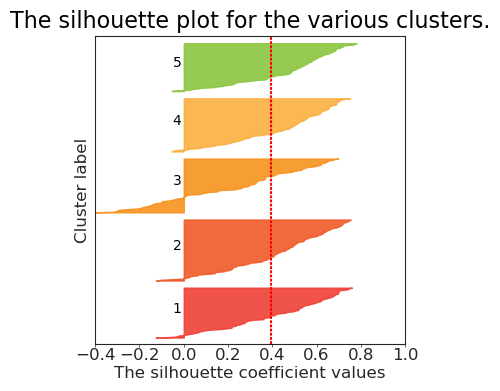

In [293]:
make_silhouette_plot(transformed_data[:,:num_retained_pcs], model.labels_)

The average silhouette coefficient is about 0.2. As a general rule, this is a fairly low clustering quality index. However, if the range of spread of the data in the high dimensional space is fixed, silhouette score will necessarily be lower when there are many clusters in the data. Thus, this silhouette cannot by itself be used to argue against clustering in these data. This is why the clustering quality in this case needs to be verified through other means, such as projection specificity or response stability for clusters.

The neurons with negative silhouette scores are assigned to the wrong cluster. So one possible approach could be to run clustering multiple times (it's stochastic) and only select neurons that are reliably assigned to their corresponding cluster. This will improve cluster-wise inference for other analyses. However, I wanted to keep the analysis simpler and hence, decided not to do such filtering.

Plot the identified clusters. This plot is a good comparison to the original plot of the data, which did not cluster the data

/tmp/ipykernel_3564623/3979681761.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


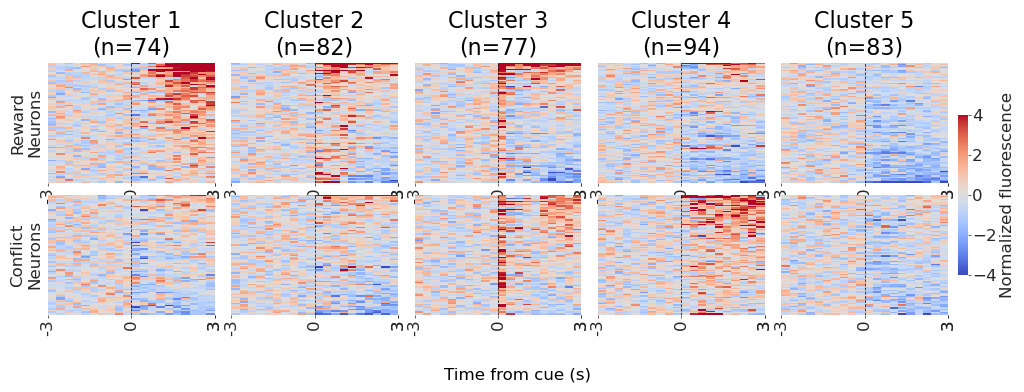

In [294]:
cmax = 4
sortwindow = [15, 100]

fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(trial_types)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numroisincluster = np.nan*np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels==cluster)[0], k*window_size:(k+1)*window_size]
        numroisincluster[c] = temp.shape[0]
        sortresponse = np.argsort(np.mean(temp[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
        sns.heatmap(temp[sortresponse],
                    ax=axs[k, cluster],
                    cmap=plt.get_cmap('coolwarm'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence'})
        axs[k, cluster].grid(False)
        if k==len(trial_types)-1:
            axs[k, cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[k, cluster].set_xticks([])
        axs[k, cluster].tick_params(width=0.5)
        axs[k, cluster].set_xticks([0, pre_window_size,
                            pre_window_size + frames_to_reward, window_size])

        axs[k, cluster].set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                         for a in [0, pre_window_size,
                                                   pre_window_size + frames_to_reward, window_size]])
        axs[k, cluster].set_yticks([])
        axs[k, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[k, cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster==0:
            axs[k, 0].set_ylabel('%s\nNeurons'%(tempkey))
    axs[0, cluster].set_title('Cluster %d\n(n=%d)'%(cluster+1, numroisincluster[c]))
    
fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

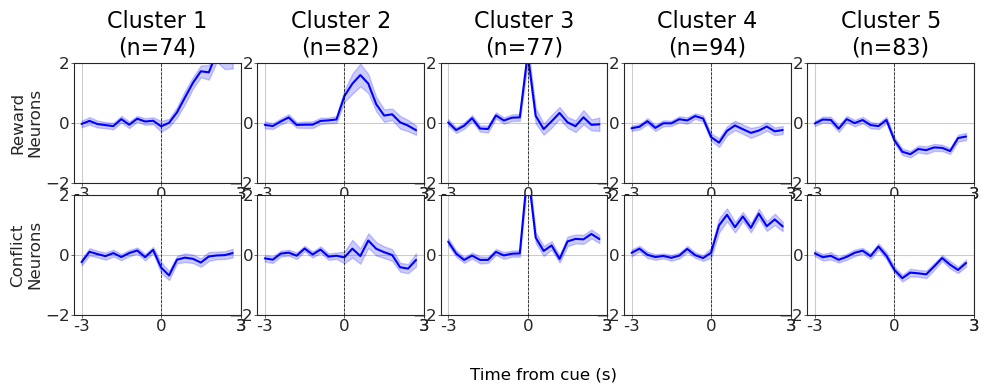

In [295]:
cmax = 4
sortwindow = [15, 100]

#fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
#                        figsize=(2*len(uniquelabels),2*len(trial_types)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 


fig, axs = plt.subplots(len(trial_types), len(uniquelabels),
                        figsize=(2 * len(uniquelabels), 2 * len(trial_types)))

numroisincluster = np.nan * np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels == cluster)[0], k * window_size:(k + 1) * window_size]
        numroisincluster[c] = temp.shape[0]

        # Calculate mean and standard deviation
        mean_temp = np.mean(temp, axis=0)
        std_temp = np.std(temp, axis=0)/np.sqrt(len(temp))

        # Plot the mean line
        axs[k, cluster].plot(mean_temp, label='Mean', color='blue')
        # Fill the area between mean ± std with a transparent color
        axs[k, cluster].fill_between(range(len(mean_temp)), mean_temp - std_temp, mean_temp + std_temp,
                                     color='blue', alpha=0.2, label='Std')

        axs[k, cluster].grid(True)
        if k == len(trial_types) - 1:
            axs[k, cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[k, cluster].set_xticks([])

        axs[k, cluster].tick_params(width=0.5)
        axs[k, cluster].set_xticks([0, pre_window_size,
                                     pre_window_size + frames_to_reward, window_size])

        axs[k, cluster].set_xticklabels([str(int((a - pre_window_size + 0.0) / framerate))
                                          for a in [0, pre_window_size,
                                                    pre_window_size + frames_to_reward, window_size]])
        #axs[k, cluster].set_yticks()
        axs[k, cluster].set_ylim(-2,2)
        axs[k, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[k, cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster == 0:
            axs[k, 0].set_ylabel('%s\nNeurons' % (tempkey))
    axs[0, cluster].set_title('Cluster %d\n(n=%d)' % (cluster + 1, numroisincluster[c]))

fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
#fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

plt.show()


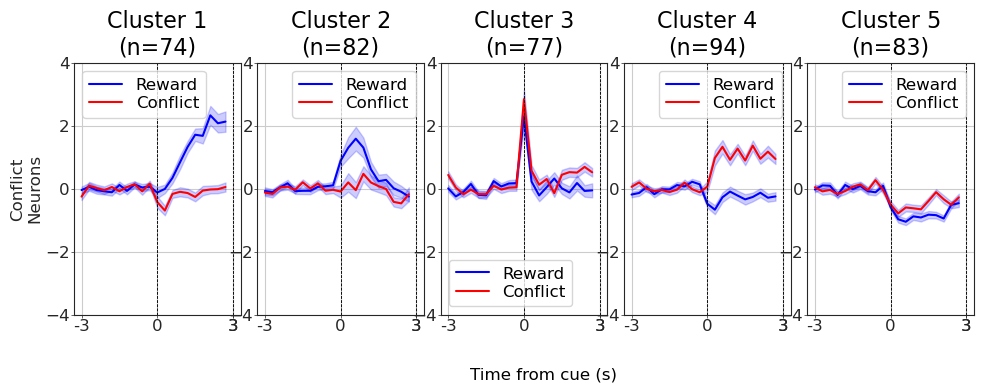

In [296]:
cmax = 4
sortwindow = [15, 100]

#fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
#                        figsize=(2*len(uniquelabels),2*len(trial_types)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 


fig, axs = plt.subplots(1, len(uniquelabels),
                        figsize=(2 * len(uniquelabels), 2 * len(trial_types)))

numroisincluster = np.nan * np.ones((len(uniquelabels),))

colors = ['blue', 'red']
trials = trial_types

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels == cluster)[0], k * window_size:(k + 1) * window_size]
        numroisincluster[c] = temp.shape[0]

        # Calculate mean and standard deviation
        mean_temp = np.mean(temp, axis=0)
        std_temp = np.std(temp, axis=0)/np.sqrt(len(temp))

        # Plot the mean line
        axs[cluster].plot(mean_temp, label= trials[k], color= colors[k])
        # Fill the area between mean ± std with a transparent color
        axs[cluster].fill_between(range(len(mean_temp)), mean_temp - std_temp, mean_temp + std_temp,
                                     color='blue', alpha=0.2)

        axs[cluster].grid(True)
        if k == len(trial_types) - 1:
            axs[cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[cluster].set_xticks([])

        axs[cluster].tick_params(width=0.5)
        axs[cluster].set_xticks([0, pre_window_size,
                                     pre_window_size + frames_to_reward, window_size])

        axs[cluster].set_xticklabels([str(int((a - pre_window_size + 0.0) / framerate))
                                          for a in [0, pre_window_size,
                                                    pre_window_size + frames_to_reward, window_size]])
        #axs[k, cluster].set_yticks()
        axs[cluster].set_ylim(-4,4)
        axs[cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster == 0:
            axs[0].set_ylabel('%s\nNeurons' % (tempkey))
    axs[cluster].set_title('Cluster %d\n(n=%d)' % (cluster + 1, numroisincluster[c]))
    axs[cluster].legend()

fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
#fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

plt.show()


Based on the responses of these identified clusters, the data do indeed look consistent with clustering. This is because the activity of neurons within a cluster look quite similar while activity across clusters looks quite different. As a further validation of the clustering, I will plot each neuron separated by clusters in the PCA space within which clustering was done.

Since there are 8 dimensions in the PCA space, I will use tSNE to reduce the dimensionality of this space to a 2D space. I will plot the tSNE transformation of the PCA scores of each pair of cluster against each other. If there are actually no real clusters, this plot will make it super clear. In this case, the default identified number of clusters will be two and in this plot, the two clusters will look like they belong to the same blob with an arbitrary line separating them. Instead, if there are real clusters, you will see different clusters forming different blobs when plotted against each other. 

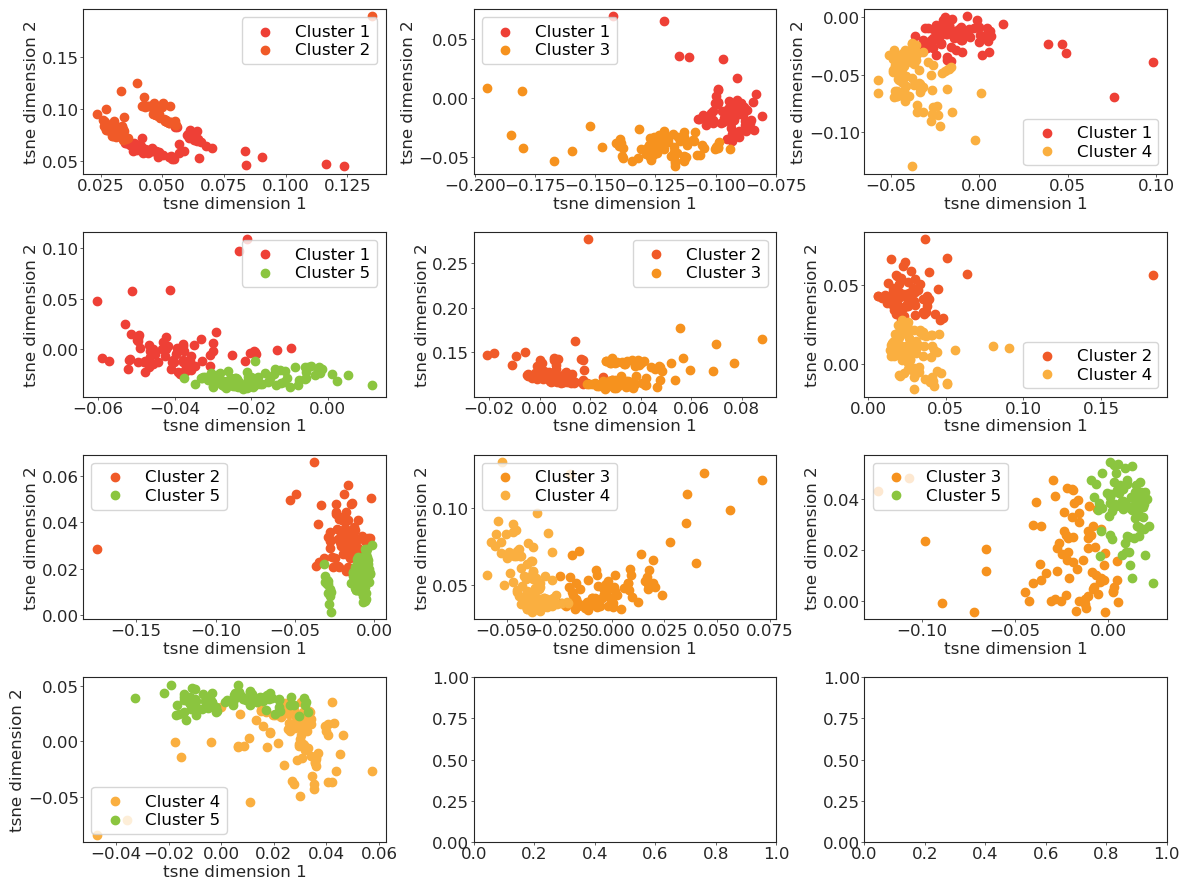

In [297]:
num_clusterpairs = len(uniquelabels)*(len(uniquelabels)-1)/2

numrows = int(np.ceil(num_clusterpairs**0.5))
numcols = int(np.ceil(num_clusterpairs/np.ceil(num_clusterpairs**0.5)))
fig, axs = plt.subplots(numrows, numcols, figsize=(3*numrows, 3*numcols))

tempsum = 0
for c1, cluster1 in enumerate(uniquelabels):
    for c2, cluster2 in enumerate(uniquelabels):
        if cluster1>=cluster2:
            continue
        temp1 = transformed_data[np.where(newlabels==cluster1)[0], :num_retained_pcs]
        temp2 = transformed_data[np.where(newlabels==cluster2)[0], :num_retained_pcs]
        X = np.concatenate((temp1, temp2), axis=0)
        tsne = TSNE(n_components=2, init='random',
                    random_state=0, perplexity=X.shape[0]-1)
        Y = tsne.fit_transform(X)
        if numrows * numcols == 1:
            ax = axs
        else:
            ax = axs[tempsum // numcols, tempsum - (tempsum // numcols) * numcols]


        ax.scatter(Y[:np.sum(newlabels==cluster1),0],
                   Y[:np.sum(newlabels==cluster1),1],
                   color=colors_for_cluster[cluster1], label='Cluster %d'%(cluster1+1), alpha=1)
        ax.scatter(Y[np.sum(newlabels==cluster1):,0],
                   Y[np.sum(newlabels==cluster1):,1],
                   color=colors_for_cluster[cluster2], label='Cluster %d'%(cluster2+1), alpha=1)

        ax.set_xlabel('tsne dimension 1')
        ax.set_ylabel('tsne dimension 2')
        ax.legend()
        tempsum += 1
fig.tight_layout()

In [298]:
all_cells = Reward.reset_index().iloc[:,:2]

# Perform a left join on 'Animal_ID' and 'Unit_ID' columns
merged = all_cells.merge(PhotoTag, on=['Animal_ID', 'Unit_id'], how='left')

# Fill missing values in the 'Unit_Type' column with 'unidentified'
merged['Unit_Type'] = merged['Unit_Type'].fillna('Unidentified')
merged['Cluster'] = newlabels+1

# Check the resulting DataFrame
print(merged)


    Unit_id Animal_ID     Unit_Type  Cluster
0    SPK04a       3P4        PL-NAc        1
1    SPK07a       3P4  Unidentified        2
2    SPK07b       3P4  Unidentified        3
3    SPK08a       3P4  Unidentified        2
4    SPK09a       3P4  Unidentified        2
..      ...       ...           ...      ...
405  SPK28a       5A4  Unidentified        5
406  SPK30a       5A4  Unidentified        3
407  SPK20a       5U5  Unidentified        3
408  SPK28a       5U5  Unidentified        2
409  SPK28b       5U5  Unidentified        2

[410 rows x 4 columns]


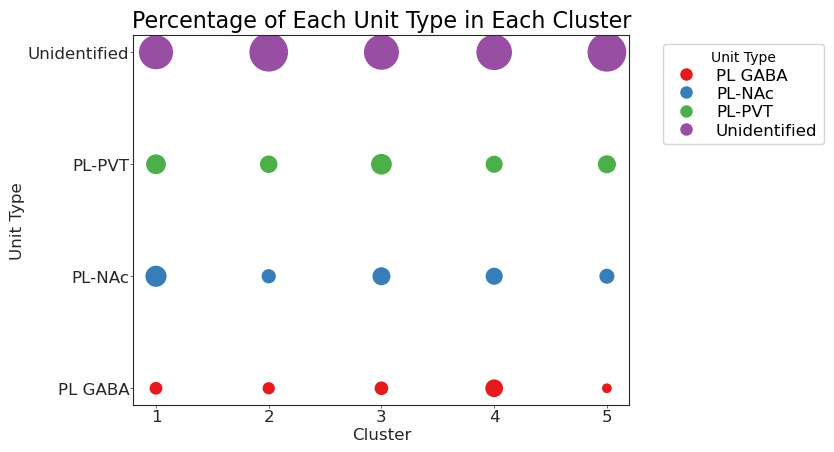

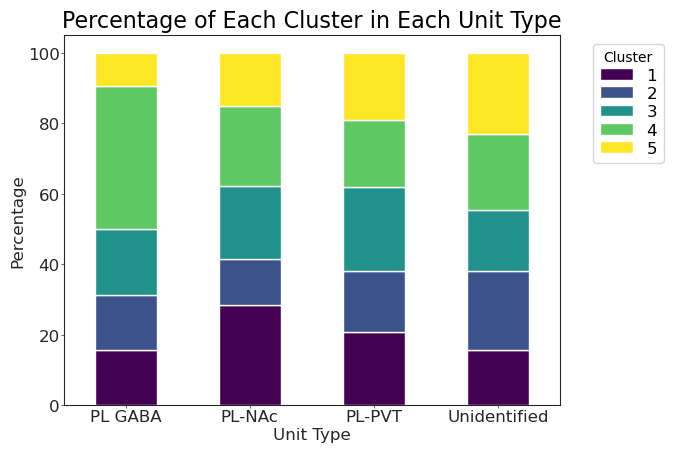

In [299]:

# Calculate the percentage of each unit type in each cluster
cluster_unit_type_counts = merged.groupby(['Cluster', 'Unit_Type']).size().unstack(fill_value=0)
cluster_unit_type_perc = cluster_unit_type_counts.div(cluster_unit_type_counts.sum(axis=1), axis=0)

# Calculate the percentage of each cluster in each unit type
unit_type_cluster_counts = merged.groupby(['Unit_Type', 'Cluster']).size().unstack(fill_value=0)
unit_type_cluster_perc = unit_type_cluster_counts.div(unit_type_cluster_counts.sum(axis=1), axis=0)*100

# Get the Pastel2 colormap
cmap = cm.get_cmap('Set1')

# Plot the percentage of each unit type in each cluster using a scatter plot
fig, ax = plt.subplots()
for i, unit_type in enumerate(cluster_unit_type_perc.columns):
    ax.scatter(cluster_unit_type_perc.index, [unit_type] * len(cluster_unit_type_perc), s=cluster_unit_type_perc[unit_type] * 1000, c =[cmap(i)])

ax.set_xticks(cluster_unit_type_perc.index)
ax.set_yticks(range(0, len(cluster_unit_type_perc.columns)))
ax.set_yticklabels(cluster_unit_type_perc.columns)

ax.set_xlabel('Cluster')
ax.set_ylabel('Unit Type')
ax.set_title('Percentage of Each Unit Type in Each Cluster')

# Create a proxy artist for the legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=unit_type, markerfacecolor=cmap(i), markersize=10) for i, unit_type in enumerate(cluster_unit_type_perc.columns)]
ax.legend(handles=legend_elements, title="Unit Type", bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot the percentage of each cluster in each unit type using a stacked histogram
fig, ax = plt.subplots()
unit_type_cluster_perc.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')

ax.set_xticklabels(unit_type_cluster_perc.index, rotation=0)
ax.set_xlabel('Unit Type')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Each Cluster in Each Unit Type')
ax.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [300]:
unit_type_cluster_counts

Cluster        1   2   3   4   5
Unit_Type                       
PL GABA        5   5   6  13   3
PL-NAc        15   7  11  12   8
PL-PVT        13  11  15  12  12
Unidentified  41  59  45  57  60

In [301]:
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(unit_type_cluster_perc.loc[["PL-NAc","PL-PVT"]])

print(f"Chi-square statistic = {chi2}")
print(f"P-value = {p}")
print(f"Degrees of freedom = {dof}")
print("Expected:")
print(expected)

Chi-square statistic = 2.7678973041241255
P-value = 0.5973868164502383
Degrees of freedom = 4
Expected:
[[24.46840371 15.33393232 22.2821204  20.84456424 17.07097934]
 [24.46840371 15.33393232 22.2821204  20.84456424 17.07097934]]


In [302]:
# calculate standardized residuals
residuals = (unit_type_cluster_perc.loc[["PL-NAc","PL-PVT"]] - expected) / np.sqrt(expected)

print("Standardized Residuals:")
print(residuals)

Standardized Residuals:
Cluster          1         2         3         4         5
Unit_Type                                                 
PL-NAc     0.77498 -0.543019 -0.323575  0.393585 -0.478408
PL-PVT    -0.77498  0.543019  0.323575 -0.393585  0.478408


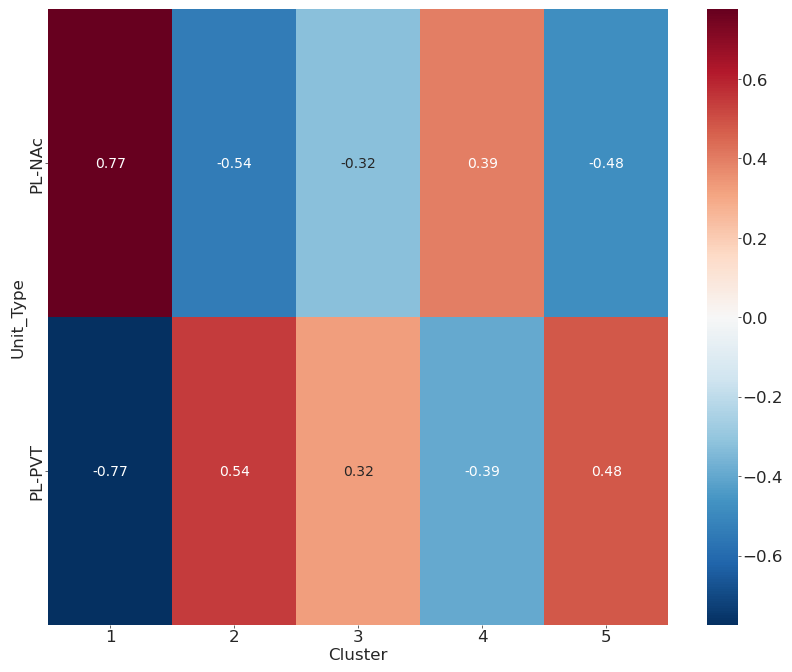

In [303]:
plt.figure(figsize=(10, 8))
sns.heatmap(residuals, annot=True, cmap='RdBu_r')
plt.show()

In [286]:
from statsmodels.stats.proportion import proportions_ztest

# Assuming these are your counts for a specific cluster in two groups
count = np.array([unit_type_cluster_counts.loc['PL-NAc', [2,6]].sum(), unit_type_cluster_counts.loc['PL-PVT', [2,6]].sum()])

# Assuming these are the number of observations in the two groups
nobs = np.array([unit_type_cluster_counts.loc['PL-NAc', :].sum(), unit_type_cluster_counts.loc['PL-PVT', :].sum()])

# Perform the test
stat, pval = proportions_ztest(count, nobs)
print(f'z-statistic = {stat}')
print(f'p-value = {pval}')


z-statistic = -1.471481697672622
p-value = 0.14116089359139766


## 6s before and after normalized to 6s before

In [321]:
# Load the csv file with cross timepoints
interval_data = pd.read_csv(os.path.join(base_dir,"Trial by Trial Cues.csv"), header = 1)
photoid = pd.read_csv(os.path.join(base_dir,"Phototag ID's.csv"), index_col =0)

In [322]:
photoid.index = ["Unit", "PL GABA", "PL-PVT", "PL-NAc"]

In [323]:
photoid

1U1 Unnamed: 2 Unnamed: 3 Unnamed: 4 Unnamed: 5 Unnamed: 6  \
Unit     SPK01a     SPK02a     SPK08a     SPK09a     SPK12a     SPK24a   
PL GABA       0          0          0          0          0          0   
PL-PVT        0          0          0          0          0          0   
PL-NAc        0          0          0          0          0          0   

        Unnamed: 7 Unnamed: 8     9L1 Unnamed: 10  ... Unnamed: 404     1D6  \
Unit        SPK25a     SPK26a  SPK23a      SPK26a  ...       SPK30a  SPK02a   
PL GABA          0          0       0           0  ...            0       0   
PL-PVT           0          0       0           0  ...            0       0   
PL-NAc           0          0       0           0  ...            1       0   

        Unnamed: 406 Unnamed: 407 Unnamed: 408 Unnamed: 409 Unnamed: 410  \
Unit          SPK03a       SPK06a       SPK13a       SPK14a       SPK16a   
PL GABA            0            0            0            0            0   
PL-PVT             0            0            0            0            0   
PL-NAc             1            0            1            0            1   

        Unnamed: 411 Unnamed: 412 Unnamed: 413  
Unit          SPK21a       SPK29a       SPK30a  
PL GABA            0            0            0  
PL-PVT             0            0            0  
PL-NAc             0            1            1  

[4 rows x 413 columns]

In [324]:
PhotoTag = pd.DataFrame(columns=['Animal_ID', 'Unit_id', 'Unit_Type'])

photoid = photoid.reset_index()
# Iterate over the columns in the input DataFrame
current_animal_id = None
for col in photoid.columns[1:]:
    if 'Unnamed' not in col:
        current_animal_id = col
    for row_idx in range(1, photoid.shape[0]):
        unit_id = photoid.loc[0, col]
        unit_type = photoid.loc[row_idx, 'index']
        value = photoid.loc[row_idx, col]

        if value == "1":
            new_row = pd.DataFrame({'Animal_ID': [current_animal_id], 'Unit_id': [unit_id], 'Unit_Type': [unit_type]})
            PhotoTag = pd.concat([PhotoTag, new_row], ignore_index=True)

    # Check if the current column has all 0s
    if pd.to_numeric(photoid.loc[1:, col], errors='coerce').sum() == 0:
        new_row = pd.DataFrame({'Animal_ID': [current_animal_id], 'Unit_id': [unit_id], 'Unit_Type': ['Unidentified']})
        PhotoTag = pd.concat([PhotoTag, new_row], ignore_index=True)


In [325]:
basedir = './' # folder containing code and data
Reward = pd.read_csv(os.path.join(basedir, 'Reward_6s_z_6s.csv'), index_col = 0)
Conflict = pd.read_csv(os.path.join(basedir, 'Conflict_6s_z_6s.csv'), index_col = 0)
reward = Reward.iloc[:,1:].to_numpy()
conflict = Conflict.iloc[:,1:].to_numpy()

TimeRange = 12.3
TotalBins = int(TimeRange/BinSize)

populationdata = np.concatenate([reward,conflict],axis =1)

In [326]:
Reward = Reward[~np.any(np.isnan(populationdata), axis=1)]
PhotoTag = PhotoTag[~np.any(np.isnan(populationdata), axis=1)]
populationdata = populationdata[~np.any(np.isnan(populationdata), axis=1)]

In [327]:
populationdata.flatten().max()

26.609208932247498

(array([5.4800e+02, 2.6773e+04, 6.2230e+03, 1.7100e+02, 4.8000e+01,
        1.2000e+01, 5.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([-5.39292155, -2.1927085 ,  1.00750455,  4.2077176 ,  7.40793064,
        10.60814369, 13.80835674, 17.00856979, 20.20878284, 23.40899588,
        26.60920893]),
 <BarContainer object of 10 artists>)

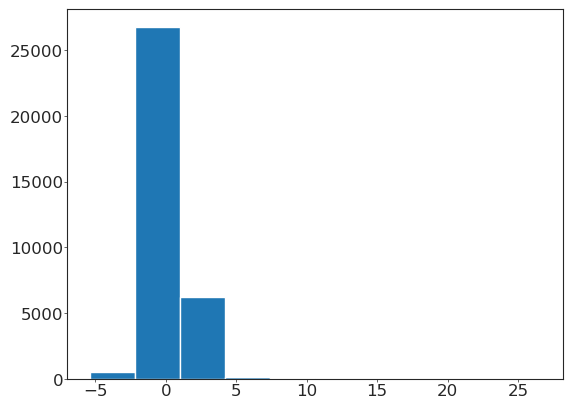

In [328]:
plt.hist(populationdata.flatten())

Now, we will visualize the full dataset to get a sense of what they look like. As mentioned previously, the first 100 features correspond to CS+ responses and the last 100 features correspond to CS- responses. So I will plot both trial types separately.

In [329]:
populationdata.shape

(412, 82)

<AxesSubplot:>

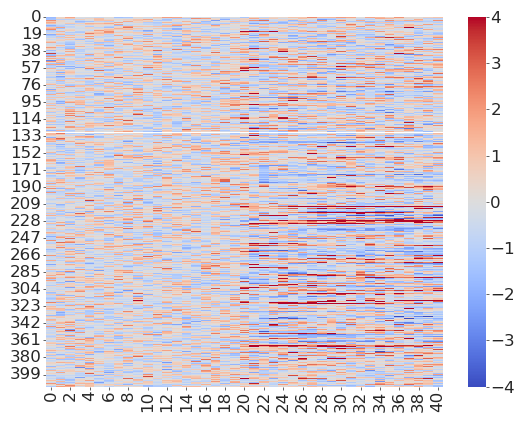

In [330]:
cmax = 4 # Maximum colormap value. 
cmin = -4
sns.heatmap(reward,
                cmap=plt.get_cmap('coolwarm'),
                vmin=cmin,
                vmax=cmax)

In [331]:
framerate = 1/BinSize
pre_window_size = int(0.5*TimeRange*framerate) # 3 seconds multipled by 5 frames. Corresponds to baseline prior to cues.
window_size = TotalBins # Total number of frames plotted around a cue
frames_to_reward = TotalBins - int(0.5*TimeRange*framerate) # 3 seconds until reward after CS+

sortwindow = [pre_window_size, pre_window_size + frames_to_reward] # Sort responses between CS+ onset and reward.
sortresponse = np.argsort(np.mean(populationdata[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
# sortresponse corresponds to an ordering of the neurons based on their average response in the sortwindow

cmax = 4 # Maximum colormap value. 
cmin = -4

trial_types = ['Reward', 'Conflict']

/tmp/ipykernel_3564623/896160079.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


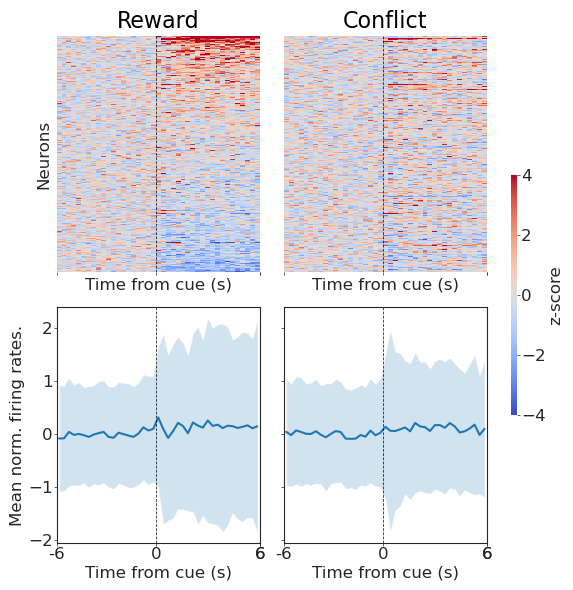

In [332]:
fig, axs = plt.subplots(2,2,figsize=(3*2,3*2), sharex='all', sharey='row')
cbar_ax = fig.add_axes([0.86, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

def tsplot(ax, data,**kw):
    x = np.arange(window_size)
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    ax.fill_between(x+0.5,cis[0],cis[1], alpha=0.2, **kw)
    ax.plot(x+0.5,est,**kw)
    ax.margins(x=0)


for t in range(len(trial_types)):
    axs[0,t].set_title(trial_types[t])
    ax = axs[0,t]
    sns.heatmap(populationdata[sortresponse, t*window_size: (t+1)*window_size],
                ax=ax,
                cmap=plt.get_cmap('coolwarm'),
                vmin=cmin,
                vmax=cmax,
                cbar=(t==0),
                cbar_ax=cbar_ax if (t==0) else None,
                cbar_kws={'label': 'z-score'})
    ax.grid(False)
    ax.tick_params(width=0.5)   
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])
    ax.set_yticks([])
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    
        
    ax = axs[1,t]
    tsplot(ax, populationdata[sortresponse, t*window_size:(t+1)*window_size])
    ax.set_xticks(np.arange(0, window_size + 1, frames_to_reward))
    ax.set_xticklabels([str(int((a - pre_window_size) / framerate)) for a in np.arange(0, window_size + 1, frames_to_reward)])

    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])

axs[0,0].set_ylabel('Neurons')
axs[1,0].set_ylabel('Mean norm. firing rates.')

fig.tight_layout()
fig.subplots_adjust(right=0.82)

/tmp/ipykernel_3564623/896160079.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


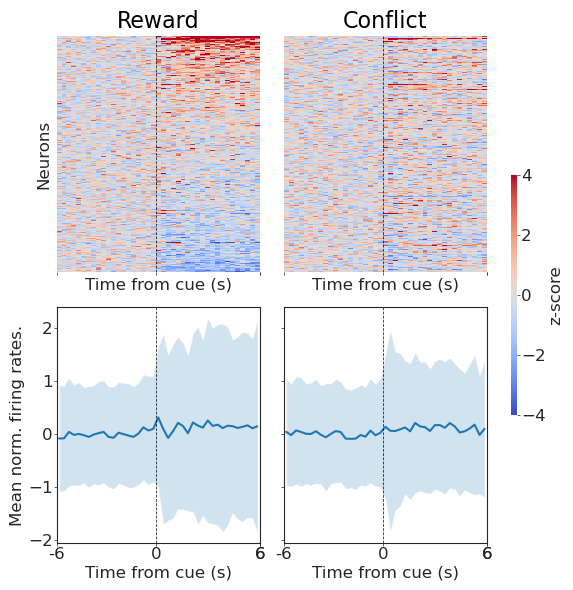

In [333]:
fig, axs = plt.subplots(2,2,figsize=(3*2,3*2), sharex='all', sharey='row')
cbar_ax = fig.add_axes([0.86, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

def tsplot(ax, data,**kw):
    x = np.arange(window_size)
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    ax.fill_between(x+0.5,cis[0],cis[1], alpha=0.2, **kw)
    ax.plot(x+0.5,est,**kw)
    ax.margins(x=0)


for t in range(len(trial_types)):
    axs[0,t].set_title(trial_types[t])
    ax = axs[0,t]
    sns.heatmap(populationdata[sortresponse, t*window_size: (t+1)*window_size],
                ax=ax,
                cmap=plt.get_cmap('coolwarm'),
                vmin=cmin,
                vmax=cmax,
                cbar=(t==0),
                cbar_ax=cbar_ax if (t==0) else None,
                cbar_kws={'label': 'z-score'})
    ax.grid(False)
    ax.tick_params(width=0.5)   
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])
    ax.set_yticks([])
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    
        
    ax = axs[1,t]
    tsplot(ax, populationdata[sortresponse, t*window_size:(t+1)*window_size])
    ax.set_xticks(np.arange(0, window_size + 1, frames_to_reward))
    ax.set_xticklabels([str(int((a - pre_window_size) / framerate)) for a in np.arange(0, window_size + 1, frames_to_reward)])

    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])

axs[0,0].set_ylabel('Neurons')
axs[1,0].set_ylabel('Mean norm. firing rates.')

fig.tight_layout()
fig.subplots_adjust(right=0.82)

Including all 200 response features per neuron makes the feature space quite large. So, let us first reduce the dimensionality of this space using Principal Component Analysis

Number of PCs = 82
Number of PCs to keep = 8


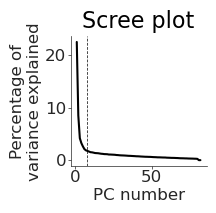

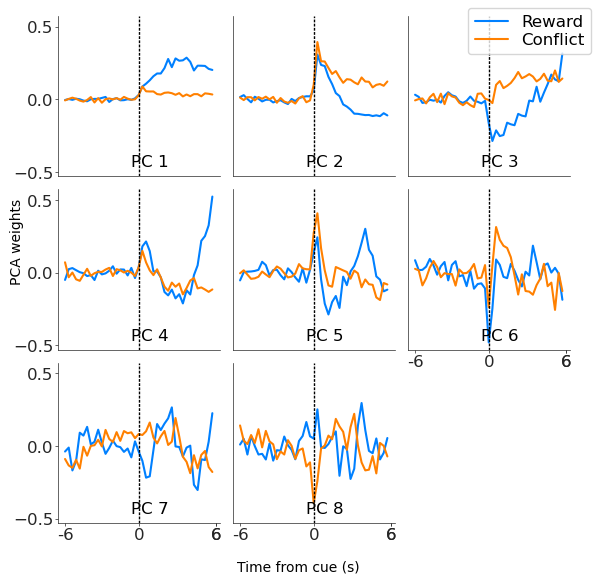

In [358]:
load_savedpca_or_dopca = 'dopca'
# Select 'dopca' for doing PCA on the data. Select 'savedpca' for loading my previous results

if load_savedpca_or_dopca == 'dopca':
    pca = PCA(n_components=populationdata.shape[1], whiten=True)
    pca.fit(populationdata) 
    with open(os.path.join(basedir, 'pcaresults.pickle'), 'wb') as f:
        pickle.dump(pca, f)
elif load_savedpca_or_dopca == 'savedpca':
    with open(os.path.join(basedir, 'OFCCaMKII_pcaresults.pickle'), 'rb') as f:
        pca = pickle.load(f)
    
transformed_data = pca.transform(populationdata)

pca_vectors = pca.components_
print ('Number of PCs = %d'%(pca_vectors.shape[0]))

x = 100*pca.explained_variance_ratio_
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
#xprime = (x - np.mean(x))/(np.max(x)-np.min(x))
num_retained_pcs = 8 #np.min(np.where(np.cumsum(x)>50)) #np.argmin(xprime)
# Number of PCs to be kept is defined as the number at which the 
# scree plot bends. This is done by simply bending the scree plot
# around the line joining (1, variance explained by first PC) and
# (num of PCs, variance explained by the last PC) and finding the 
# number of components just below the minimum of this rotated plot
print ('Number of PCs to keep = %d'%(num_retained_pcs))

fig, ax = plt.subplots(figsize=(2,2))
ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
ax.set_ylabel('Percentage of\nvariance explained')
ax.set_xlabel('PC number')
ax.axvline(num_retained_pcs, linestyle='--', color='k', linewidth=0.5)
ax.set_title('Scree plot')
#ax.set_xlim([0,5])
[i.set_linewidth(0.5) for i in ax.spines.values()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(top=0.9)

colors_for_key = {}
colors_for_key[trial_types[0]] = (0,0.5,1)
colors_for_key[trial_types[1]] = (1,0.5,0)

numcols = 3.0
fig, axs = plt.subplots(int(np.ceil(num_retained_pcs/numcols)), int(numcols), sharey='all',
                        figsize=(2*numcols, 2*int(np.ceil(num_retained_pcs/numcols))))
for pc in range(num_retained_pcs):
    ax = axs.flat[pc]
    for k, tempkey in enumerate(trial_types):
        ax.plot(pca_vectors[pc, k*window_size:(k+1)*window_size], color=colors_for_key[tempkey],
                label='PC %d: %s'%(pc+1, tempkey))
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=1)
    ax.annotate(text='PC %d'%(pc+1), xy=(0.45, 0.06), xytext=(0.45, 0.06), xycoords='axes fraction',
            textcoords='axes fraction', multialignment='center', size='large')
    if pc >= num_retained_pcs-numcols:
        ax.set_xticks([0, pre_window_size,
                       pre_window_size + frames_to_reward, window_size])
        ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                             for a in [0, pre_window_size,
                                       pre_window_size + frames_to_reward, window_size]])
    else:
        ax.set_xticks([])
        ax.xaxis.set_ticks_position('none')
    if pc%numcols:
        ax.yaxis.set_ticks_position('none')
    [i.set_linewidth(0.5) for i in ax.spines.values()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


fig.text(0.5, 0.05, 'Time from cue (s)', horizontalalignment='center', rotation='horizontal')
fig.text(0.02, 0.6, 'PCA weights', verticalalignment='center', rotation='vertical')
fig.tight_layout()
fig.legend(trial_types,)
for ax in axs.flat[num_retained_pcs:]:
    ax.set_visible(False)

fig.subplots_adjust(wspace=0.08, hspace=0.08)
fig.subplots_adjust(bottom=0.13)

## Perform clustering

Now, we have reduced the full dataset into a reduced dimensionality corresponding to the PCA subspace. 

Next, we will start the clustering. The approach we will use is Spectral Clustering. This is a pretty good method for dealing with high dimensional data. Note that even after PCA dimensionality reduction, there are 8 dimensions in this dataset. The choice of the method can affect the exact clustering results and there really is no "the best" algorithm. Thus, clustering is almost always the beginning of an investigation, rather than the end. In other words, the point of this clustering approach is not to say "There are 9 subpopulations of neurons in OFC for sure", but rather to test if these identified clusters can be mapped onto interesting features either in terms of their responses or in terms of their biological features (genes, anatomy etc).

The one issue with Spectral Clustering is that you have to pre-specify the number of clusters. However, there are ways to optimize this number by using metrics of "clusteredness". I use a common method: <a href="https://en.wikipedia.org/wiki/Silhouette_(clustering)">silhouette score</a>. The one caveat of this method you need to specify a minimum of two clusters. In my experience, when the data truly do not contain any clusters, the minimum of two clusters identified will be quite obviously similar to each other. When data visualization clearly shows that the identified "clusters" are similar in terms of responses, one should conclude that there are no clusters.

This is the fundamental issue with approaches such as clustering. In the end, there are strong subjective elements to it. However, when there truly are clusters in the data, it can be a powerful approach to uncovering such structure. In my case, I validated these identified clusters using two major approaches:

1. I found that the responses of neurons that were clustered on one day are stable on another day when the behavior is stable. Thus, the difference between clusters remains even on a cross-validation day.

2. Subpopulations of the output population studied here (e.g. OFC neurons projecting to VTA or NAc) comprise of only select clusters. This shows that specific types of responses are absent in specific downstream projections. Such a clear mapping of identified clusters to biology is a good indication that the clustering results are real.

In [359]:
max_n_clusters = 8 # Maximum number of clusters expected. I already ran this with up to 20 clusters and know
# that the optimal number is 9. So, I am leaving this at 11. In your data, might be worth increasing this, but
# it will take more time to run.

possible_n_clusters = np.arange(3, max_n_clusters+1) #This requires a minimum of 2 clusters.
# When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, 
# as the responses of the clusters will be quite similar. This will also be visible when plotting the data in
# the reduced dimensionality PC space (done below).


possible_n_nearest_neighbors = np.array([5, 50, 80, 100, 200, 300]) #np.array([100, 500, 1000, 2000, 4000]) # This should be selected for each dataset
# appropriately. When 4813 neurons are present, the above number of nearest neighbors provides a good sweep of the
# parameter space. But it will need to be changed for other data.
    
silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    possible_n_nearest_neighbors.size))

for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
    for nnidx, nn in enumerate(possible_n_nearest_neighbors):
        model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=nn)
        model.fit(transformed_data[:,:num_retained_pcs])
        silhouette_scores[n_clustersidx, nnidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                                   model.labels_,
                                                                   metric='cosine')
        print ('Done with numclusters = %d, num nearest neighbors = %d: score = %.3f'%(n_clusters,
                                                                                      nn,
                                                                                      silhouette_scores[n_clustersidx,                                                                           
                                                                                                        nnidx]))

print ('Done with model fitting')

temp = {}
temp['possible_n_clusters'] = possible_n_clusters
temp['possible_n_nearest_neighbors'] = possible_n_nearest_neighbors
temp['silhouette_scores'] = silhouette_scores
temp['shape'] = 'cluster_nn'
with open(os.path.join(basedir, 'silhouette_scores.pickle'), 'wb') as f:
    pickle.dump(temp, f)

Done with numclusters = 3, num nearest neighbors = 5: score = 0.103
Done with numclusters = 3, num nearest neighbors = 50: score = 0.175
Done with numclusters = 3, num nearest neighbors = 80: score = 0.177
Done with numclusters = 3, num nearest neighbors = 100: score = 0.177
Done with numclusters = 3, num nearest neighbors = 200: score = 0.176
Done with numclusters = 3, num nearest neighbors = 300: score = 0.132
Done with numclusters = 4, num nearest neighbors = 5: score = 0.116
Done with numclusters = 4, num nearest neighbors = 50: score = 0.178
Done with numclusters = 4, num nearest neighbors = 80: score = 0.184
Done with numclusters = 4, num nearest neighbors = 100: score = 0.185
Done with numclusters = 4, num nearest neighbors = 200: score = 0.168
Done with numclusters = 4, num nearest neighbors = 300: score = 0.088
Done with numclusters = 5, num nearest neighbors = 5: score = 0.139
Done with numclusters = 5, num nearest neighbors = 50: score = 0.190
Done with numclusters = 5, num 

Next, we will reorder the cluster labels such that there is a fixed order for naming the clusters. This is important because if you run the previous code multiple times, it will return different orders for the cluster labels.

In [360]:
with open(os.path.join(basedir, 'silhouette_scores.pickle'), 'rb') as f:
    silhouette_scores = pickle.load(f)
    
transformed_data = transformed_data #np.load(os.path.join(basedir, 'OFCCaMKII_transformed_data.npy'))

# Identify optimal parameters from the above parameter space
temp = np.where(silhouette_scores['silhouette_scores']==np.nanmax(silhouette_scores['silhouette_scores']))
n_clusters = silhouette_scores['possible_n_clusters'][temp[0][0]]
n_nearest_neighbors = silhouette_scores['possible_n_nearest_neighbors'][temp[1][0]]

print (n_clusters, n_nearest_neighbors)

# Redo clustering with these optimal parameters
model = SpectralClustering(n_clusters=n_clusters,
                           affinity='nearest_neighbors',
                           n_neighbors=n_nearest_neighbors)

# model = KMeans(n_clusters=n_clusters)

# model = AgglomerativeClustering(n_clusters=9,
#                                 affinity='l1',
#                                 linkage='average')

model.fit(transformed_data[:,:num_retained_pcs])

temp = silhouette_score(transformed_data[:,:num_retained_pcs], model.labels_, metric='cosine')

print ('Number of clusters = %d, average silhouette = %.3f'%(len(set(model.labels_)), temp))

# Save this optimal clustering model.
# with open(os.path.join(basedir, 'clusteringmodel.pickle'), 'wb') as f:
#     pickle.dump(model, f)

          
# Since the clustering labels are arbitrary, I rename the clusters so that the first cluster will have the most
# positive response and the last cluster will have the most negative response.
def reorder_clusters(rawlabels):
    uniquelabels = list(set(rawlabels))
    responses = np.nan*np.ones((len(uniquelabels),))
    for l, label in enumerate(uniquelabels):
        responses[l] = np.mean(populationdata[rawlabels==label, pre_window_size:2*pre_window_size])
    temp = np.argsort(responses).astype(int)[::-1]
    temp = np.array([np.where(temp==a)[0][0] for a in uniquelabels])
    outputlabels = np.array([temp[a] for a in list(np.digitize(rawlabels, uniquelabels)-1)])
    return outputlabels
newlabels = reorder_clusters(model.labels_)

# Create a new variable containing all unique cluster labels
uniquelabels = list(set(newlabels))

# np.save(os.path.join(basedir, 'OFCCaMKII_clusterlabels.npy'), newlabels)

colors_for_cluster = [[0.933, 0.250, 0.211],
                      [0.941, 0.352, 0.156],
                      [0.964, 0.572, 0.117],
                      [0.980, 0.686, 0.250],
                      [0.545, 0.772, 0.247],
                      [0.215, 0.701, 0.290],
                      [0, 0.576, 0.270],
                      [0, 0.650, 0.611],
                      [0.145, 0.662, 0.878]]

7 50
Number of clusters = 7, average silhouette = 0.206


Make a silhouette plot to visualize clustering quality. The average silhouette score above is the mean of all sample silhouettes. There are two other clustering methods commented out above (KMeans and agglomerative). One can see that if you apply those methods, the average silhouette score is lower, demonstrating that those methods are worse for these data. This also then shows that the high dimensional geometry for these data is unlikely to be a simple Gaussian structure, as these other methods are specialized for picking up Gaussian clusters. Spectral clustering is effective as it can uncover peculiarly shaped clusters

In [361]:
def make_silhouette_plot(X, cluster_labels):
    
    n_clusters = len(set(cluster_labels))
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels, metric='cosine')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric='cosine')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors_for_cluster[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.9)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

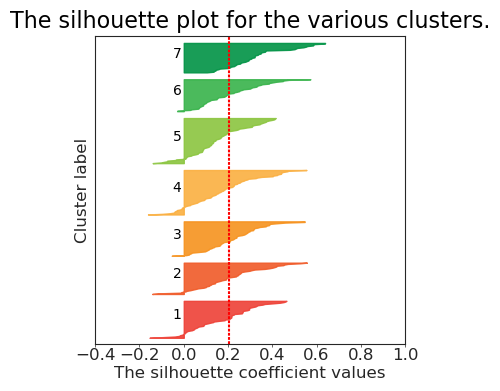

In [362]:
make_silhouette_plot(transformed_data[:,:num_retained_pcs], model.labels_)

The average silhouette coefficient is about 0.2. As a general rule, this is a fairly low clustering quality index. However, if the range of spread of the data in the high dimensional space is fixed, silhouette score will necessarily be lower when there are many clusters in the data. Thus, this silhouette cannot by itself be used to argue against clustering in these data. This is why the clustering quality in this case needs to be verified through other means, such as projection specificity or response stability for clusters.

The neurons with negative silhouette scores are assigned to the wrong cluster. So one possible approach could be to run clustering multiple times (it's stochastic) and only select neurons that are reliably assigned to their corresponding cluster. This will improve cluster-wise inference for other analyses. However, I wanted to keep the analysis simpler and hence, decided not to do such filtering.

Plot the identified clusters. This plot is a good comparison to the original plot of the data, which did not cluster the data

/tmp/ipykernel_3564623/3979681761.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


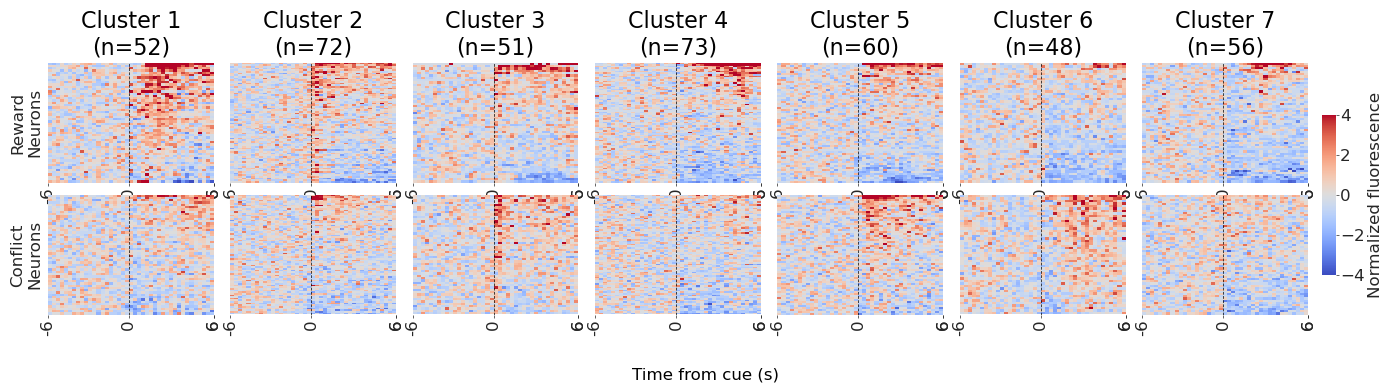

In [363]:
cmax = 4
sortwindow = [15, 100]

fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(trial_types)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numroisincluster = np.nan*np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels==cluster)[0], k*window_size:(k+1)*window_size]
        numroisincluster[c] = temp.shape[0]
        sortresponse = np.argsort(np.mean(temp[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
        sns.heatmap(temp[sortresponse],
                    ax=axs[k, cluster],
                    cmap=plt.get_cmap('coolwarm'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence'})
        axs[k, cluster].grid(False)
        if k==len(trial_types)-1:
            axs[k, cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[k, cluster].set_xticks([])
        axs[k, cluster].tick_params(width=0.5)
        axs[k, cluster].set_xticks([0, pre_window_size,
                            pre_window_size + frames_to_reward, window_size])

        axs[k, cluster].set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                         for a in [0, pre_window_size,
                                                   pre_window_size + frames_to_reward, window_size]])
        axs[k, cluster].set_yticks([])
        axs[k, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[k, cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster==0:
            axs[k, 0].set_ylabel('%s\nNeurons'%(tempkey))
    axs[0, cluster].set_title('Cluster %d\n(n=%d)'%(cluster+1, numroisincluster[c]))
    
fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

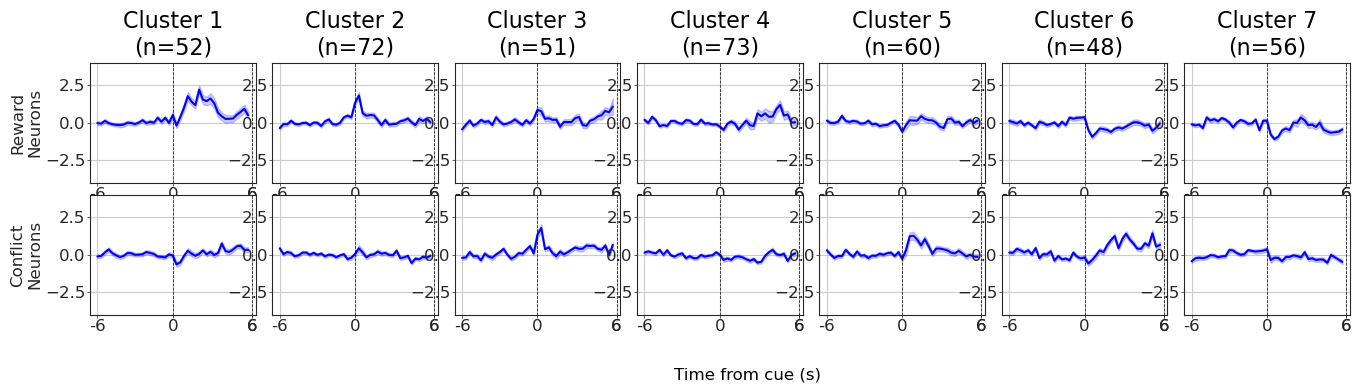

In [364]:
cmax = 4
sortwindow = [15, 100]

#fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
#                        figsize=(2*len(uniquelabels),2*len(trial_types)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 


fig, axs = plt.subplots(len(trial_types), len(uniquelabels),
                        figsize=(2 * len(uniquelabels), 2 * len(trial_types)))

numroisincluster = np.nan * np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels == cluster)[0], k * window_size:(k + 1) * window_size]
        numroisincluster[c] = temp.shape[0]

        # Calculate mean and standard deviation
        mean_temp = np.mean(temp, axis=0)
        std_temp = np.std(temp, axis=0)/np.sqrt(len(temp))

        # Plot the mean line
        axs[k, cluster].plot(mean_temp, label='Mean', color='blue')
        # Fill the area between mean ± std with a transparent color
        axs[k, cluster].fill_between(range(len(mean_temp)), mean_temp - std_temp, mean_temp + std_temp,
                                     color='blue', alpha=0.2, label='Std')

        axs[k, cluster].grid(True)
        if k == len(trial_types) - 1:
            axs[k, cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[k, cluster].set_xticks([])

        axs[k, cluster].tick_params(width=0.5)
        axs[k, cluster].set_xticks([0, pre_window_size,
                                     pre_window_size + frames_to_reward, window_size])

        axs[k, cluster].set_xticklabels([str(int((a - pre_window_size + 0.0) / framerate))
                                          for a in [0, pre_window_size,
                                                    pre_window_size + frames_to_reward, window_size]])
        #axs[k, cluster].set_yticks()
        axs[k, cluster].set_ylim(-4,4)
        axs[k, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[k, cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster == 0:
            axs[k, 0].set_ylabel('%s\nNeurons' % (tempkey))
    axs[0, cluster].set_title('Cluster %d\n(n=%d)' % (cluster + 1, numroisincluster[c]))

fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
#fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

plt.show()


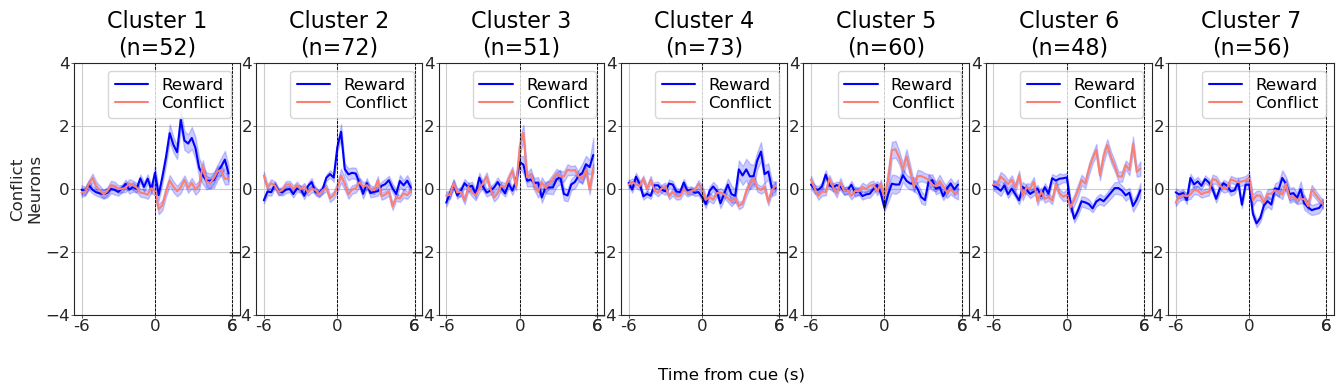

In [366]:
cmax = 4
sortwindow = [15, 100]

#fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
#                        figsize=(2*len(uniquelabels),2*len(trial_types)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 


fig, axs = plt.subplots(1, len(uniquelabels),
                        figsize=(2 * len(uniquelabels), 2 * len(trial_types)))

numroisincluster = np.nan * np.ones((len(uniquelabels),))

colors = ['blue', 'salmon']
trials = trial_types

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels == cluster)[0], k * window_size:(k + 1) * window_size]
        numroisincluster[c] = temp.shape[0]

        # Calculate mean and standard deviation
        mean_temp = np.mean(temp, axis=0)
        std_temp = np.std(temp, axis=0)/np.sqrt(len(temp))

        # Plot the mean line
        axs[cluster].plot(mean_temp, label= trials[k], color= colors[k])
        # Fill the area between mean ± std with a transparent color
        axs[cluster].fill_between(range(len(mean_temp)), mean_temp - std_temp, mean_temp + std_temp,
                                     color='blue', alpha=0.2)

        axs[cluster].grid(True)
        if k == len(trial_types) - 1:
            axs[cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[cluster].set_xticks([])

        axs[cluster].tick_params(width=0.5)
        axs[cluster].set_xticks([0, pre_window_size,
                                     pre_window_size + frames_to_reward, window_size])

        axs[cluster].set_xticklabels([str(int((a - pre_window_size + 0.0) / framerate))
                                          for a in [0, pre_window_size,
                                                    pre_window_size + frames_to_reward, window_size]])
        #axs[k, cluster].set_yticks()
        axs[cluster].set_ylim(-4,4)
        axs[cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster == 0:
            axs[0].set_ylabel('%s\nNeurons' % (tempkey))
    axs[cluster].set_title('Cluster %d\n(n=%d)' % (cluster + 1, numroisincluster[c]))
    axs[cluster].legend()

fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
#fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

plt.show()


Based on the responses of these identified clusters, the data do indeed look consistent with clustering. This is because the activity of neurons within a cluster look quite similar while activity across clusters looks quite different. As a further validation of the clustering, I will plot each neuron separated by clusters in the PCA space within which clustering was done.

Since there are 8 dimensions in the PCA space, I will use tSNE to reduce the dimensionality of this space to a 2D space. I will plot the tSNE transformation of the PCA scores of each pair of cluster against each other. If there are actually no real clusters, this plot will make it super clear. In this case, the default identified number of clusters will be two and in this plot, the two clusters will look like they belong to the same blob with an arbitrary line separating them. Instead, if there are real clusters, you will see different clusters forming different blobs when plotted against each other. 

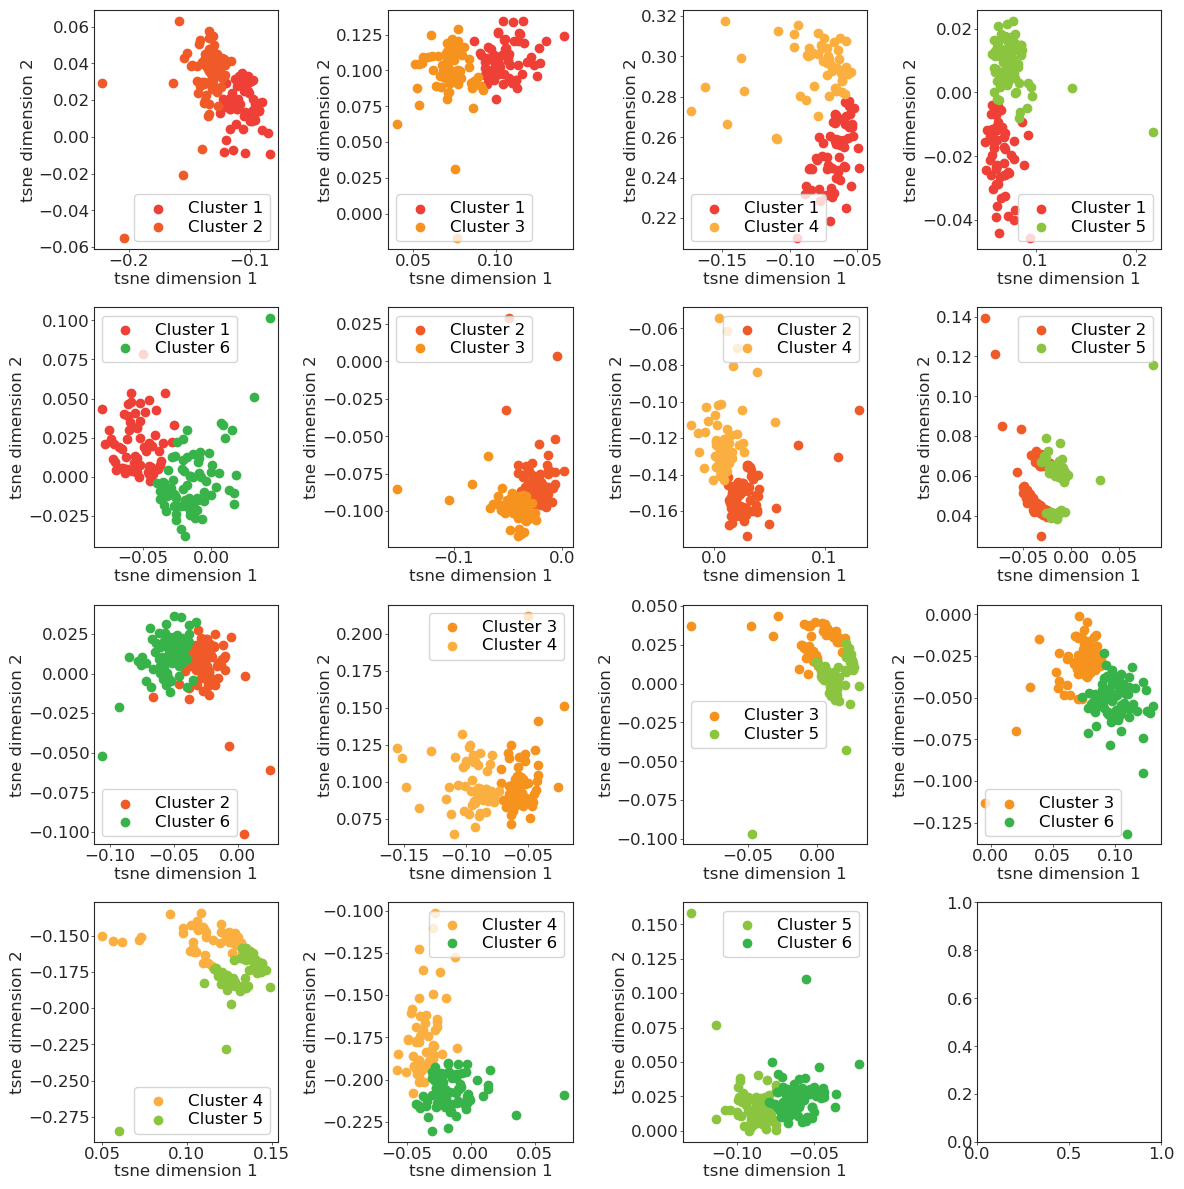

In [38]:
num_clusterpairs = len(uniquelabels)*(len(uniquelabels)-1)/2

numrows = int(np.ceil(num_clusterpairs**0.5))
numcols = int(np.ceil(num_clusterpairs/np.ceil(num_clusterpairs**0.5)))
fig, axs = plt.subplots(numrows, numcols, figsize=(3*numrows, 3*numcols))

tempsum = 0
for c1, cluster1 in enumerate(uniquelabels):
    for c2, cluster2 in enumerate(uniquelabels):
        if cluster1>=cluster2:
            continue
        temp1 = transformed_data[np.where(newlabels==cluster1)[0], :num_retained_pcs]
        temp2 = transformed_data[np.where(newlabels==cluster2)[0], :num_retained_pcs]
        X = np.concatenate((temp1, temp2), axis=0)
        tsne = TSNE(n_components=2, init='random',
                    random_state=0, perplexity=X.shape[0]-1)
        Y = tsne.fit_transform(X)
        if numrows * numcols == 1:
            ax = axs
        else:
            ax = axs[tempsum // numcols, tempsum - (tempsum // numcols) * numcols]


        ax.scatter(Y[:np.sum(newlabels==cluster1),0],
                   Y[:np.sum(newlabels==cluster1),1],
                   color=colors_for_cluster[cluster1], label='Cluster %d'%(cluster1+1), alpha=1)
        ax.scatter(Y[np.sum(newlabels==cluster1):,0],
                   Y[np.sum(newlabels==cluster1):,1],
                   color=colors_for_cluster[cluster2], label='Cluster %d'%(cluster2+1), alpha=1)

        ax.set_xlabel('tsne dimension 1')
        ax.set_ylabel('tsne dimension 2')
        ax.legend()
        tempsum += 1
fig.tight_layout()

In [65]:
all_cells = Reward.reset_index().iloc[:,:2]

# Perform a left join on 'Animal_ID' and 'Unit_ID' columns
merged = all_cells.merge(PhotoTag, on=['Animal_ID', 'Unit_id'], how='left')

# Fill missing values in the 'Unit_Type' column with 'unidentified'
merged['Unit_Type'] = merged['Unit_Type'].fillna('Unidentified')
merged['Cluster'] = newlabels+1

# Check the resulting DataFrame
print(merged)


    Unit_id Animal_ID     Unit_Type  Cluster
0    SPK04a       3P4        PL-NAc        5
1    SPK07a       3P4  Unidentified        4
2    SPK07b       3P4  Unidentified        4
3    SPK08a       3P4  Unidentified        6
4    SPK09a       3P4  Unidentified        1
..      ...       ...           ...      ...
407  SPK28a       5A4  Unidentified        3
408  SPK30a       5A4  Unidentified        4
409  SPK20a       5U5  Unidentified        4
410  SPK28a       5U5  Unidentified        5
411  SPK28b       5U5  Unidentified        1

[412 rows x 4 columns]


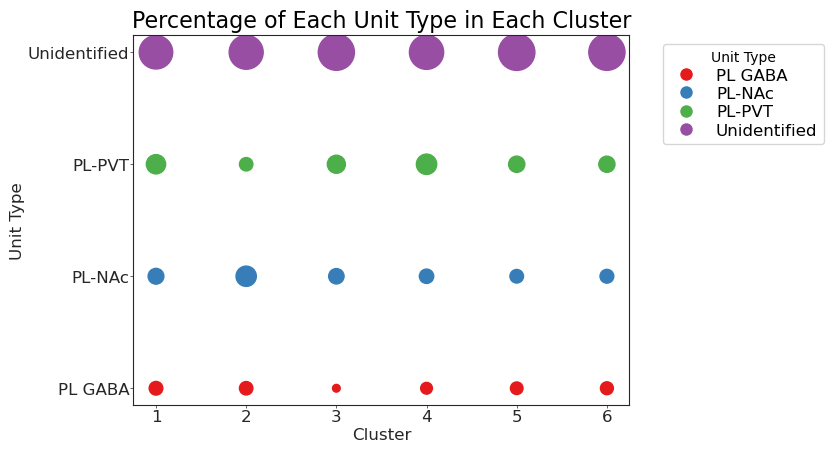

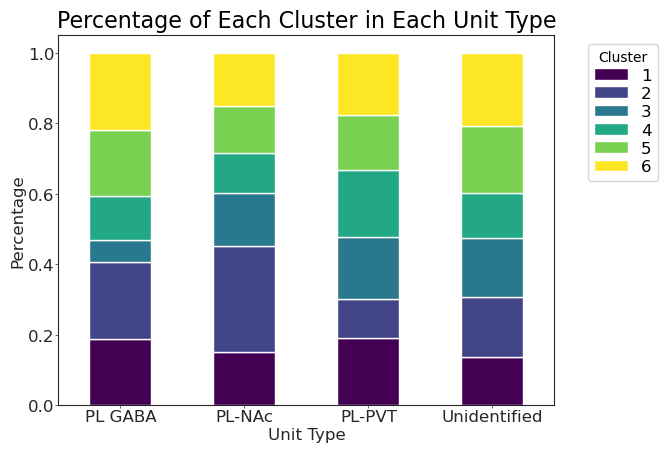

In [66]:

# Calculate the percentage of each unit type in each cluster
cluster_unit_type_counts = merged.groupby(['Cluster', 'Unit_Type']).size().unstack(fill_value=0)
cluster_unit_type_perc = cluster_unit_type_counts.div(cluster_unit_type_counts.sum(axis=1), axis=0)

# Calculate the percentage of each cluster in each unit type
unit_type_cluster_counts = merged.groupby(['Unit_Type', 'Cluster']).size().unstack(fill_value=0)
unit_type_cluster_perc = unit_type_cluster_counts.div(unit_type_cluster_counts.sum(axis=1), axis=0)

# Get the Pastel2 colormap
cmap = cm.get_cmap('Set1')

# Plot the percentage of each unit type in each cluster using a scatter plot
fig, ax = plt.subplots()
for i, unit_type in enumerate(cluster_unit_type_perc.columns):
    ax.scatter(cluster_unit_type_perc.index, [unit_type] * len(cluster_unit_type_perc), s=cluster_unit_type_perc[unit_type] * 1000, c =[cmap(i)])

ax.set_xticks(cluster_unit_type_perc.index)
ax.set_yticks(range(0, len(cluster_unit_type_perc.columns)))
ax.set_yticklabels(cluster_unit_type_perc.columns)

ax.set_xlabel('Cluster')
ax.set_ylabel('Unit Type')
ax.set_title('Percentage of Each Unit Type in Each Cluster')

# Create a proxy artist for the legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=unit_type, markerfacecolor=cmap(i), markersize=10) for i, unit_type in enumerate(cluster_unit_type_perc.columns)]
ax.legend(handles=legend_elements, title="Unit Type", bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot the percentage of each cluster in each unit type using a stacked histogram
fig, ax = plt.subplots()
unit_type_cluster_perc.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')

ax.set_xticklabels(unit_type_cluster_perc.index, rotation=0)
ax.set_xlabel('Unit Type')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Each Cluster in Each Unit Type')
ax.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()